### Notebook to configure model

In [2]:
import time
import math
import copy

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context(context="talk")

import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils import data


/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
isRetrain = False

# Hyperparameter

QUERY_SIZE = 50
EMBEDDING_SIZE = 50

# HIDDEN_SIZE = 512
# ATTENTION_SIZE = 64

LEARNING_RATE = 5*1e-3
BATCH_SIZE = 250

VOCAB_SIZE = 5
NUM_CLASSES = 2

# Data-specific

READ_LENGTH = 10

GENOME_START = 0
GENOME_END = 99


# # KRAS
# GENOME_START = 25204789
# GENOME_END = 25250936

# # NOTCH1
# GENOME_START = 136494433 
# GENOME_END = 136545786

# # NRAS
# GENOME_START = 114704464 
# GENOME_END = 114716894

GENOME_LENGTH = GENOME_END - GENOME_START + 1  
CONTEXT_SIZE = GENOME_LENGTH

ref_names = ["class", "ref", "sequence"]
VOCAB = ['N','A','T','C','G']


In [4]:
def load_ref_data(file_name, sample_ratio= 1, n_class=2, names=ref_names):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [5]:
def create_synthetic_data(file_name, cancer_genes, benign_genes, cancer_cnv=None, benign_cnv=None, num_patients=10, num_reads_per_patients=3, read_length=READ_LENGTH, genome_length=GENOME_LENGTH, vocab=VOCAB, isSomatic=True, print_seq=False):
    
    seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    backup_seq_list = seq_list
    
    for loc, mutation in cancer_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]        
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)

    if cancer_cnv is not None:
        for cnv, prob in cancer_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv      
    
    file = open('./tumor-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./tumor-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1, %d, %s\n" % (locs[r], reads[r]))
    file.close()
    
    tumor_locs = locs
    tumor_reads = reads

    if isSomatic:
        seq_list = backup_seq_list
    else:
        seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    
    for loc, mutation in benign_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)
    
    if benign_cnv is not None:
        for cnv, prob in benign_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv 
        
    file = open('./normal-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./normal-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("0, %d, %s\n" % (locs[r], reads[r]))
    file.close() 
    
    normal_locs = locs
    normal_reads = reads
    
    file = open('./syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1,%d,%s\n" % (tumor_locs[r], tumor_reads[r]))
        file.write("0,%d,%s\n" % (normal_locs[r], normal_reads[r]))
    file.close() 
    
    return './syn-'+file_name+'.csv'
    


In [6]:
def to_one_hot(y, n_class):
    
    return np.eye(n_class)[y.astype(int)]


In [7]:
def split_ref_dataset(x_test, y_test, ref_test, dev_ratio):

    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)

    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    ref_dev = ref_test[:dev_size]
    ref_test = ref_test[dev_size:]

    return x_test, x_dev, y_test, y_dev, ref_test, ref_dev, dev_size, test_size - dev_size


In [8]:
class TensorizedReadDataset(torch.utils.data.DataLoader):
    'Characterizes a Tensorized dataset for genome reads in PyTorch'
    
    def __init__(self, reads, ref_locs, labels, read_length=100, genome_start=0, genome_end=0):
#         super(TensorizedReadDataset, self).__init__()
        
        self.read_length = read_length
        self.labels = labels
        self.reads = reads
        self.ref_locs = ref_locs
        self.genome_start = genome_start
        self.genome_end = genome_end

    def __len__(self):
        return len(self.reads)

    def __getitem__(self, index):
        
        vals = list(self.reads[index])[0:self.read_length]        
        locs = list(np.arange(self.ref_locs[index]-self.genome_start,self.ref_locs[index]+self.read_length-self.genome_start))

#         print(len(vals))
#         print(len(locs))
        
        vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
#         read = torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int), requires_grad=False)

        read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
        X = read
        Y = self.labels[index,:]

#         torch.LongTensor(self.labels[index,:])

        return X, Y
    

In [9]:
class SequenceAttentionClassifier(nn.Module):
    
    def __init__(self, genome_length, vocab_size=5, query_size=10, embedding_size=128, num_classes=2):
        
        super(SequenceAttentionClassifier, self).__init__()
        
        self.genome_length = genome_length
        self.vocab_size = vocab_size
        self.query_size = query_size
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.K = nn.Embedding(vocab_size*genome_length, embedding_size)
        self.V = nn.Embedding(vocab_size*genome_length, query_size)
        self.W = nn.Linear(query_size, num_classes)
        self.Q = nn.Linear(embedding_size, query_size)
        
    def forward(self, read):
        
        # 'read' here should be mapped to a flattened form where X_ij = 1 maps to i*vocab_size + j
        K_lookup = self.K(read) # Get the relevant keys
        V_lookup = self.V(read) # Get the relevant values

        # Get the attention weights
        logits = self.Q(K_lookup) / math.sqrt(self.embedding_size)
        probs = F.softmax(logits, dim = 0)
        
        # Calculate the covariates for the logistic regression
#         X = torch.matmul(probs.transpose(1,2), V_lookup)
#         X = probs * V_lookup
        X = (probs * V_lookup).sum(dim=1)

        # Right now we can just ignore the fact that we're doing a linear-transform.
        # In the future we'll add nonlinearities

        # Return the logits for the classifier
        return self.W(X), K_lookup, V_lookup
    

In [19]:
# load data

cancer_genes = {5 :['A',0.95], 
                8 :['G',0.8],
                30:['T',1],
                31:['G',1],
                50:['A',0.6],
                55:['G',0.7],
                60:['G',1],
                70:['C',0.85],
                90:['C',1],
                95:['N',1]}
benign_genes = {10:['C',0.99],
                11:['G',0.98],
                12:['T',1],
                53:['A',0.9],
                80:['G',0.85]}

num_patients = 1000
num_reads_per_patients = 50
read_length = 95
file_name = 'p1000-t50-r95-somatic'

syn_file = create_synthetic_data(file_name, cancer_genes, benign_genes, None, None, num_patients, num_reads_per_patients, read_length, isSomatic=True)
print(syn_file)

x_train, refs_train, y_train = load_ref_data(syn_file, sample_ratio=1)


# split dataset to test and dev
x_train, x_test, y_train, y_test, refs_train, refs_test, test_size, train_size = \
    split_ref_dataset(x_train, y_train, refs_train, 0.01)
    
print("Validation size: ", test_size)
print("Training size: ", train_size)


./syn-p1000-t50-r95-somatic.csv
(100000, 2)
100000
1000
Validation size:  1000
Training size:  99000


In [381]:
## Generators
train_dataset = TensorizedReadDataset(reads=x_train, 
                                      ref_locs=refs_train, 
                                      labels=y_train, 
                                      read_length=READ_LENGTH, 
                                      genome_start=GENOME_START, 
                                      genome_end=GENOME_END)

test_dataset = TensorizedReadDataset(reads=x_test, 
                                        ref_locs=refs_test, 
                                        labels=y_test, 
                                        read_length=READ_LENGTH, 
                                        genome_start=GENOME_START, 
                                        genome_end=GENOME_END)


# Input pipeline
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)


In [10]:
# isRetrain = True
# file_name = 'p1000-t50-r95-somatic'

In [11]:
model = SequenceAttentionClassifier(genome_length=GENOME_LENGTH,
                                    vocab_size=VOCAB_SIZE,
                                    query_size=QUERY_SIZE,
                                    embedding_size=EMBEDDING_SIZE,
                                    num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

if isRetrain:
    model.load_state_dict(torch.load('./dummy_'+file_name+'_model.pth'))
    model = torch.load('./full_dummy_'+file_name+'_model.pt')

In [ ]:
num_epochs = 100

acc_each_epoch = []

loss_each_batch = []
acc_each_batch = []


# Training process
for epoch in range(num_epochs):
    b = 0 # count batch
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        outputs, K, V = model(x_batch) 
        
        lam = 1e-5
        
#         loss = criterion(outputs, y_batch) 
        data_loss = criterion(outputs, torch.max(y_batch.type(torch.LongTensor), 1)[1])
        reg_loss = (torch.norm(K,2,1).mean() + torch.norm(V,2,1).mean())*lam
        loss = data_loss + reg_loss
    
        loss.backward()
        optimizer.step()
        
        if (b + 1) % 10 == 0:
            print("Epoch {}, Batch {}, loss :{}".format(epoch + 1, b + 1, loss.data[0]))
        b = b + 1
        
        loss_each_batch.append(data_loss)
        
        correct = 0
        total = 0
        for x_batch, y_batch in test_loader:
            outputs, K, V = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()
        
        acc = int(correct) / total
#         print(total, int(correct), acc)
        print('Validation Accuracy: {}%'.format(100 * acc))   
        acc_each_batch.append(acc)
    
    correct = 0
    total = 0
    for x_batch, y_batch in test_loader:
        outputs, K, V = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()
    acc = int(correct) / total
    print('Validation Accuracy: {}%'.format(100 * acc))   
    acc_each_epoch.append(acc)

            

Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 10, loss :0.6954008936882019
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 20, loss :0.6952837109565735
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 30, loss :0.6892409324645996
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 40, loss :0.6973759531974792
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 50, loss :0.6941155791282654
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 60, loss :0.692406415939331
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 70, loss :0.6922132968902588
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 80, loss :0.6934112310409546


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 90, loss :0.691818356513977
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 100, loss :0.6937997341156006
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 110, loss :0.6951988339424133


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 120, loss :0.6934255957603455
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 130, loss :0.6922112703323364
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 140, loss :0.6904398202896118
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 150, loss :0.6906829476356506
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 160, loss :0.6924804449081421
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 170, loss :0.6914485692977905
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 180, loss :0.691921591758728
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 190, loss :0.6940209865570068
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 200, loss :0.691204845905304


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 210, loss :0.694066047668457
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 220, loss :0.692677915096283
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 230, loss :0.6935959458351135


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 240, loss :0.6936937570571899
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 250, loss :0.6940540671348572
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 260, loss :0.6935780644416809


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 270, loss :0.6910561323165894
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 280, loss :0.6900821924209595
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 290, loss :0.6943528056144714


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 300, loss :0.6921899318695068
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 310, loss :0.6934784054756165
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 320, loss :0.6916546821594238


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 330, loss :0.6889322400093079


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Epoch 1, Batch 340, loss :0.6911556720733643
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, Batch 350, loss :0.6928041577339172
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Epoch 1, Batch 360, loss :0.6924667954444885
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 370, loss :0.6926617622375488
Validation Accuracy: 52.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.2%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.1%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Epoch 1, Batch 380, loss :0.6940966844558716
Validation Accuracy: 52.2%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.2%
Validation Accuracy: 52.2%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Epoch 1, Batch 390, loss :0.6922036409378052


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.300000000000004%
Validation Accuracy: 52.5%
Validation Accuracy: 52.5%
Validation Accuracy: 52.5%
Validation Accuracy: 52.5%
Validation Accuracy: 52.5%
Validation Accuracy: 52.5%
Validation Accuracy: 52.6%
Epoch 2, Batch 10, loss :0.6932494044303894
Validation Accuracy: 52.6%
Validation Accuracy: 52.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.7%
Validation Accuracy: 52.900000000000006%
Validation Accuracy: 52.900000000000006%
Validation Accuracy: 52.900000000000006%
Validation Accuracy: 53.0%
Validation Accuracy: 53.0%
Validation Accuracy: 53.0%
Validation Accuracy: 53.0%
Epoch 2, Batch 20, loss :0.6917584538459778
Validation Accuracy: 52.800000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 52.900000000000006%
Validation Accuracy: 52.800000000000004%
Validation Accuracy: 53.0%
Validation Accuracy: 52.900000000000006%
Validation Accuracy: 53.2%
Validation Accuracy: 53.300000000000004%
Validation Accuracy: 53.2%
Validation Accuracy: 53.300000000000004%
Validation Accuracy: 53.300000000000004%
Epoch 2, Batch 30, loss :0.6939437389373779


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 53.800000000000004%
Validation Accuracy: 54.0%
Validation Accuracy: 54.0%
Validation Accuracy: 54.2%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.0%
Validation Accuracy: 54.0%
Validation Accuracy: 54.0%
Validation Accuracy: 54.0%
Validation Accuracy: 53.800000000000004%
Epoch 2, Batch 40, loss :0.6915841102600098
Validation Accuracy: 53.6%
Validation Accuracy: 53.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 53.300000000000004%
Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.6%
Validation Accuracy: 53.6%
Validation Accuracy: 53.7%
Validation Accuracy: 53.800000000000004%
Validation Accuracy: 53.900000000000006%
Validation Accuracy: 54.0%
Epoch 2, Batch 50, loss :0.6930350661277771
Validation Accuracy: 54.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 60, loss :0.6920939087867737
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.1%
Validation Accuracy: 54.0%
Validation Accuracy: 53.900000000000006%
Validation Accuracy: 53.7%
Validation Accuracy: 53.6%
Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.6%
Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.300000000000004%
Epoch 2, Batch 70, loss :0.6927961111068726
Validation Accuracy: 53.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.400000000000006%
Validation Accuracy: 53.7%
Validation Accuracy: 54.0%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.1%
Epoch 2, Batch 80, loss :0.6932010650634766


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Epoch 2, Batch 90, loss :0.6927841305732727
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.2%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Epoch 2, Batch 100, loss :0.6931582689285278
Validation Accuracy: 54.300000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 110, loss :0.6926381587982178
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Epoch 2, Batch 120, loss :0.6924505233764648
Validation Accuracy: 54.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.2%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 55.00000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 130, loss :0.6927822828292847
Validation Accuracy: 55.1%
Validation Accuracy: 54.7%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.2%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.50000000000001%
Validation Accuracy: 54.300000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.300000000000004%
Epoch 2, Batch 140, loss :0.6925117373466492
Validation Accuracy: 54.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 54.2%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.7%
Validation Accuracy: 54.400000000000006%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 150, loss :0.6917772889137268
Validation Accuracy: 54.400000000000006%
Validation Accuracy: 54.800000000000004%
Validation Accuracy: 54.7%
Validation Accuracy: 55.2%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.00000000000001%
Validation Accuracy: 55.2%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.2%
Epoch 2, Batch 160, loss :0.6919137835502625
Validation Accuracy: 55.00000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 55.1%
Validation Accuracy: 55.00000000000001%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.1%
Validation Accuracy: 55.1%
Validation Accuracy: 55.1%
Validation Accuracy: 55.1%
Validation Accuracy: 55.2%
Validation Accuracy: 55.300000000000004%
Epoch 2, Batch 170, loss :0.6925938725471497


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 55.2%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 55.7%
Validation Accuracy: 55.800000000000004%
Validation Accuracy: 55.60000000000001%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.2%
Validation Accuracy: 55.2%
Validation Accuracy: 55.2%
Validation Accuracy: 55.2%
Epoch 2, Batch 180, loss :0.6928389072418213
Validation Accuracy: 55.300000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 55.60000000000001%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.2%
Validation Accuracy: 55.60000000000001%
Validation Accuracy: 56.2%
Validation Accuracy: 56.2%
Validation Accuracy: 56.3%
Validation Accuracy: 56.3%
Validation Accuracy: 56.3%
Epoch 2, Batch 190, loss :0.6932340860366821


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.8%
Validation Accuracy: 56.89999999999999%
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 56.99999999999999%
Epoch 2, Batch 200, loss :0.6926968097686768
Validation Accuracy: 57.4%
Validation Accuracy: 56.99999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.99999999999999%
Validation Accuracy: 57.3%
Validation Accuracy: 56.8%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.699999999999996%
Validation Accuracy: 57.8%
Validation Accuracy: 57.4%
Epoch 2, Batch 210, loss :0.692788302898407
Validation Accuracy: 58.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Epoch 2, Batch 220, loss :0.6917367577552795


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.5%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.5%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 57.599999999999994%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.3%
Epoch 2, Batch 230, loss :0.6926994323730469
Validation Accuracy: 58.4%
Validation Accuracy: 58.599999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.5%
Validation Accuracy: 58.3%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 59.0%
Validation Accuracy: 58.8%
Epoch 2, Batch 240, loss :0.6923367977142334
Validation Accuracy: 58.699999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.8%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 59.099999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.9%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 250, loss :0.6924486756324768
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.4%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Epoch 2, Batch 260, loss :0.6916478872299194
Validation Accuracy: 58.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.4%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 57.8%
Validation Accuracy: 57.99999999999999%
Validation Accuracy: 57.3%
Validation Accuracy: 57.9%
Validation Accuracy: 57.9%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 57.99999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 270, loss :0.6920621395111084
Validation Accuracy: 57.4%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.8%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 57.599999999999994%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 58.5%
Epoch 2, Batch 280, loss :0.6919710040092468
Validation Accuracy: 58.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.4%
Validation Accuracy: 57.9%
Validation Accuracy: 57.8%
Validation Accuracy: 57.9%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 290, loss :0.6925451159477234
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.8%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.099999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 300, loss :0.6926249861717224
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 56.8%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 55.900000000000006%
Validation Accuracy: 56.3%
Epoch 2, Batch 310, loss :0.6926997303962708
Validation Accuracy: 56.599999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.699999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 320, loss :0.6924412846565247
Validation Accuracy: 56.8%
Validation Accuracy: 56.89999999999999%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.3%
Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.3%
Validation Accuracy: 56.3%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 55.300000000000004%
Epoch 2, Batch 330, loss :0.6928817629814148
Validation Accuracy: 55.50000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 55.900000000000006%
Validation Accuracy: 55.400000000000006%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.400000000000006%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 55.300000000000004%
Validation Accuracy: 55.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 2, Batch 340, loss :0.6927446722984314
Validation Accuracy: 56.2%
Validation Accuracy: 55.7%
Validation Accuracy: 55.7%
Validation Accuracy: 55.7%
Validation Accuracy: 55.7%
Validation Accuracy: 55.50000000000001%
Validation Accuracy: 56.2%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.699999999999996%
Epoch 2, Batch 350, loss :0.6925083994865417
Validation Accuracy: 56.599999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.8%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.8%
Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.39999999999999%
Validation Accuracy: 55.7%
Validation Accuracy: 56.2%
Epoch 2, Batch 360, loss :0.6926811933517456


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.39999999999999%
Validation Accuracy: 56.3%
Validation Accuracy: 56.49999999999999%
Validation Accuracy: 56.8%
Validation Accuracy: 56.8%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.8%
Validation Accuracy: 56.8%
Validation Accuracy: 56.8%
Validation Accuracy: 56.699999999999996%
Epoch 2, Batch 370, loss :0.6915755867958069
Validation Accuracy: 56.599999999999994%
Validation Accuracy: 56.599999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 56.8%
Validation Accuracy: 56.699999999999996%
Validation Accuracy: 56.8%
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Epoch 2, Batch 380, loss :0.6916379928588867
Validation Accuracy: 57.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 56.99999999999999%
Validation Accuracy: 56.8%
Validation Accuracy: 56.89999999999999%
Validation Accuracy: 56.89999999999999%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.4%
Epoch 2, Batch 390, loss :0.6927334070205688


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.4%
Validation Accuracy: 57.4%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 57.4%
Validation Accuracy: 57.599999999999994%
Validation Accuracy: 57.99999999999999%
Validation Accuracy: 57.9%
Validation Accuracy: 58.5%
Validation Accuracy: 58.4%
Validation Accuracy: 57.699999999999996%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 57.4%
Validation Accuracy: 57.099999999999994%
Validation Accuracy: 56.8%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.4%
Epoch 3, Batch 10, loss :0.6915808916091919
Validation Accuracy: 57.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.4%
Validation Accuracy: 57.699999999999996%
Validation Accuracy: 57.4%
Validation Accuracy: 57.3%
Validation Accuracy: 58.099999999999994%
Validation Accuracy: 58.4%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.4%
Epoch 3, Batch 20, loss :0.6921010613441467


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.4%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.4%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.4%
Epoch 3, Batch 30, loss :0.692719042301178
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.8%
Validation Accuracy: 58.5%
Validation Accuracy: 58.8%
Epoch 3, Batch 40, loss :0.6923494338989258
Validation Accuracy: 59.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.4%
Validation Accuracy: 58.4%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.8%
Validation Accuracy: 58.3%
Validation Accuracy: 58.4%
Epoch 3, Batch 50, loss :0.6926246881484985


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.5%
Validation Accuracy: 58.4%
Validation Accuracy: 57.8%
Validation Accuracy: 58.5%
Validation Accuracy: 57.8%
Validation Accuracy: 58.5%
Validation Accuracy: 58.4%
Validation Accuracy: 57.99999999999999%
Validation Accuracy: 58.5%
Validation Accuracy: 57.9%
Epoch 3, Batch 60, loss :0.692019522190094
Validation Accuracy: 57.599999999999994%
Validation Accuracy: 57.49999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.4%
Validation Accuracy: 57.4%
Validation Accuracy: 57.4%
Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.4%
Epoch 3, Batch 70, loss :0.6917518377304077
Validation Accuracy: 57.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.3%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.4%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Validation Accuracy: 57.3%
Epoch 3, Batch 80, loss :0.6926308870315552


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 57.199999999999996%
Validation Accuracy: 57.3%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 58.4%
Validation Accuracy: 58.4%
Validation Accuracy: 58.4%
Validation Accuracy: 58.4%
Validation Accuracy: 58.5%
Validation Accuracy: 58.5%
Validation Accuracy: 59.199999999999996%
Epoch 3, Batch 90, loss :0.692972719669342
Validation Accuracy: 59.5%
Validation Accuracy: 59.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 58.8%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 59.0%
Validation Accuracy: 58.699999999999996%
Epoch 3, Batch 100, loss :0.6923471689224243
Validation Accuracy: 58.699999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.9%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 59.199999999999996%
Validation Accuracy: 58.699999999999996%
Epoch 3, Batch 110, loss :0.6921389102935791


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.8%
Validation Accuracy: 58.8%
Validation Accuracy: 58.699999999999996%
Validation Accuracy: 59.4%
Validation Accuracy: 59.5%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 59.8%
Validation Accuracy: 59.4%
Validation Accuracy: 59.9%
Epoch 3, Batch 120, loss :0.6925795674324036
Validation Accuracy: 59.9%
Validation Accuracy: 60.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.9%
Validation Accuracy: 59.8%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 60.0%
Validation Accuracy: 59.5%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.599999999999994%
Epoch 3, Batch 130, loss :0.6920764446258545
Validation Accuracy: 59.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.8%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.8%
Validation Accuracy: 60.0%
Validation Accuracy: 60.0%
Validation Accuracy: 60.0%
Validation Accuracy: 60.5%
Validation Accuracy: 60.0%
Epoch 3, Batch 140, loss :0.6920673251152039
Validation Accuracy: 60.0%
Validation Accuracy: 60.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.9%
Validation Accuracy: 60.0%
Validation Accuracy: 60.0%
Validation Accuracy: 59.9%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.0%
Validation Accuracy: 60.199999999999996%
Epoch 3, Batch 150, loss :0.6919000744819641
Validation Accuracy: 60.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.4%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 60.0%
Epoch 3, Batch 160, loss :0.6922425627708435


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.699999999999996%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 59.8%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 60.0%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.0%
Validation Accuracy: 59.699999999999996%
Epoch 3, Batch 170, loss :0.6928392052650452
Validation Accuracy: 59.9%
Validation Accuracy: 60.099999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.0%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.0%
Validation Accuracy: 60.3%
Validation Accuracy: 60.0%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.3%
Validation Accuracy: 59.599999999999994%
Epoch 3, Batch 180, loss :0.692630410194397
Validation Accuracy: 59.599999999999994%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.9%
Validation Accuracy: 60.0%
Validation Accuracy: 59.8%
Validation Accuracy: 60.0%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.3%
Validation Accuracy: 59.699999999999996%
Epoch 3, Batch 190, loss :0.6922847628593445


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.099999999999994%
Validation Accuracy: 59.9%
Validation Accuracy: 60.0%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 59.699999999999996%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.199999999999996%
Epoch 3, Batch 200, loss :0.6922816634178162
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.3%
Validation Accuracy: 60.0%
Validation Accuracy: 60.0%
Validation Accuracy: 59.5%
Validation Accuracy: 59.8%
Validation Accuracy: 59.9%
Validation Accuracy: 59.599999999999994%
Validation Accuracy: 59.9%
Epoch 3, Batch 210, loss :0.6923768520355225
Validation Accuracy: 59.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.0%
Validation Accuracy: 59.8%
Validation Accuracy: 60.3%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.3%
Validation Accuracy: 60.4%
Validation Accuracy: 60.5%
Validation Accuracy: 60.5%
Epoch 3, Batch 220, loss :0.691575288772583


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.4%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.4%
Validation Accuracy: 60.3%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.6%
Validation Accuracy: 60.6%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.0%
Epoch 3, Batch 230, loss :0.6924347281455994


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.3%
Validation Accuracy: 60.4%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.6%
Validation Accuracy: 60.6%
Validation Accuracy: 60.9%
Validation Accuracy: 60.5%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.8%
Validation Accuracy: 60.6%
Epoch 3, Batch 240, loss :0.6921851634979248


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.6%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.6%
Validation Accuracy: 60.8%
Validation Accuracy: 60.3%
Validation Accuracy: 60.3%
Validation Accuracy: 60.3%
Validation Accuracy: 60.3%
Epoch 3, Batch 250, loss :0.692779004573822


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.3%
Validation Accuracy: 60.4%
Validation Accuracy: 60.4%
Validation Accuracy: 60.6%
Validation Accuracy: 60.6%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.5%
Validation Accuracy: 60.5%
Validation Accuracy: 60.6%
Validation Accuracy: 60.8%
Epoch 3, Batch 260, loss :0.6915777325630188
Validation Accuracy: 60.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.6%
Validation Accuracy: 60.4%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.8%
Validation Accuracy: 60.4%
Validation Accuracy: 60.5%
Validation Accuracy: 60.8%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.6%
Epoch 3, Batch 270, loss :0.6925302743911743


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.8%
Validation Accuracy: 60.6%
Validation Accuracy: 60.9%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.0%
Validation Accuracy: 60.6%
Validation Accuracy: 60.8%
Epoch 3, Batch 280, loss :0.6924402713775635
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.8%
Validation Accuracy: 60.8%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.9%
Validation Accuracy: 60.8%
Validation Accuracy: 60.8%
Validation Accuracy: 60.699999999999996%
Epoch 3, Batch 290, loss :0.6925678253173828
Validation Accuracy: 60.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.5%
Validation Accuracy: 61.8%
Validation Accuracy: 61.3%
Validation Accuracy: 61.8%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.9%
Validation Accuracy: 61.5%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Epoch 3, Batch 300, loss :0.6922982931137085


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.7%
Validation Accuracy: 61.6%
Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 61.7%
Validation Accuracy: 61.9%
Validation Accuracy: 61.6%
Validation Accuracy: 61.8%
Epoch 3, Batch 310, loss :0.6922987699508667
Validation Accuracy: 61.9%
Validation Accuracy: 61.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 61.7%
Validation Accuracy: 61.9%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.4%
Validation Accuracy: 61.4%
Epoch 3, Batch 320, loss :0.6918802857398987
Validation Accuracy: 61.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 61.5%
Validation Accuracy: 61.3%
Validation Accuracy: 61.3%
Validation Accuracy: 61.5%
Validation Accuracy: 61.4%
Validation Accuracy: 61.6%
Validation Accuracy: 61.4%
Validation Accuracy: 61.4%
Epoch 3, Batch 330, loss :0.6924599409103394


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.9%
Validation Accuracy: 61.0%
Validation Accuracy: 61.0%
Validation Accuracy: 61.0%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.8%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.6%
Validation Accuracy: 61.0%
Validation Accuracy: 60.8%
Epoch 3, Batch 340, loss :0.6916481852531433
Validation Accuracy: 60.8%
Validation Accuracy: 60.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.3%
Validation Accuracy: 61.5%
Validation Accuracy: 61.8%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.3%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Epoch 3, Batch 350, loss :0.6921126842498779
Validation Accuracy: 61.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.7%
Validation Accuracy: 61.6%
Validation Accuracy: 61.4%
Validation Accuracy: 62.2%
Validation Accuracy: 61.9%
Validation Accuracy: 61.4%
Epoch 3, Batch 360, loss :0.6915606260299683


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.5%
Validation Accuracy: 61.6%
Validation Accuracy: 61.4%
Validation Accuracy: 61.9%
Validation Accuracy: 61.6%
Validation Accuracy: 61.8%
Validation Accuracy: 61.6%
Epoch 3, Batch 370, loss :0.6923344135284424
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Validation Accuracy: 61.8%
Validation Accuracy: 61.0%
Validation Accuracy: 61.1%
Validation Accuracy: 61.1%
Validation Accuracy: 61.5%
Epoch 3, Batch 380, loss :0.6919581294059753
Validation Accuracy: 60.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.8%
Validation Accuracy: 61.0%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.9%
Validation Accuracy: 60.8%
Validation Accuracy: 61.4%
Validation Accuracy: 61.6%
Validation Accuracy: 60.6%
Validation Accuracy: 61.1%
Epoch 3, Batch 390, loss :0.6920482516288757


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.1%
Validation Accuracy: 61.4%
Validation Accuracy: 61.3%
Validation Accuracy: 61.0%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.0%
Validation Accuracy: 61.0%
Validation Accuracy: 61.3%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.9%
Validation Accuracy: 61.9%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 62.0%
Validation Accuracy: 62.2%
Validation Accuracy: 62.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 4, Batch 10, loss :0.6922537684440613
Validation Accuracy: 62.3%
Validation Accuracy: 62.0%
Validation Accuracy: 62.3%
Validation Accuracy: 62.3%
Validation Accuracy: 62.1%
Validation Accuracy: 62.4%
Validation Accuracy: 62.4%
Validation Accuracy: 61.9%
Validation Accuracy: 62.5%
Validation Accuracy: 62.1%
Epoch 4, Batch 20, loss :0.6922434568405151
Validation Accuracy: 61.8%
Validation Accuracy: 61.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 62.2%
Validation Accuracy: 61.9%
Validation Accuracy: 62.4%
Validation Accuracy: 62.7%
Validation Accuracy: 62.5%
Validation Accuracy: 62.1%
Validation Accuracy: 61.9%
Epoch 4, Batch 30, loss :0.6920133233070374
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.9%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 61.8%
Validation Accuracy: 61.5%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Epoch 4, Batch 40, loss :0.691997230052948


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.5%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.9%
Validation Accuracy: 61.1%
Validation Accuracy: 61.4%
Validation Accuracy: 61.5%
Validation Accuracy: 61.5%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.4%
Validation Accuracy: 61.4%
Epoch 4, Batch 50, loss :0.6920612454414368


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.3%
Validation Accuracy: 61.1%
Validation Accuracy: 61.1%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 60.9%
Validation Accuracy: 60.6%
Validation Accuracy: 61.1%
Validation Accuracy: 61.0%
Validation Accuracy: 61.1%
Validation Accuracy: 60.9%
Epoch 4, Batch 60, loss :0.6918642520904541
Validation Accuracy: 60.9%
Validation Accuracy: 61.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.0%
Validation Accuracy: 61.0%
Validation Accuracy: 61.3%
Validation Accuracy: 60.9%
Validation Accuracy: 61.0%
Validation Accuracy: 61.3%
Validation Accuracy: 61.3%
Validation Accuracy: 61.9%
Epoch 4, Batch 70, loss :0.6928291320800781
Validation Accuracy: 61.8%
Validation Accuracy: 61.3%
Validation Accuracy: 61.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.2%
Validation Accuracy: 61.7%
Validation Accuracy: 62.0%
Validation Accuracy: 62.3%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Epoch 4, Batch 80, loss :0.6917198896408081
Validation Accuracy: 62.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.6%
Validation Accuracy: 62.3%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Validation Accuracy: 62.5%
Epoch 4, Batch 90, loss :0.6919418573379517
Validation Accuracy: 62.1%
Validation Accuracy: 62.1%
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.5%
Validation Accuracy: 62.1%
Validation Accuracy: 62.4%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Epoch 4, Batch 100, loss :0.6921266317367554
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.4%
Validation Accuracy: 62.5%
Validation Accuracy: 61.8%
Validation Accuracy: 62.0%
Validation Accuracy: 62.2%
Validation Accuracy: 62.7%
Validation Accuracy: 62.5%
Validation Accuracy: 62.6%
Validation Accuracy: 62.0%
Epoch 4, Batch 110, loss :0.6918824911117554
Validation Accuracy: 62.2%
Validation Accuracy: 62.2%
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 62.3%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Epoch 4, Batch 120, loss :0.6924017667770386
Validation Accuracy: 62.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.1%
Validation Accuracy: 62.2%
Validation Accuracy: 62.3%
Validation Accuracy: 62.0%
Validation Accuracy: 62.1%
Validation Accuracy: 62.3%
Validation Accuracy: 62.2%
Validation Accuracy: 62.3%
Validation Accuracy: 62.7%
Epoch 4, Batch 130, loss :0.6918524503707886
Validation Accuracy: 62.4%
Validation Accuracy: 61.9%
Validation Accuracy: 62.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.6%
Validation Accuracy: 62.8%
Validation Accuracy: 62.6%
Validation Accuracy: 62.6%
Validation Accuracy: 62.8%
Validation Accuracy: 62.3%
Validation Accuracy: 62.7%
Epoch 4, Batch 140, loss :0.6921679377555847
Validation Accuracy: 62.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 62.0%
Validation Accuracy: 61.7%
Validation Accuracy: 61.9%
Validation Accuracy: 62.5%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Epoch 4, Batch 150, loss :0.6919360160827637
Validation Accuracy: 62.3%
Validation Accuracy: 62.8%
Validation Accuracy: 62.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.5%
Validation Accuracy: 62.6%
Validation Accuracy: 62.7%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Epoch 4, Batch 160, loss :0.6920211315155029
Validation Accuracy: 62.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.0%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 61.7%
Validation Accuracy: 61.5%
Validation Accuracy: 61.4%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 62.3%
Epoch 4, Batch 170, loss :0.6920678615570068
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 62.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.1%
Validation Accuracy: 62.4%
Validation Accuracy: 62.6%
Validation Accuracy: 62.1%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 62.5%
Epoch 4, Batch 180, loss :0.6921963691711426
Validation Accuracy: 62.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.6%
Validation Accuracy: 62.8%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 62.3%
Validation Accuracy: 62.1%
Validation Accuracy: 62.1%
Validation Accuracy: 62.6%
Validation Accuracy: 62.7%
Epoch 4, Batch 190, loss :0.6915259957313538
Validation Accuracy: 62.4%
Validation Accuracy: 62.4%
Validation Accuracy: 62.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 62.2%
Validation Accuracy: 62.2%
Validation Accuracy: 62.3%
Validation Accuracy: 62.0%
Validation Accuracy: 62.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 4, Batch 200, loss :0.6918618679046631
Validation Accuracy: 61.9%
Validation Accuracy: 62.2%
Validation Accuracy: 61.5%
Validation Accuracy: 61.6%
Validation Accuracy: 61.9%
Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 62.1%
Validation Accuracy: 61.8%
Epoch 4, Batch 210, loss :0.6922909617424011
Validation Accuracy: 61.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Validation Accuracy: 61.9%
Validation Accuracy: 62.1%
Validation Accuracy: 61.8%
Validation Accuracy: 61.6%
Validation Accuracy: 61.5%
Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Epoch 4, Batch 220, loss :0.6923706531524658
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.7%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 61.7%
Validation Accuracy: 62.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 4, Batch 230, loss :0.692264974117279
Validation Accuracy: 62.0%
Validation Accuracy: 62.1%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 62.2%
Validation Accuracy: 61.8%
Epoch 4, Batch 240, loss :0.6917107701301575
Validation Accuracy: 62.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 62.0%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.8%
Validation Accuracy: 61.4%
Epoch 4, Batch 250, loss :0.6921005845069885
Validation Accuracy: 61.5%
Validation Accuracy: 61.1%
Validation Accuracy: 61.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.6%
Validation Accuracy: 61.6%
Validation Accuracy: 61.0%
Validation Accuracy: 61.3%
Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Epoch 4, Batch 260, loss :0.6922330260276794
Validation Accuracy: 61.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 61.5%
Validation Accuracy: 61.4%
Validation Accuracy: 61.5%
Validation Accuracy: 61.7%
Validation Accuracy: 61.5%
Validation Accuracy: 61.4%
Validation Accuracy: 61.4%
Validation Accuracy: 61.5%
Epoch 4, Batch 270, loss :0.6916758418083191
Validation Accuracy: 61.6%
Validation Accuracy: 61.6%
Validation Accuracy: 61.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.5%
Validation Accuracy: 61.5%
Validation Accuracy: 61.4%
Validation Accuracy: 61.6%
Validation Accuracy: 61.7%
Validation Accuracy: 61.6%
Validation Accuracy: 61.6%
Epoch 4, Batch 280, loss :0.6922200918197632
Validation Accuracy: 61.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.5%
Validation Accuracy: 61.5%
Validation Accuracy: 61.3%
Validation Accuracy: 61.5%
Validation Accuracy: 61.6%
Validation Accuracy: 61.6%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 62.3%
Epoch 4, Batch 290, loss :0.6924578547477722
Validation Accuracy: 62.2%
Validation Accuracy: 62.5%
Validation Accuracy: 62.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.2%
Validation Accuracy: 62.3%
Validation Accuracy: 62.3%
Validation Accuracy: 62.5%
Validation Accuracy: 62.2%
Validation Accuracy: 63.0%
Validation Accuracy: 62.5%
Epoch 4, Batch 300, loss :0.6921600699424744
Validation Accuracy: 63.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.3%
Validation Accuracy: 62.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.7%
Validation Accuracy: 62.9%
Validation Accuracy: 62.7%
Validation Accuracy: 62.7%
Epoch 4, Batch 310, loss :0.6916118860244751
Validation Accuracy: 62.2%
Validation Accuracy: 62.0%
Validation Accuracy: 62.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.0%
Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Validation Accuracy: 61.9%
Validation Accuracy: 62.1%
Epoch 4, Batch 320, loss :0.6919777393341064


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.2%
Validation Accuracy: 62.0%
Validation Accuracy: 62.2%
Validation Accuracy: 62.4%
Validation Accuracy: 62.4%
Validation Accuracy: 62.2%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Validation Accuracy: 62.5%
Validation Accuracy: 62.6%
Epoch 4, Batch 330, loss :0.6923999190330505


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.2%
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.9%
Validation Accuracy: 63.3%
Validation Accuracy: 63.0%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 63.1%
Epoch 4, Batch 340, loss :0.6923037767410278
Validation Accuracy: 63.2%
Validation Accuracy: 63.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.3%
Validation Accuracy: 63.0%
Validation Accuracy: 63.2%
Validation Accuracy: 62.9%
Validation Accuracy: 63.1%
Validation Accuracy: 62.9%
Validation Accuracy: 62.4%
Validation Accuracy: 63.1%
Epoch 4, Batch 350, loss :0.6918365359306335
Validation Accuracy: 62.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.7%
Validation Accuracy: 62.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.3%
Validation Accuracy: 62.5%
Validation Accuracy: 62.6%
Validation Accuracy: 62.7%
Validation Accuracy: 62.8%
Validation Accuracy: 62.5%
Epoch 4, Batch 360, loss :0.69200599193573


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.3%
Validation Accuracy: 62.5%
Validation Accuracy: 63.0%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%
Validation Accuracy: 62.7%
Validation Accuracy: 63.0%
Validation Accuracy: 62.5%
Validation Accuracy: 62.7%
Validation Accuracy: 62.9%
Epoch 4, Batch 370, loss :0.6918633580207825


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 63.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.7%
Validation Accuracy: 62.5%
Validation Accuracy: 62.9%
Validation Accuracy: 62.4%
Epoch 4, Batch 380, loss :0.6920520663261414


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 62.8%
Validation Accuracy: 62.7%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 63.0%
Validation Accuracy: 62.0%
Validation Accuracy: 62.3%
Validation Accuracy: 62.2%
Validation Accuracy: 62.4%
Epoch 4, Batch 390, loss :0.6918051838874817
Validation Accuracy: 62.7%
Validation Accuracy: 62.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.3%
Validation Accuracy: 63.6%
Validation Accuracy: 62.7%
Validation Accuracy: 62.7%
Validation Accuracy: 62.8%
Validation Accuracy: 63.0%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 62.8%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 62.8%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 62.8%
Epoch 5, Batch 10, loss :0.691996157169342
Validation Accuracy: 62.7%
Validation Accuracy: 63.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.1%
Validation Accuracy: 62.6%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.1%
Epoch 5, Batch 20, loss :0.6917824745178223
Validation Accuracy: 62.8%
Validation Accuracy: 63.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 62.8%
Validation Accuracy: 62.7%
Validation Accuracy: 63.1%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Epoch 5, Batch 30, loss :0.691986083984375
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.1%
Validation Accuracy: 62.7%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 63.3%
Validation Accuracy: 63.0%
Epoch 5, Batch 40, loss :0.6918432116508484
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 63.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.2%
Validation Accuracy: 63.5%
Validation Accuracy: 63.5%
Epoch 5, Batch 50, loss :0.6920708417892456
Validation Accuracy: 63.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.8%
Validation Accuracy: 63.0%
Validation Accuracy: 63.1%
Validation Accuracy: 62.9%
Validation Accuracy: 62.5%
Validation Accuracy: 63.0%
Epoch 5, Batch 60, loss :0.6919950842857361
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.1%
Validation Accuracy: 63.2%
Validation Accuracy: 63.6%
Validation Accuracy: 62.8%
Validation Accuracy: 63.0%
Validation Accuracy: 62.7%
Validation Accuracy: 62.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 5, Batch 70, loss :0.6921618580818176
Validation Accuracy: 62.7%
Validation Accuracy: 63.2%
Validation Accuracy: 63.6%
Validation Accuracy: 63.2%
Validation Accuracy: 63.3%
Validation Accuracy: 63.1%
Validation Accuracy: 63.4%
Validation Accuracy: 63.3%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Epoch 5, Batch 80, loss :0.6918007135391235
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.8%
Validation Accuracy: 62.5%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 61.8%
Validation Accuracy: 61.1%
Validation Accuracy: 61.1%
Validation Accuracy: 61.7%
Validation Accuracy: 61.6%
Epoch 5, Batch 90, loss :0.6921407580375671
Validation Accuracy: 61.1%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.199999999999996%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.3%
Validation Accuracy: 62.7%
Validation Accuracy: 61.8%
Validation Accuracy: 61.4%
Validation Accuracy: 61.7%
Validation Accuracy: 62.0%
Validation Accuracy: 62.8%
Epoch 5, Batch 100, loss :0.6921682953834534
Validation Accuracy: 63.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.6%
Validation Accuracy: 63.5%
Validation Accuracy: 62.5%
Validation Accuracy: 62.8%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 62.6%
Validation Accuracy: 62.7%
Validation Accuracy: 63.4%
Epoch 5, Batch 110, loss :0.692303478717804
Validation Accuracy: 63.2%
Validation Accuracy: 63.4%
Validation Accuracy: 63.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.0%
Validation Accuracy: 62.6%
Validation Accuracy: 62.3%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.8%
Epoch 5, Batch 120, loss :0.6916680335998535
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.0%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 62.2%
Validation Accuracy: 62.3%
Validation Accuracy: 62.3%
Validation Accuracy: 62.7%
Validation Accuracy: 62.8%
Validation Accuracy: 62.9%
Epoch 5, Batch 130, loss :0.6918676495552063
Validation Accuracy: 62.5%
Validation Accuracy: 62.0%
Validation Accuracy: 62.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.5%
Validation Accuracy: 63.3%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.6%
Validation Accuracy: 63.5%
Validation Accuracy: 63.7%
Validation Accuracy: 63.800000000000004%
Epoch 5, Batch 140, loss :0.6920710802078247
Validation Accuracy: 63.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.0%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.0%
Validation Accuracy: 63.9%
Validation Accuracy: 63.6%
Validation Accuracy: 63.2%
Validation Accuracy: 63.0%
Validation Accuracy: 63.0%
Validation Accuracy: 62.9%
Epoch 5, Batch 150, loss :0.6922643780708313
Validation Accuracy: 63.2%
Validation Accuracy: 63.4%
Validation Accuracy: 63.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.0%
Validation Accuracy: 63.2%
Validation Accuracy: 63.1%
Validation Accuracy: 64.1%
Validation Accuracy: 63.3%
Validation Accuracy: 63.6%
Validation Accuracy: 63.800000000000004%
Epoch 5, Batch 160, loss :0.6918293833732605
Validation Accuracy: 63.800000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.5%
Validation Accuracy: 63.4%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%
Validation Accuracy: 64.0%
Validation Accuracy: 62.7%
Validation Accuracy: 63.1%
Validation Accuracy: 62.2%
Validation Accuracy: 61.8%
Epoch 5, Batch 170, loss :0.6915356516838074
Validation Accuracy: 62.6%
Validation Accuracy: 62.6%
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.0%
Validation Accuracy: 63.1%
Validation Accuracy: 62.8%
Validation Accuracy: 63.6%
Validation Accuracy: 63.2%
Validation Accuracy: 63.0%
Validation Accuracy: 62.1%
Epoch 5, Batch 180, loss :0.6914697885513306
Validation Accuracy: 62.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.3%
Validation Accuracy: 62.2%
Validation Accuracy: 61.9%
Validation Accuracy: 62.5%
Validation Accuracy: 62.1%
Validation Accuracy: 62.4%
Validation Accuracy: 62.4%
Validation Accuracy: 63.2%
Validation Accuracy: 62.7%
Epoch 5, Batch 190, loss :0.6923115253448486
Validation Accuracy: 63.0%
Validation Accuracy: 62.7%
Validation Accuracy: 63.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.5%
Validation Accuracy: 63.7%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.3%
Validation Accuracy: 64.1%
Validation Accuracy: 64.0%
Validation Accuracy: 63.800000000000004%
Epoch 5, Batch 200, loss :0.6917341351509094
Validation Accuracy: 63.800000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.1%
Validation Accuracy: 63.6%
Validation Accuracy: 63.2%
Validation Accuracy: 63.5%
Validation Accuracy: 63.7%
Validation Accuracy: 64.4%
Validation Accuracy: 64.3%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.800000000000004%
Epoch 5, Batch 210, loss :0.6913944482803345
Validation Accuracy: 63.7%
Validation Accuracy: 64.3%
Validation Accuracy: 64.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.2%
Validation Accuracy: 64.0%
Validation Accuracy: 64.4%
Validation Accuracy: 64.0%
Validation Accuracy: 64.1%
Validation Accuracy: 63.9%
Validation Accuracy: 64.3%
Epoch 5, Batch 220, loss :0.6915602684020996
Validation Accuracy: 64.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.9%
Validation Accuracy: 63.7%
Validation Accuracy: 64.3%
Validation Accuracy: 64.5%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.9%
Validation Accuracy: 64.4%
Validation Accuracy: 64.3%
Validation Accuracy: 63.7%
Epoch 5, Batch 230, loss :0.6918699741363525
Validation Accuracy: 63.2%
Validation Accuracy: 64.0%
Validation Accuracy: 63.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.1%
Validation Accuracy: 63.2%
Validation Accuracy: 62.7%
Validation Accuracy: 62.4%
Validation Accuracy: 62.4%
Validation Accuracy: 62.7%
Validation Accuracy: 62.3%
Epoch 5, Batch 240, loss :0.691808819770813
Validation Accuracy: 62.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 61.9%
Validation Accuracy: 62.0%
Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 62.2%
Validation Accuracy: 61.8%
Validation Accuracy: 62.6%
Epoch 5, Batch 250, loss :0.6915046572685242
Validation Accuracy: 62.3%
Validation Accuracy: 62.6%
Validation Accuracy: 62.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.4%
Validation Accuracy: 62.3%
Validation Accuracy: 62.8%
Validation Accuracy: 62.3%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Validation Accuracy: 62.1%
Epoch 5, Batch 260, loss :0.6917626261711121
Validation Accuracy: 61.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 62.1%
Validation Accuracy: 61.4%
Validation Accuracy: 61.6%
Validation Accuracy: 61.5%
Validation Accuracy: 61.8%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 61.9%
Epoch 5, Batch 270, loss :0.6919529438018799
Validation Accuracy: 62.0%
Validation Accuracy: 62.1%
Validation Accuracy: 61.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.6%
Validation Accuracy: 60.3%
Validation Accuracy: 59.8%
Validation Accuracy: 58.3%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.8%
Epoch 5, Batch 280, loss :0.6920702457427979
Validation Accuracy: 57.99999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.5%
Validation Accuracy: 58.8%
Validation Accuracy: 58.099999999999994%
Validation Accuracy: 58.4%
Validation Accuracy: 58.4%
Validation Accuracy: 58.9%
Validation Accuracy: 57.99999999999999%
Validation Accuracy: 58.199999999999996%
Validation Accuracy: 58.199999999999996%
Epoch 5, Batch 290, loss :0.6916118264198303
Validation Accuracy: 58.099999999999994%
Validation Accuracy: 57.49999999999999%
Validation Accuracy: 58.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.5%
Validation Accuracy: 59.4%
Validation Accuracy: 59.4%
Validation Accuracy: 59.9%
Validation Accuracy: 59.5%
Validation Accuracy: 60.199999999999996%
Validation Accuracy: 60.199999999999996%
Epoch 5, Batch 300, loss :0.6918314099311829
Validation Accuracy: 60.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.5%
Validation Accuracy: 60.8%
Validation Accuracy: 60.6%
Validation Accuracy: 61.4%
Validation Accuracy: 60.099999999999994%
Validation Accuracy: 60.4%
Validation Accuracy: 60.0%
Validation Accuracy: 58.9%
Validation Accuracy: 58.9%
Epoch 5, Batch 310, loss :0.6915653347969055
Validation Accuracy: 58.4%
Validation Accuracy: 57.99999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 58.5%
Validation Accuracy: 58.599999999999994%
Validation Accuracy: 58.099999999999994%
Validation Accuracy: 58.4%
Validation Accuracy: 58.5%
Validation Accuracy: 59.099999999999994%
Validation Accuracy: 59.0%
Validation Accuracy: 59.9%
Epoch 5, Batch 320, loss :0.6917386651039124


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.3%
Validation Accuracy: 61.0%
Validation Accuracy: 60.4%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.199999999999996%
Validation Accuracy: 61.1%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 60.4%
Validation Accuracy: 61.3%
Validation Accuracy: 60.9%
Epoch 5, Batch 330, loss :0.6920168399810791
Validation Accuracy: 60.4%
Validation Accuracy: 59.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.8%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.4%
Validation Accuracy: 60.3%
Validation Accuracy: 60.0%
Validation Accuracy: 59.5%
Validation Accuracy: 59.099999999999994%
Validation Accuracy: 60.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 5, Batch 340, loss :0.6919649243354797
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 61.5%
Validation Accuracy: 61.3%
Validation Accuracy: 61.8%
Validation Accuracy: 61.6%
Validation Accuracy: 62.5%
Validation Accuracy: 61.4%
Validation Accuracy: 62.5%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Epoch 5, Batch 350, loss :0.6917140483856201


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.2%
Validation Accuracy: 62.5%
Validation Accuracy: 62.5%
Validation Accuracy: 62.4%
Validation Accuracy: 62.9%
Validation Accuracy: 62.6%
Validation Accuracy: 62.7%
Validation Accuracy: 62.9%
Validation Accuracy: 62.8%
Validation Accuracy: 63.5%
Epoch 5, Batch 360, loss :0.692225456237793
Validation Accuracy: 64.2%
Validation Accuracy: 64.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.0%
Validation Accuracy: 64.7%
Validation Accuracy: 64.1%
Validation Accuracy: 64.4%
Validation Accuracy: 64.2%
Validation Accuracy: 64.2%
Validation Accuracy: 63.6%
Validation Accuracy: 64.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 5, Batch 370, loss :0.6915410161018372
Validation Accuracy: 63.4%
Validation Accuracy: 62.9%
Validation Accuracy: 63.0%
Validation Accuracy: 63.3%
Validation Accuracy: 64.1%
Validation Accuracy: 63.6%
Validation Accuracy: 63.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.6%
Validation Accuracy: 64.8%
Epoch 5, Batch 380, loss :0.6915269494056702
Validation Accuracy: 64.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.4%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.3%
Validation Accuracy: 64.3%
Validation Accuracy: 64.4%
Validation Accuracy: 64.7%
Validation Accuracy: 64.8%
Validation Accuracy: 65.0%
Epoch 5, Batch 390, loss :0.6918233633041382
Validation Accuracy: 64.9%
Validation Accuracy: 64.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.3%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 64.8%
Validation Accuracy: 64.7%
Validation Accuracy: 64.9%
Validation Accuracy: 65.4%
Validation Accuracy: 63.9%
Validation Accuracy: 63.6%
Validation Accuracy: 63.4%
Validation Accuracy: 64.2%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.0%
Validation Accuracy: 63.6%
Epoch 6, Batch 10, loss :0.6919686794281006
Validation Accuracy: 64.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.5%
Validation Accuracy: 63.5%
Validation Accuracy: 63.3%
Validation Accuracy: 63.1%
Validation Accuracy: 63.2%
Validation Accuracy: 63.3%
Validation Accuracy: 63.0%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%
Epoch 6, Batch 20, loss :0.6923288702964783


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.3%
Validation Accuracy: 63.6%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 64.4%
Validation Accuracy: 64.8%
Validation Accuracy: 65.0%
Validation Accuracy: 64.3%
Validation Accuracy: 64.9%
Epoch 6, Batch 30, loss :0.6917073130607605
Validation Accuracy: 65.2%
Validation Accuracy: 64.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.0%
Validation Accuracy: 64.5%
Validation Accuracy: 64.9%
Validation Accuracy: 64.2%
Validation Accuracy: 63.7%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.6%
Validation Accuracy: 63.6%
Epoch 6, Batch 40, loss :0.6914324164390564
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.9%
Validation Accuracy: 63.7%
Validation Accuracy: 63.3%
Validation Accuracy: 63.5%
Validation Accuracy: 63.6%
Validation Accuracy: 63.5%
Validation Accuracy: 63.3%
Validation Accuracy: 62.6%
Epoch 6, Batch 50, loss :0.691609799861908
Validation Accuracy: 62.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.9%
Validation Accuracy: 62.0%
Validation Accuracy: 62.9%
Validation Accuracy: 62.0%
Validation Accuracy: 62.4%
Validation Accuracy: 62.7%
Validation Accuracy: 63.1%
Validation Accuracy: 61.9%
Validation Accuracy: 61.6%
Epoch 6, Batch 60, loss :0.6914423704147339


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.6%
Validation Accuracy: 61.9%
Validation Accuracy: 61.7%
Validation Accuracy: 61.0%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 60.0%
Validation Accuracy: 60.699999999999996%
Validation Accuracy: 59.0%
Validation Accuracy: 59.099999999999994%
Epoch 6, Batch 70, loss :0.6915680170059204
Validation Accuracy: 59.099999999999994%
Validation Accuracy: 59.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 59.4%
Validation Accuracy: 59.3%
Validation Accuracy: 59.3%
Validation Accuracy: 60.4%
Validation Accuracy: 60.4%
Validation Accuracy: 60.6%
Validation Accuracy: 59.5%
Validation Accuracy: 60.5%
Epoch 6, Batch 80, loss :0.6922662258148193
Validation Accuracy: 61.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 60.9%
Validation Accuracy: 60.5%
Validation Accuracy: 61.7%
Validation Accuracy: 61.0%
Validation Accuracy: 60.8%
Validation Accuracy: 60.3%
Validation Accuracy: 60.4%
Validation Accuracy: 59.8%
Validation Accuracy: 60.3%
Epoch 6, Batch 90, loss :0.6919122934341431


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.0%
Validation Accuracy: 60.6%
Validation Accuracy: 61.1%
Validation Accuracy: 62.0%
Validation Accuracy: 61.5%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 61.9%
Validation Accuracy: 61.7%
Epoch 6, Batch 100, loss :0.6917765140533447
Validation Accuracy: 61.4%
Validation Accuracy: 61.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 63.2%
Validation Accuracy: 63.1%
Validation Accuracy: 63.0%
Validation Accuracy: 63.5%
Validation Accuracy: 63.2%
Validation Accuracy: 63.2%
Epoch 6, Batch 110, loss :0.691688597202301
Validation Accuracy: 63.1%
Validation Accuracy: 63.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.5%
Validation Accuracy: 61.7%
Validation Accuracy: 61.7%
Validation Accuracy: 61.8%
Validation Accuracy: 62.2%
Validation Accuracy: 63.0%
Validation Accuracy: 63.1%
Validation Accuracy: 61.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 6, Batch 120, loss :0.6923490166664124
Validation Accuracy: 62.9%
Validation Accuracy: 63.2%
Validation Accuracy: 63.1%
Validation Accuracy: 63.1%
Validation Accuracy: 63.4%
Validation Accuracy: 63.5%
Validation Accuracy: 63.4%
Validation Accuracy: 63.2%
Validation Accuracy: 63.3%
Validation Accuracy: 63.4%
Epoch 6, Batch 130, loss :0.6918676495552063


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.5%
Validation Accuracy: 63.7%
Validation Accuracy: 63.5%
Validation Accuracy: 63.5%
Validation Accuracy: 63.4%
Validation Accuracy: 63.4%
Validation Accuracy: 63.6%
Validation Accuracy: 64.0%
Validation Accuracy: 63.7%
Validation Accuracy: 63.7%
Epoch 6, Batch 140, loss :0.6914496421813965
Validation Accuracy: 63.7%
Validation Accuracy: 64.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.7%
Validation Accuracy: 63.5%
Validation Accuracy: 63.7%
Validation Accuracy: 63.4%
Validation Accuracy: 63.3%
Validation Accuracy: 63.5%
Validation Accuracy: 63.2%
Validation Accuracy: 63.800000000000004%
Epoch 6, Batch 150, loss :0.6909804344177246
Validation Accuracy: 63.3%
Validation Accuracy: 62.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 61.8%
Validation Accuracy: 62.0%
Validation Accuracy: 61.7%
Validation Accuracy: 62.2%
Validation Accuracy: 62.2%
Validation Accuracy: 61.3%
Validation Accuracy: 62.3%
Validation Accuracy: 63.1%
Epoch 6, Batch 160, loss :0.6918209791183472
Validation Accuracy: 63.3%
Validation Accuracy: 63.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.4%
Validation Accuracy: 63.6%
Validation Accuracy: 63.4%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.0%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.6%
Epoch 6, Batch 170, loss :0.6919873356819153
Validation Accuracy: 63.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.0%
Validation Accuracy: 63.9%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.2%
Validation Accuracy: 64.5%
Validation Accuracy: 64.2%
Validation Accuracy: 65.3%
Validation Accuracy: 65.2%
Validation Accuracy: 64.5%
Epoch 6, Batch 180, loss :0.6913172602653503
Validation Accuracy: 64.1%
Validation Accuracy: 64.0%
Validation Accuracy: 63.800000000000004%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.6%
Validation Accuracy: 63.5%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%
Validation Accuracy: 63.5%
Validation Accuracy: 63.5%
Epoch 6, Batch 190, loss :0.6917465329170227
Validation Accuracy: 62.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.3%
Validation Accuracy: 61.9%
Validation Accuracy: 61.8%
Validation Accuracy: 62.2%
Validation Accuracy: 61.9%
Validation Accuracy: 62.1%
Validation Accuracy: 62.0%
Validation Accuracy: 62.3%
Validation Accuracy: 62.1%
Epoch 6, Batch 200, loss :0.6917436122894287
Validation Accuracy: 62.5%
Validation Accuracy: 63.6%
Validation Accuracy: 64.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%
Validation Accuracy: 63.9%
Validation Accuracy: 64.1%
Validation Accuracy: 63.9%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 6, Batch 210, loss :0.6919859647750854
Validation Accuracy: 64.3%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.2%
Validation Accuracy: 63.9%
Validation Accuracy: 63.9%
Validation Accuracy: 63.9%
Validation Accuracy: 64.1%
Validation Accuracy: 64.2%
Validation Accuracy: 65.9%
Validation Accuracy: 65.9%
Epoch 6, Batch 220, loss :0.6911289095878601


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.5%
Validation Accuracy: 65.9%
Validation Accuracy: 64.7%
Validation Accuracy: 66.0%
Validation Accuracy: 66.2%
Validation Accuracy: 65.9%
Validation Accuracy: 66.0%
Validation Accuracy: 65.0%
Validation Accuracy: 66.2%
Validation Accuracy: 64.9%
Epoch 6, Batch 230, loss :0.6917927265167236
Validation Accuracy: 64.9%
Validation Accuracy: 65.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 65.9%
Validation Accuracy: 66.2%
Validation Accuracy: 65.4%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 64.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 6, Batch 240, loss :0.6912388205528259
Validation Accuracy: 64.2%
Validation Accuracy: 64.3%
Validation Accuracy: 64.0%
Validation Accuracy: 64.1%
Validation Accuracy: 64.1%
Validation Accuracy: 64.0%
Validation Accuracy: 64.0%
Validation Accuracy: 64.1%
Validation Accuracy: 64.1%
Validation Accuracy: 63.7%
Epoch 6, Batch 250, loss :0.6920598745346069
Validation Accuracy: 64.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.4%
Validation Accuracy: 63.4%
Validation Accuracy: 63.9%
Validation Accuracy: 64.0%
Validation Accuracy: 63.9%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 64.1%
Validation Accuracy: 64.0%
Validation Accuracy: 64.1%
Epoch 6, Batch 260, loss :0.6920767426490784
Validation Accuracy: 64.1%
Validation Accuracy: 64.3%
Validation Accuracy: 64.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.2%
Validation Accuracy: 64.1%
Validation Accuracy: 66.3%
Validation Accuracy: 65.5%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 65.10000000000001%
Epoch 6, Batch 270, loss :0.6917108297348022
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.9%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Validation Accuracy: 65.0%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.2%
Validation Accuracy: 64.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 6, Batch 280, loss :0.6916833519935608
Validation Accuracy: 64.7%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Validation Accuracy: 64.7%
Validation Accuracy: 64.8%
Validation Accuracy: 64.8%
Validation Accuracy: 64.9%
Validation Accuracy: 65.0%
Validation Accuracy: 65.0%
Validation Accuracy: 64.60000000000001%
Epoch 6, Batch 290, loss :0.6911520957946777


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 64.8%
Validation Accuracy: 64.9%
Validation Accuracy: 64.8%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Validation Accuracy: 65.5%
Validation Accuracy: 66.10000000000001%
Epoch 6, Batch 300, loss :0.6917276978492737
Validation Accuracy: 65.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.2%
Validation Accuracy: 66.4%
Validation Accuracy: 66.3%
Validation Accuracy: 66.8%
Validation Accuracy: 66.3%
Validation Accuracy: 66.0%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 64.7%
Validation Accuracy: 65.9%
Epoch 6, Batch 310, loss :0.6918560862541199
Validation Accuracy: 66.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.3%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.3%
Validation Accuracy: 66.5%
Validation Accuracy: 66.3%
Validation Accuracy: 66.2%
Validation Accuracy: 66.60000000000001%
Epoch 6, Batch 320, loss :0.6915324330329895


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.5%
Validation Accuracy: 66.4%
Validation Accuracy: 66.3%
Validation Accuracy: 66.8%
Validation Accuracy: 65.3%
Validation Accuracy: 64.2%
Validation Accuracy: 64.3%
Validation Accuracy: 64.3%
Validation Accuracy: 64.5%
Epoch 6, Batch 330, loss :0.6914833188056946
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.3%
Validation Accuracy: 64.3%
Validation Accuracy: 64.2%
Validation Accuracy: 64.5%
Validation Accuracy: 64.2%
Validation Accuracy: 64.8%
Validation Accuracy: 64.4%
Validation Accuracy: 64.9%
Epoch 6, Batch 340, loss :0.6914795637130737


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.2%
Validation Accuracy: 64.7%
Validation Accuracy: 64.2%
Validation Accuracy: 64.1%
Validation Accuracy: 64.5%
Validation Accuracy: 63.7%
Validation Accuracy: 64.0%
Validation Accuracy: 63.6%
Validation Accuracy: 63.1%
Validation Accuracy: 63.5%
Epoch 6, Batch 350, loss :0.6915257573127747
Validation Accuracy: 63.5%
Validation Accuracy: 62.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.4%
Validation Accuracy: 62.7%
Validation Accuracy: 62.6%
Validation Accuracy: 63.1%
Validation Accuracy: 62.9%
Validation Accuracy: 62.4%
Validation Accuracy: 64.3%
Validation Accuracy: 64.4%
Epoch 6, Batch 360, loss :0.6911383271217346
Validation Accuracy: 64.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.2%
Validation Accuracy: 64.5%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.4%
Validation Accuracy: 64.5%
Validation Accuracy: 64.2%
Validation Accuracy: 64.4%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 6, Batch 370, loss :0.6915019154548645
Validation Accuracy: 64.4%
Validation Accuracy: 64.7%
Validation Accuracy: 64.4%
Validation Accuracy: 64.5%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.5%
Validation Accuracy: 64.4%
Validation Accuracy: 64.4%
Validation Accuracy: 64.8%
Validation Accuracy: 64.5%
Epoch 6, Batch 380, loss :0.6916178464889526
Validation Accuracy: 64.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.5%
Validation Accuracy: 64.3%
Validation Accuracy: 64.5%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 64.9%
Validation Accuracy: 66.5%
Validation Accuracy: 66.5%
Validation Accuracy: 66.8%
Validation Accuracy: 66.8%
Epoch 6, Batch 390, loss :0.691454291343689
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.7%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 65.9%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.4%
Validation Accuracy: 65.4%
Validation Accuracy: 66.0%
Validation Accuracy: 66.2%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 66.2%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 7, Batch 10, loss :0.6911201477050781
Validation Accuracy: 66.3%
Validation Accuracy: 65.4%
Validation Accuracy: 66.0%
Validation Accuracy: 65.4%
Validation Accuracy: 65.3%
Validation Accuracy: 65.2%
Validation Accuracy: 65.3%
Validation Accuracy: 65.5%
Validation Accuracy: 65.3%
Validation Accuracy: 65.3%
Epoch 7, Batch 20, loss :0.6912093162536621
Validation Accuracy: 65.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.8%
Validation Accuracy: 66.7%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 65.7%
Validation Accuracy: 65.8%
Validation Accuracy: 64.7%
Validation Accuracy: 64.8%
Validation Accuracy: 64.5%
Epoch 7, Batch 30, loss :0.6912155151367188
Validation Accuracy: 64.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.60000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 64.5%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.5%
Validation Accuracy: 64.7%
Validation Accuracy: 65.0%
Validation Accuracy: 64.8%
Epoch 7, Batch 40, loss :0.6913225054740906


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.5%
Validation Accuracy: 63.1%
Validation Accuracy: 63.7%
Validation Accuracy: 64.8%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 63.6%
Validation Accuracy: 64.8%
Validation Accuracy: 64.7%
Validation Accuracy: 64.9%
Epoch 7, Batch 50, loss :0.6913956999778748


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.0%
Validation Accuracy: 64.5%
Validation Accuracy: 64.5%
Validation Accuracy: 64.8%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.7%
Validation Accuracy: 64.7%
Validation Accuracy: 64.7%
Validation Accuracy: 64.5%
Validation Accuracy: 64.8%
Epoch 7, Batch 60, loss :0.6910308599472046


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.5%
Validation Accuracy: 65.2%
Validation Accuracy: 64.5%
Validation Accuracy: 62.9%
Validation Accuracy: 64.7%
Validation Accuracy: 64.4%
Validation Accuracy: 63.4%
Validation Accuracy: 63.0%
Validation Accuracy: 63.2%
Validation Accuracy: 64.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 7, Batch 70, loss :0.6916167140007019
Validation Accuracy: 64.7%
Validation Accuracy: 64.1%
Validation Accuracy: 63.4%
Validation Accuracy: 64.0%
Validation Accuracy: 64.4%
Validation Accuracy: 64.7%
Validation Accuracy: 63.3%
Validation Accuracy: 63.4%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Epoch 7, Batch 80, loss :0.6911388039588928
Validation Accuracy: 64.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.60000000000001%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.7%
Validation Accuracy: 64.9%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.8%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 63.800000000000004%
Validation Accuracy: 63.4%
Epoch 7, Batch 90, loss :0.6914257407188416
Validation Accuracy: 63.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 63.3%
Validation Accuracy: 63.4%
Validation Accuracy: 63.5%
Validation Accuracy: 63.4%
Validation Accuracy: 63.1%
Validation Accuracy: 63.6%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 63.5%
Validation Accuracy: 64.7%
Epoch 7, Batch 100, loss :0.6912834644317627
Validation Accuracy: 64.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.9%
Validation Accuracy: 64.8%
Validation Accuracy: 64.7%
Validation Accuracy: 65.5%
Validation Accuracy: 64.8%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Validation Accuracy: 65.0%
Validation Accuracy: 64.60000000000001%
Epoch 7, Batch 110, loss :0.6919765472412109
Validation Accuracy: 64.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.3%
Validation Accuracy: 64.7%
Validation Accuracy: 64.7%
Validation Accuracy: 64.8%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.8%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 65.2%
Validation Accuracy: 65.4%
Epoch 7, Batch 120, loss :0.6917111277580261
Validation Accuracy: 64.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.0%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 64.9%
Validation Accuracy: 64.9%
Validation Accuracy: 65.2%
Validation Accuracy: 65.4%
Validation Accuracy: 65.4%
Validation Accuracy: 65.10000000000001%
Epoch 7, Batch 130, loss :0.6909053325653076
Validation Accuracy: 65.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.2%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 66.3%
Validation Accuracy: 66.2%
Epoch 7, Batch 140, loss :0.6915244460105896
Validation Accuracy: 66.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 66.5%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 66.2%
Validation Accuracy: 66.9%
Validation Accuracy: 66.5%
Epoch 7, Batch 150, loss :0.6915888786315918
Validation Accuracy: 66.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.8%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.2%
Validation Accuracy: 66.9%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.8%
Validation Accuracy: 66.8%
Epoch 7, Batch 160, loss :0.6911216974258423
Validation Accuracy: 66.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.60000000000001%
Validation Accuracy: 65.5%
Validation Accuracy: 65.3%
Validation Accuracy: 65.5%
Validation Accuracy: 65.4%
Validation Accuracy: 65.2%
Validation Accuracy: 65.3%
Validation Accuracy: 65.0%
Validation Accuracy: 65.3%
Epoch 7, Batch 170, loss :0.6914951205253601
Validation Accuracy: 65.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.5%
Validation Accuracy: 65.4%
Validation Accuracy: 65.0%
Validation Accuracy: 65.0%
Validation Accuracy: 65.0%
Validation Accuracy: 65.5%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.3%
Epoch 7, Batch 180, loss :0.6914438009262085
Validation Accuracy: 65.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.5%
Validation Accuracy: 65.7%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.4%
Validation Accuracy: 66.4%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 65.60000000000001%
Epoch 7, Batch 190, loss :0.6917726397514343
Validation Accuracy: 65.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.9%
Validation Accuracy: 65.9%
Validation Accuracy: 65.8%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.7%
Validation Accuracy: 65.7%
Epoch 7, Batch 200, loss :0.6915463805198669
Validation Accuracy: 65.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.5%
Validation Accuracy: 66.0%
Validation Accuracy: 66.5%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 66.2%
Validation Accuracy: 66.4%
Validation Accuracy: 66.5%
Epoch 7, Batch 210, loss :0.6913788318634033
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.9%
Validation Accuracy: 65.7%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.7%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 65.8%
Validation Accuracy: 66.5%
Epoch 7, Batch 220, loss :0.6909961700439453
Validation Accuracy: 66.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.2%
Validation Accuracy: 66.5%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 66.7%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Epoch 7, Batch 230, loss :0.6915050148963928
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Validation Accuracy: 66.7%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 65.60000000000001%
Epoch 7, Batch 240, loss :0.6913090944290161
Validation Accuracy: 65.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.3%
Validation Accuracy: 65.5%
Validation Accuracy: 65.3%
Validation Accuracy: 65.0%
Validation Accuracy: 64.8%
Validation Accuracy: 64.3%
Validation Accuracy: 63.2%
Validation Accuracy: 63.7%
Validation Accuracy: 63.3%
Epoch 7, Batch 250, loss :0.691815197467804


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 62.6%
Validation Accuracy: 63.4%
Validation Accuracy: 63.7%
Validation Accuracy: 64.7%
Validation Accuracy: 64.8%
Validation Accuracy: 65.0%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.9%
Validation Accuracy: 65.3%
Validation Accuracy: 65.4%
Epoch 7, Batch 260, loss :0.691474437713623
Validation Accuracy: 65.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 64.9%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.4%
Validation Accuracy: 65.4%
Validation Accuracy: 65.5%
Validation Accuracy: 65.4%
Validation Accuracy: 65.5%
Validation Accuracy: 65.8%
Validation Accuracy: 65.3%
Epoch 7, Batch 270, loss :0.6914907097816467
Validation Accuracy: 65.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.4%
Validation Accuracy: 66.0%
Validation Accuracy: 65.7%
Validation Accuracy: 65.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 7, Batch 280, loss :0.6913865804672241
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 65.9%
Validation Accuracy: 66.0%
Validation Accuracy: 66.2%
Validation Accuracy: 65.7%
Validation Accuracy: 65.5%
Validation Accuracy: 65.9%
Validation Accuracy: 65.60000000000001%
Epoch 7, Batch 290, loss :0.6916635632514954
Validation Accuracy: 65.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.5%
Validation Accuracy: 65.0%
Validation Accuracy: 64.8%
Validation Accuracy: 65.0%
Validation Accuracy: 65.0%
Validation Accuracy: 64.5%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 65.0%
Epoch 7, Batch 300, loss :0.691350519657135
Validation Accuracy: 64.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.3%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 64.9%
Validation Accuracy: 64.7%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.0%
Validation Accuracy: 64.9%
Validation Accuracy: 65.2%
Validation Accuracy: 65.4%
Epoch 7, Batch 310, loss :0.6915528178215027
Validation Accuracy: 65.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 65.5%
Validation Accuracy: 65.8%
Validation Accuracy: 65.5%
Validation Accuracy: 65.5%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.4%
Epoch 7, Batch 320, loss :0.6913109421730042


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.7%
Validation Accuracy: 65.5%
Validation Accuracy: 65.7%
Validation Accuracy: 65.8%
Validation Accuracy: 65.7%
Validation Accuracy: 65.5%
Validation Accuracy: 65.7%
Validation Accuracy: 66.4%
Validation Accuracy: 66.4%
Validation Accuracy: 66.2%
Epoch 7, Batch 330, loss :0.6914317607879639


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.3%
Validation Accuracy: 66.5%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.4%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.2%
Epoch 7, Batch 340, loss :0.6910542845726013
Validation Accuracy: 66.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 7, Batch 350, loss :0.6918050646781921
Validation Accuracy: 67.2%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.0%
Validation Accuracy: 66.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 7, Batch 360, loss :0.6913591623306274
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.9%
Validation Accuracy: 65.9%
Validation Accuracy: 65.7%
Validation Accuracy: 65.4%
Validation Accuracy: 65.7%
Validation Accuracy: 65.60000000000001%
Epoch 7, Batch 370, loss :0.6914851069450378


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.8%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.5%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.9%
Validation Accuracy: 66.0%
Validation Accuracy: 65.7%
Validation Accuracy: 66.0%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 66.10000000000001%
Epoch 7, Batch 380, loss :0.6906638145446777


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.3%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.7%
Validation Accuracy: 65.7%
Validation Accuracy: 65.9%
Validation Accuracy: 65.8%
Validation Accuracy: 65.5%
Validation Accuracy: 65.8%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 65.9%
Epoch 7, Batch 390, loss :0.6914340257644653


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.2%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%
Validation Accuracy: 66.5%
Epoch 8, Batch 10, loss :0.6915360689163208
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 65.8%
Validation Accuracy: 66.2%
Epoch 8, Batch 20, loss :0.691474437713623
Validation Accuracy: 66.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.5%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.5%
Validation Accuracy: 66.4%
Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.5%
Epoch 8, Batch 30, loss :0.691676139831543
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 67.0%
Epoch 8, Batch 40, loss :0.6914404630661011
Validation Accuracy: 67.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.3%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.4%
Validation Accuracy: 66.4%
Validation Accuracy: 66.0%
Validation Accuracy: 66.5%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 66.3%
Epoch 8, Batch 50, loss :0.6914095878601074
Validation Accuracy: 66.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.5%
Validation Accuracy: 66.2%
Validation Accuracy: 66.0%
Validation Accuracy: 66.4%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.0%
Epoch 8, Batch 60, loss :0.6916778087615967
Validation Accuracy: 67.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.2%
Validation Accuracy: 67.2%
Validation Accuracy: 67.4%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 70, loss :0.6914070248603821
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Epoch 8, Batch 80, loss :0.6914902925491333


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.7%
Validation Accuracy: 66.0%
Validation Accuracy: 66.0%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.2%
Validation Accuracy: 66.0%
Validation Accuracy: 66.5%
Validation Accuracy: 66.0%
Validation Accuracy: 66.3%
Validation Accuracy: 66.0%
Epoch 8, Batch 90, loss :0.6916699409484863
Validation Accuracy: 67.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.9%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 100, loss :0.6916748881340027
Validation Accuracy: 67.0%
Validation Accuracy: 67.2%
Validation Accuracy: 66.8%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 67.2%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.0%
Epoch 8, Batch 110, loss :0.6914824843406677
Validation Accuracy: 67.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 120, loss :0.6911725401878357
Validation Accuracy: 66.4%
Validation Accuracy: 66.3%
Validation Accuracy: 66.7%
Validation Accuracy: 66.2%
Validation Accuracy: 66.2%
Validation Accuracy: 66.2%
Validation Accuracy: 66.5%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.10000000000001%
Epoch 8, Batch 130, loss :0.6914660334587097
Validation Accuracy: 66.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.8%
Validation Accuracy: 67.2%
Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.2%
Validation Accuracy: 67.4%
Validation Accuracy: 67.0%
Validation Accuracy: 66.5%
Validation Accuracy: 66.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 140, loss :0.6914016008377075
Validation Accuracy: 66.3%
Validation Accuracy: 67.0%
Validation Accuracy: 67.5%
Validation Accuracy: 66.4%
Validation Accuracy: 67.4%
Validation Accuracy: 66.5%
Validation Accuracy: 66.2%
Validation Accuracy: 66.4%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.4%
Epoch 8, Batch 150, loss :0.6910216212272644
Validation Accuracy: 66.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 66.3%
Validation Accuracy: 66.3%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 66.4%
Validation Accuracy: 67.30000000000001%
Epoch 8, Batch 160, loss :0.6913292407989502
Validation Accuracy: 67.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.60000000000001%
Validation Accuracy: 66.2%
Validation Accuracy: 66.2%
Validation Accuracy: 67.2%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.7%
Epoch 8, Batch 170, loss :0.6910930275917053
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.5%
Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.7%
Epoch 8, Batch 180, loss :0.6911666989326477


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.7%
Validation Accuracy: 66.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 190, loss :0.6909283995628357
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 66.3%
Validation Accuracy: 66.5%
Validation Accuracy: 66.7%
Validation Accuracy: 66.5%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.5%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 200, loss :0.6916627287864685
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.0%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.3%
Validation Accuracy: 66.4%
Validation Accuracy: 66.4%
Validation Accuracy: 66.7%
Validation Accuracy: 66.60000000000001%
Epoch 8, Batch 210, loss :0.6910925507545471
Validation Accuracy: 66.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.4%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 66.2%
Validation Accuracy: 66.3%
Validation Accuracy: 66.4%
Validation Accuracy: 66.5%
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 220, loss :0.6910810470581055
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.4%
Epoch 8, Batch 230, loss :0.6908847689628601
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Epoch 8, Batch 240, loss :0.6910774111747742


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 68.0%
Epoch 8, Batch 250, loss :0.6913580894470215
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.9%
Epoch 8, Batch 260, loss :0.6915090680122375
Validation Accuracy: 67.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.4%
Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Epoch 8, Batch 270, loss :0.6912779211997986


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.5%
Validation Accuracy: 67.5%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.4%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.7%
Epoch 8, Batch 280, loss :0.6913121342658997
Validation Accuracy: 67.0%
Validation Accuracy: 67.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.5%
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%
Validation Accuracy: 67.0%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.5%
Validation Accuracy: 66.3%
Validation Accuracy: 66.8%
Epoch 8, Batch 290, loss :0.6908915638923645
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 300, loss :0.6916735768318176
Validation Accuracy: 67.7%
Validation Accuracy: 67.5%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.9%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Epoch 8, Batch 310, loss :0.6912945508956909
Validation Accuracy: 66.7%
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.9%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 66.5%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 67.0%
Epoch 8, Batch 320, loss :0.6913995146751404
Validation Accuracy: 67.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.9%
Validation Accuracy: 67.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 8, Batch 330, loss :0.6911892890930176
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 66.8%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Epoch 8, Batch 340, loss :0.6914221048355103


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.9%
Validation Accuracy: 67.7%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Epoch 8, Batch 350, loss :0.6912131905555725


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.7%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Epoch 8, Batch 360, loss :0.6915118098258972


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.7%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.0%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 68.0%
Validation Accuracy: 67.60000000000001%
Epoch 8, Batch 370, loss :0.6909079551696777


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.9%
Validation Accuracy: 68.30000000000001%
Epoch 8, Batch 380, loss :0.6913240551948547


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.2%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.5%
Epoch 8, Batch 390, loss :0.6911157369613647


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.9%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 68.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 10, loss :0.6910778284072876
Validation Accuracy: 67.4%
Validation Accuracy: 67.4%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.8%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.4%
Validation Accuracy: 67.0%
Epoch 9, Batch 20, loss :0.6909657716751099
Validation Accuracy: 67.4%
Validation Accuracy: 67.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 67.9%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.7%
Epoch 9, Batch 30, loss :0.6909464001655579
Validation Accuracy: 67.7%
Validation Accuracy: 68.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.0%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 67.80000000000001%
Epoch 9, Batch 40, loss :0.690984308719635
Validation Accuracy: 67.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 67.60000000000001%
Epoch 9, Batch 50, loss :0.6913130283355713
Validation Accuracy: 67.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.9%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 68.0%
Validation Accuracy: 67.4%
Epoch 9, Batch 60, loss :0.691234290599823


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Validation Accuracy: 68.0%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.4%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.0%
Epoch 9, Batch 70, loss :0.6913079023361206


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.4%
Validation Accuracy: 68.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.4%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.2%
Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Epoch 9, Batch 80, loss :0.6915557384490967


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.4%
Validation Accuracy: 67.9%
Validation Accuracy: 68.0%
Validation Accuracy: 67.5%
Validation Accuracy: 68.0%
Validation Accuracy: 67.7%
Validation Accuracy: 68.0%
Validation Accuracy: 68.2%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.30000000000001%
Epoch 9, Batch 90, loss :0.6911501288414001


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.0%
Validation Accuracy: 67.4%
Validation Accuracy: 66.9%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 100, loss :0.691182553768158
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.7%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%
Epoch 9, Batch 110, loss :0.6908673048019409


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.0%
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.7%
Validation Accuracy: 67.0%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Epoch 9, Batch 120, loss :0.691127598285675
Validation Accuracy: 66.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Epoch 9, Batch 130, loss :0.6907688975334167


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 66.8%
Validation Accuracy: 65.9%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 64.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 140, loss :0.6909601092338562
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.4%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 66.0%
Validation Accuracy: 65.9%
Validation Accuracy: 67.0%
Validation Accuracy: 66.7%
Validation Accuracy: 66.8%
Validation Accuracy: 66.60000000000001%
Epoch 9, Batch 150, loss :0.6914525628089905
Validation Accuracy: 65.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.9%
Validation Accuracy: 65.2%
Validation Accuracy: 65.4%
Validation Accuracy: 64.1%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 65.0%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.5%
Validation Accuracy: 64.0%
Epoch 9, Batch 160, loss :0.6915298104286194
Validation Accuracy: 64.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.8%
Validation Accuracy: 66.10000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.5%
Validation Accuracy: 65.8%
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 170, loss :0.6911824345588684
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 67.2%
Validation Accuracy: 66.9%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.8%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.8%
Validation Accuracy: 66.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 180, loss :0.6907433867454529
Validation Accuracy: 67.2%
Validation Accuracy: 66.9%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 66.3%
Validation Accuracy: 65.8%
Validation Accuracy: 65.7%
Validation Accuracy: 66.7%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.0%
Validation Accuracy: 66.7%
Epoch 9, Batch 190, loss :0.6907308101654053
Validation Accuracy: 66.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.8%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.7%
Validation Accuracy: 65.3%
Validation Accuracy: 65.10000000000001%
Validation Accuracy: 64.1%
Validation Accuracy: 64.3%
Validation Accuracy: 64.5%
Validation Accuracy: 64.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 200, loss :0.690483808517456
Validation Accuracy: 64.2%
Validation Accuracy: 64.2%
Validation Accuracy: 64.60000000000001%
Validation Accuracy: 64.2%
Validation Accuracy: 65.3%
Validation Accuracy: 65.5%
Validation Accuracy: 65.4%
Validation Accuracy: 65.9%
Validation Accuracy: 65.8%
Validation Accuracy: 65.3%
Epoch 9, Batch 210, loss :0.6911935210227966
Validation Accuracy: 65.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 65.5%
Validation Accuracy: 65.7%
Validation Accuracy: 66.9%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 65.60000000000001%
Validation Accuracy: 65.2%
Validation Accuracy: 64.4%
Validation Accuracy: 64.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 220, loss :0.6908078789710999
Validation Accuracy: 65.0%
Validation Accuracy: 65.0%
Validation Accuracy: 65.7%
Validation Accuracy: 65.7%
Validation Accuracy: 66.4%
Validation Accuracy: 65.7%
Validation Accuracy: 66.2%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Epoch 9, Batch 230, loss :0.6911534667015076
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.7%
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 240, loss :0.6911876201629639
Validation Accuracy: 67.5%
Validation Accuracy: 67.5%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.60000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%
Validation Accuracy: 68.2%
Validation Accuracy: 67.7%
Epoch 9, Batch 250, loss :0.6909672021865845
Validation Accuracy: 67.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.7%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.2%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.2%
Epoch 9, Batch 260, loss :0.6907334327697754


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.4%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.30000000000001%
Epoch 9, Batch 270, loss :0.691242516040802
Validation Accuracy: 68.5%
Validation Accuracy: 68.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.8%
Validation Accuracy: 68.8%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.60000000000001%
Epoch 9, Batch 280, loss :0.6910135746002197
Validation Accuracy: 68.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.4%
Validation Accuracy: 68.4%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.60000000000001%
Epoch 9, Batch 290, loss :0.6913945078849792


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.4%
Validation Accuracy: 68.7%
Validation Accuracy: 68.60000000000001%
Epoch 9, Batch 300, loss :0.6909856200218201
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 68.7%
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 67.9%
Epoch 9, Batch 310, loss :0.6907588839530945
Validation Accuracy: 68.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 67.9%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Epoch 9, Batch 320, loss :0.6914429068565369


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.4%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Epoch 9, Batch 330, loss :0.6907446384429932
Validation Accuracy: 67.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.30000000000001%
Epoch 9, Batch 340, loss :0.6917688846588135
Validation Accuracy: 67.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 67.0%
Validation Accuracy: 67.2%
Validation Accuracy: 67.2%
Validation Accuracy: 67.4%
Validation Accuracy: 67.5%
Epoch 9, Batch 350, loss :0.6907114386558533
Validation Accuracy: 67.5%
Validation Accuracy: 67.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.5%
Validation Accuracy: 67.4%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 9, Batch 360, loss :0.691305935382843
Validation Accuracy: 67.4%
Validation Accuracy: 67.4%
Validation Accuracy: 67.9%
Validation Accuracy: 68.0%
Validation Accuracy: 68.4%
Validation Accuracy: 68.7%
Validation Accuracy: 68.8%
Validation Accuracy: 68.7%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Epoch 9, Batch 370, loss :0.6908085346221924
Validation Accuracy: 68.7%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.60000000000001%
Epoch 9, Batch 380, loss :0.6911906003952026
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.60000000000001%
Epoch 9, Batch 390, loss :0.690955400466919
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Validation Accuracy: 68.7%
Validation Accuracy: 68.7%
Validation Accuracy: 69.1%
Validation Accuracy: 68.7%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.2%
Validation Accuracy: 69.1%
Validation Accuracy: 68.4%
Epoch 10, Batch 10, loss :0.6911956071853638
Validation Accuracy: 68.8%
Validation Accuracy: 68.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 68.2%
Validation Accuracy: 67.9%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 10, Batch 20, loss :0.6907033324241638
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 67.9%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 67.9%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.60000000000001%
Epoch 10, Batch 30, loss :0.6914473176002502
Validation Accuracy: 69.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.4%
Validation Accuracy: 68.8%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.4%
Epoch 10, Batch 40, loss :0.6911037564277649
Validation Accuracy: 68.5%
Validation Accuracy: 68.0%
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 67.9%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 68.5%
Epoch 10, Batch 50, loss :0.6908999681472778
Validation Accuracy: 68.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Epoch 10, Batch 60, loss :0.6906968355178833
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.3%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Epoch 10, Batch 70, loss :0.6909312009811401
Validation Accuracy: 68.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.4%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.7%
Epoch 10, Batch 80, loss :0.6914385557174683
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Epoch 10, Batch 90, loss :0.6911659836769104
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.4%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.1%
Epoch 10, Batch 100, loss :0.6909637451171875
Validation Accuracy: 68.7%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.8%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.1%
Epoch 10, Batch 110, loss :0.6911418437957764
Validation Accuracy: 69.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.7%
Validation Accuracy: 68.8%
Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 69.0%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 69.1%
Validation Accuracy: 69.0%
Epoch 10, Batch 120, loss :0.6908235549926758
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.4%
Validation Accuracy: 68.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%
Epoch 10, Batch 130, loss :0.6907382607460022
Validation Accuracy: 68.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.8%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 68.8%
Validation Accuracy: 68.7%
Validation Accuracy: 69.0%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 68.8%
Epoch 10, Batch 140, loss :0.6910356879234314
Validation Accuracy: 68.7%
Validation Accuracy: 69.0%
Validation Accuracy: 68.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.0%
Validation Accuracy: 68.8%
Validation Accuracy: 69.0%
Validation Accuracy: 69.0%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.4%
Epoch 10, Batch 150, loss :0.6912625432014465
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 68.8%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.8%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.8%
Epoch 10, Batch 160, loss :0.6910242438316345
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.7%
Validation Accuracy: 68.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.7%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 68.7%
Validation Accuracy: 69.1%
Epoch 10, Batch 170, loss :0.6906626224517822
Validation Accuracy: 68.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.1%
Validation Accuracy: 68.5%
Validation Accuracy: 68.4%
Validation Accuracy: 69.0%
Validation Accuracy: 68.5%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Epoch 10, Batch 180, loss :0.691254198551178
Validation Accuracy: 68.2%
Validation Accuracy: 68.4%
Validation Accuracy: 68.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.2%
Validation Accuracy: 66.8%
Validation Accuracy: 67.7%
Validation Accuracy: 68.30000000000001%
Epoch 10, Batch 190, loss :0.6911376118659973
Validation Accuracy: 68.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.8%
Validation Accuracy: 69.1%
Validation Accuracy: 68.8%
Validation Accuracy: 69.3%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.0%
Epoch 10, Batch 200, loss :0.6904419660568237
Validation Accuracy: 68.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.4%
Validation Accuracy: 68.8%
Validation Accuracy: 69.3%
Validation Accuracy: 69.3%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.8%
Validation Accuracy: 68.4%
Validation Accuracy: 68.4%
Epoch 10, Batch 210, loss :0.691365659236908
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.4%
Validation Accuracy: 67.0%
Validation Accuracy: 66.5%
Validation Accuracy: 66.7%
Validation Accuracy: 66.0%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 66.5%
Validation Accuracy: 66.9%
Epoch 10, Batch 220, loss :0.69090735912323


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.9%
Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 66.9%
Validation Accuracy: 67.2%
Validation Accuracy: 66.7%
Validation Accuracy: 66.7%
Validation Accuracy: 66.60000000000001%
Epoch 10, Batch 230, loss :0.6911987066268921


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.60000000000001%
Validation Accuracy: 66.7%
Validation Accuracy: 66.9%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 67.2%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.4%
Validation Accuracy: 68.4%
Epoch 10, Batch 240, loss :0.6908754110336304
Validation Accuracy: 68.2%
Validation Accuracy: 67.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.8%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.2%
Validation Accuracy: 68.0%
Validation Accuracy: 67.0%
Epoch 10, Batch 250, loss :0.6909509897232056


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 68.4%
Validation Accuracy: 68.4%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.10000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.7%
Validation Accuracy: 68.89999999999999%
Epoch 10, Batch 260, loss :0.6909850835800171
Validation Accuracy: 68.7%
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 68.8%
Validation Accuracy: 68.8%
Validation Accuracy: 68.4%
Validation Accuracy: 68.7%
Validation Accuracy: 68.30000000000001%
Validation Accuracy: 68.0%
Validation Accuracy: 68.5%
Epoch 10, Batch 270, loss :0.6909496784210205
Validation Accuracy: 68.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.0%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.1%
Epoch 10, Batch 280, loss :0.6905508041381836


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.3%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.3%
Epoch 10, Batch 290, loss :0.690926730632782
Validation Accuracy: 69.3%
Validation Accuracy: 69.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.1%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Epoch 10, Batch 300, loss :0.6907974481582642
Validation Accuracy: 69.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.1%
Validation Accuracy: 68.4%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.7%
Validation Accuracy: 67.4%
Validation Accuracy: 68.0%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 67.9%
Epoch 10, Batch 310, loss :0.6905065774917603


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 68.7%
Validation Accuracy: 68.4%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 68.8%
Validation Accuracy: 68.4%
Epoch 10, Batch 320, loss :0.6915580034255981
Validation Accuracy: 68.5%
Validation Accuracy: 68.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.0%
Validation Accuracy: 68.8%
Validation Accuracy: 68.8%
Validation Accuracy: 67.7%
Validation Accuracy: 67.0%
Epoch 10, Batch 330, loss :0.6905974745750427
Validation Accuracy: 67.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 66.9%
Validation Accuracy: 67.0%
Validation Accuracy: 67.10000000000001%
Validation Accuracy: 67.30000000000001%
Validation Accuracy: 67.0%
Validation Accuracy: 68.4%
Validation Accuracy: 68.5%
Validation Accuracy: 67.80000000000001%
Validation Accuracy: 67.60000000000001%
Epoch 10, Batch 340, loss :0.6909055709838867


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 67.30000000000001%
Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 68.7%
Validation Accuracy: 68.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.3%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.3%
Epoch 10, Batch 350, loss :0.6904503107070923
Validation Accuracy: 69.0%
Validation Accuracy: 68.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.5%
Validation Accuracy: 68.8%
Validation Accuracy: 69.3%
Validation Accuracy: 69.3%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Epoch 10, Batch 360, loss :0.6910190582275391
Validation Accuracy: 69.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 69.1%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Epoch 10, Batch 370, loss :0.6911695599555969


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.1%
Validation Accuracy: 69.3%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.1%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.8%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.39999999999999%
Epoch 10, Batch 380, loss :0.6906597018241882
Validation Accuracy: 69.0%
Validation Accuracy: 69.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.5%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 68.89999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Epoch 10, Batch 390, loss :0.6908689141273499
Validation Accuracy: 69.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.5%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 11, Batch 10, loss :0.6907036304473877
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Epoch 11, Batch 20, loss :0.6903527975082397
Validation Accuracy: 69.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Epoch 11, Batch 30, loss :0.6906004548072815
Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 69.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Epoch 11, Batch 40, loss :0.6909370422363281
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Epoch 11, Batch 50, loss :0.6912464499473572
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.5%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.19999999999999%
Epoch 11, Batch 60, loss :0.6906329393386841
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.5%
Validation Accuracy: 69.3%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.39999999999999%
Epoch 11, Batch 70, loss :0.690790593624115
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.8%
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 11, Batch 80, loss :0.6908020973205566
Validation Accuracy: 69.5%
Validation Accuracy: 69.3%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.3%
Epoch 11, Batch 90, loss :0.6907298564910889
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.1%
Validation Accuracy: 69.5%
Validation Accuracy: 69.19999999999999%
Epoch 11, Batch 100, loss :0.6911200881004333
Validation Accuracy: 69.3%
Validation Accuracy: 69.69999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 11, Batch 110, loss :0.6905437707901001
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.1%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Epoch 11, Batch 120, loss :0.6910634636878967
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%
Validation Accuracy: 69.5%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.6%
Epoch 11, Batch 130, loss :0.690729558467865
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.5%
Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.6%
Epoch 11, Batch 140, loss :0.6906097531318665
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Epoch 11, Batch 150, loss :0.6904656291007996
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.5%
Epoch 11, Batch 160, loss :0.6904503107070923
Validation Accuracy: 69.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 69.5%
Validation Accuracy: 70.1%
Epoch 11, Batch 170, loss :0.6906748414039612
Validation Accuracy: 70.1%
Validation Accuracy: 69.8%
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Epoch 11, Batch 180, loss :0.6905848383903503
Validation Accuracy: 69.69999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Epoch 11, Batch 190, loss :0.6907411217689514
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Epoch 11, Batch 200, loss :0.6904031038284302
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Epoch 11, Batch 210, loss :0.6907781958580017
Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 69.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.6%
Validation Accuracy: 70.3%
Validation Accuracy: 70.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 11, Batch 220, loss :0.6909893155097961
Validation Accuracy: 70.3%
Validation Accuracy: 70.3%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.6%
Epoch 11, Batch 230, loss :0.6909103989601135
Validation Accuracy: 70.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.3%
Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.6%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Epoch 11, Batch 240, loss :0.6908476948738098
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Epoch 11, Batch 250, loss :0.6906923055648804
Validation Accuracy: 69.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Epoch 11, Batch 260, loss :0.6910647749900818
Validation Accuracy: 69.5%
Validation Accuracy: 69.5%
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.3%
Validation Accuracy: 70.7%
Epoch 11, Batch 270, loss :0.6908611059188843
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 68.60000000000001%
Validation Accuracy: 69.1%
Epoch 11, Batch 280, loss :0.6911832690238953
Validation Accuracy: 69.6%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.69999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 70.1%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 68.7%
Epoch 11, Batch 290, loss :0.6901341676712036
Validation Accuracy: 68.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 68.7%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.3%
Validation Accuracy: 70.6%
Epoch 11, Batch 300, loss :0.6904205679893494
Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.5%
Validation Accuracy: 69.8%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.0%
Epoch 11, Batch 310, loss :0.6906225085258484
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.3%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Epoch 11, Batch 320, loss :0.6903771758079529
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.19999999999999%
Epoch 11, Batch 330, loss :0.690909743309021
Validation Accuracy: 70.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.3%
Validation Accuracy: 70.0%
Epoch 11, Batch 340, loss :0.6908328533172607
Validation Accuracy: 70.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Epoch 11, Batch 350, loss :0.6906200051307678
Validation Accuracy: 70.7%
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 70.3%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.3%
Epoch 11, Batch 360, loss :0.6905459761619568
Validation Accuracy: 70.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.3%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.7%
Validation Accuracy: 70.6%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.3%
Epoch 11, Batch 370, loss :0.6905523538589478
Validation Accuracy: 70.1%
Validation Accuracy: 69.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.1%
Validation Accuracy: 70.5%
Validation Accuracy: 70.1%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.6%
Epoch 11, Batch 380, loss :0.6904628276824951
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.3%
Validation Accuracy: 69.3%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 70.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 11, Batch 390, loss :0.6913582682609558
Validation Accuracy: 70.3%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.19999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.8%
Epoch 12, Batch 10, loss :0.6911422610282898
Validation Accuracy: 70.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.7%
Validation Accuracy: 70.6%
Validation Accuracy: 70.5%
Validation Accuracy: 70.6%
Validation Accuracy: 70.5%
Validation Accuracy: 70.6%
Validation Accuracy: 70.1%
Validation Accuracy: 69.89999999999999%
Epoch 12, Batch 20, loss :0.6907647848129272
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.3%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Epoch 12, Batch 30, loss :0.6908157467842102
Validation Accuracy: 69.3%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 70.19999999999999%
Epoch 12, Batch 40, loss :0.6906819939613342
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 69.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.3%
Validation Accuracy: 69.5%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.0%
Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Validation Accuracy: 69.5%
Epoch 12, Batch 50, loss :0.6906147599220276


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.3%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 69.89999999999999%
Epoch 12, Batch 60, loss :0.690759003162384
Validation Accuracy: 70.0%
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.8%
Epoch 12, Batch 70, loss :0.6906750202178955
Validation Accuracy: 70.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.8%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.5%
Epoch 12, Batch 80, loss :0.6905555129051208


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.5%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Validation Accuracy: 70.7%
Validation Accuracy: 70.7%
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 12, Batch 90, loss :0.6903684735298157
Validation Accuracy: 70.6%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.8%
Validation Accuracy: 70.8%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Epoch 12, Batch 100, loss :0.6907736659049988
Validation Accuracy: 70.5%
Validation Accuracy: 70.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.7%
Validation Accuracy: 70.8%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.3%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.89999999999999%
Epoch 12, Batch 110, loss :0.690217137336731
Validation Accuracy: 70.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.6%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Epoch 12, Batch 120, loss :0.6908511519432068
Validation Accuracy: 70.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.0%
Validation Accuracy: 70.6%
Validation Accuracy: 70.8%
Validation Accuracy: 70.7%
Validation Accuracy: 71.0%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.5%
Validation Accuracy: 70.89999999999999%
Epoch 12, Batch 130, loss :0.6903430819511414


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.8%
Validation Accuracy: 70.7%
Validation Accuracy: 70.6%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 70.7%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.39999999999999%
Epoch 12, Batch 140, loss :0.6902400255203247
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.7%
Validation Accuracy: 70.3%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.8%
Epoch 12, Batch 150, loss :0.6903908848762512
Validation Accuracy: 69.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Epoch 12, Batch 160, loss :0.690273106098175


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.6%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 69.8%
Validation Accuracy: 69.6%
Epoch 12, Batch 170, loss :0.6909998059272766
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.6%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Epoch 12, Batch 180, loss :0.6907261610031128
Validation Accuracy: 69.69999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.5%
Validation Accuracy: 70.3%
Validation Accuracy: 70.6%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.5%
Epoch 12, Batch 190, loss :0.6904883980751038


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.5%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.7%
Validation Accuracy: 70.3%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.8%
Epoch 12, Batch 200, loss :0.6905258893966675
Validation Accuracy: 70.3%
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 12, Batch 210, loss :0.6907576322555542
Validation Accuracy: 69.8%
Validation Accuracy: 69.8%
Validation Accuracy: 70.0%
Validation Accuracy: 70.1%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.0%
Validation Accuracy: 69.8%
Validation Accuracy: 70.19999999999999%
Epoch 12, Batch 220, loss :0.6909247636795044
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 69.69999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.6%
Validation Accuracy: 70.0%
Validation Accuracy: 69.6%
Validation Accuracy: 69.39999999999999%
Validation Accuracy: 69.5%
Validation Accuracy: 69.69999999999999%
Epoch 12, Batch 230, loss :0.6906238794326782
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 69.89999999999999%
Epoch 12, Batch 240, loss :0.6899529099464417
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 70.7%
Validation Accuracy: 70.5%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 69.8%
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.3%
Epoch 12, Batch 250, loss :0.6907684803009033
Validation Accuracy: 69.89999999999999%
Validation Accuracy: 70.8%
Validation Accuracy: 71.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.3%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 70.7%
Epoch 12, Batch 260, loss :0.6902835369110107
Validation Accuracy: 71.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 70.7%
Validation Accuracy: 71.1%
Validation Accuracy: 71.1%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Epoch 12, Batch 270, loss :0.6906331777572632
Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 70.8%
Validation Accuracy: 70.8%
Validation Accuracy: 71.2%
Validation Accuracy: 70.7%
Epoch 12, Batch 280, loss :0.6906996369361877
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.5%
Validation Accuracy: 71.2%
Validation Accuracy: 71.0%
Validation Accuracy: 71.2%
Validation Accuracy: 71.1%
Validation Accuracy: 70.7%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.8%
Validation Accuracy: 70.89999999999999%
Epoch 12, Batch 290, loss :0.6904799938201904
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.7%
Validation Accuracy: 70.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.0%
Validation Accuracy: 70.8%
Validation Accuracy: 71.0%
Validation Accuracy: 71.2%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.89999999999999%
Epoch 12, Batch 300, loss :0.6905750632286072
Validation Accuracy: 70.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.7%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.39999999999999%
Epoch 12, Batch 310, loss :0.6904404759407043
Validation Accuracy: 71.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.7%
Validation Accuracy: 71.0%
Validation Accuracy: 71.0%
Epoch 12, Batch 320, loss :0.6903966069221497
Validation Accuracy: 70.5%
Validation Accuracy: 71.6%
Validation Accuracy: 70.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.1%
Validation Accuracy: 70.6%
Validation Accuracy: 70.0%
Validation Accuracy: 70.3%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.6%
Epoch 12, Batch 330, loss :0.6898422241210938
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.3%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.3%
Validation Accuracy: 71.3%
Validation Accuracy: 71.0%
Epoch 12, Batch 340, loss :0.6900919675827026
Validation Accuracy: 71.3%
Validation Accuracy: 71.6%
Validation Accuracy: 71.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 70.6%
Validation Accuracy: 71.3%
Validation Accuracy: 71.3%
Validation Accuracy: 70.8%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.3%
Epoch 12, Batch 350, loss :0.691120982170105
Validation Accuracy: 70.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 71.7%
Validation Accuracy: 71.6%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.5%
Validation Accuracy: 71.8%
Validation Accuracy: 71.6%
Validation Accuracy: 71.3%
Epoch 12, Batch 360, loss :0.6906828880310059
Validation Accuracy: 71.2%
Validation Accuracy: 71.0%
Validation Accuracy: 71.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.5%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 70.7%
Epoch 12, Batch 370, loss :0.6904114484786987
Validation Accuracy: 70.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.0%
Validation Accuracy: 70.3%
Validation Accuracy: 70.3%
Validation Accuracy: 70.1%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.0%
Epoch 12, Batch 380, loss :0.6903402209281921
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.0%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.19999999999999%
Epoch 12, Batch 390, loss :0.6908223032951355
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.6%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.1%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.8%
Validation Accuracy: 70.7%
Validation Accuracy: 70.8%
Validation Accuracy: 70.8%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.5%
Validation Accuracy: 71.6%
Validation Accuracy: 71.2%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.6%
Epoch 13, Batch 10, loss :0.6909481883049011


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.8%
Validation Accuracy: 71.6%
Validation Accuracy: 71.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 72.0%
Epoch 13, Batch 20, loss :0.6908222436904907
Validation Accuracy: 71.3%
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.5%
Validation Accuracy: 71.5%
Validation Accuracy: 72.0%
Validation Accuracy: 71.3%
Validation Accuracy: 71.5%
Validation Accuracy: 71.2%
Validation Accuracy: 71.6%
Validation Accuracy: 71.2%
Epoch 13, Batch 30, loss :0.6903163194656372


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.6%
Validation Accuracy: 71.7%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.3%
Validation Accuracy: 71.8%
Validation Accuracy: 71.5%
Epoch 13, Batch 40, loss :0.6901663541793823
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.6%
Validation Accuracy: 71.5%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 71.8%
Epoch 13, Batch 50, loss :0.6903313994407654
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.5%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Epoch 13, Batch 60, loss :0.690739095211029
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 71.6%
Validation Accuracy: 72.1%
Validation Accuracy: 71.6%
Validation Accuracy: 71.6%
Epoch 13, Batch 70, loss :0.6904744505882263
Validation Accuracy: 71.6%
Validation Accuracy: 71.6%
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.1%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 71.7%
Epoch 13, Batch 80, loss :0.6904385089874268


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.7%
Validation Accuracy: 72.2%
Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Validation Accuracy: 71.2%
Validation Accuracy: 71.3%
Validation Accuracy: 70.8%
Epoch 13, Batch 90, loss :0.6905983686447144
Validation Accuracy: 71.0%
Validation Accuracy: 70.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.8%
Validation Accuracy: 70.8%
Validation Accuracy: 70.7%
Validation Accuracy: 71.1%
Validation Accuracy: 71.1%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 100, loss :0.6913719177246094
Validation Accuracy: 72.3%
Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.8%
Epoch 13, Batch 110, loss :0.6900953054428101


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.5%
Validation Accuracy: 71.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.7%
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 71.7%
Epoch 13, Batch 120, loss :0.6909459233283997


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.5%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 72.1%
Validation Accuracy: 71.8%
Validation Accuracy: 72.6%
Validation Accuracy: 71.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.1%
Epoch 13, Batch 130, loss :0.6902506947517395
Validation Accuracy: 72.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 72.2%
Validation Accuracy: 72.2%
Validation Accuracy: 72.3%
Validation Accuracy: 71.7%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 72.2%
Epoch 13, Batch 140, loss :0.6909059286117554
Validation Accuracy: 72.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.6%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.1%
Validation Accuracy: 72.0%
Epoch 13, Batch 150, loss :0.6906665563583374
Validation Accuracy: 72.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.1%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 70.7%
Validation Accuracy: 70.3%
Validation Accuracy: 70.39999999999999%
Epoch 13, Batch 160, loss :0.6906830668449402
Validation Accuracy: 70.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Validation Accuracy: 71.2%
Validation Accuracy: 71.1%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 170, loss :0.6909844875335693
Validation Accuracy: 71.1%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 70.8%
Validation Accuracy: 72.0%
Validation Accuracy: 71.2%
Validation Accuracy: 71.1%
Validation Accuracy: 71.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 180, loss :0.690424382686615
Validation Accuracy: 71.0%
Validation Accuracy: 71.1%
Validation Accuracy: 71.0%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.8%
Validation Accuracy: 70.5%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.0%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Epoch 13, Batch 190, loss :0.6905391812324524
Validation Accuracy: 71.1%
Validation Accuracy: 71.7%
Validation Accuracy: 72.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 71.3%
Validation Accuracy: 72.0%
Epoch 13, Batch 200, loss :0.6904667019844055
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 72.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Validation Accuracy: 72.1%
Validation Accuracy: 71.8%
Validation Accuracy: 72.2%
Validation Accuracy: 72.3%
Validation Accuracy: 72.8%
Epoch 13, Batch 210, loss :0.690161943435669
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 72.1%
Validation Accuracy: 72.2%
Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 72.8%
Validation Accuracy: 72.1%
Validation Accuracy: 72.0%
Epoch 13, Batch 220, loss :0.6909038424491882
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 72.6%
Validation Accuracy: 72.6%
Validation Accuracy: 73.0%
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 230, loss :0.6905292868614197
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.5%
Validation Accuracy: 72.2%
Validation Accuracy: 72.2%
Validation Accuracy: 72.7%
Validation Accuracy: 72.6%
Validation Accuracy: 72.1%
Epoch 13, Batch 240, loss :0.6901528835296631


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Validation Accuracy: 72.2%
Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Validation Accuracy: 72.1%
Validation Accuracy: 71.8%
Validation Accuracy: 71.3%
Validation Accuracy: 71.6%
Validation Accuracy: 72.1%
Epoch 13, Batch 250, loss :0.6908028721809387
Validation Accuracy: 72.1%
Validation Accuracy: 72.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.2%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 71.7%
Validation Accuracy: 72.1%
Validation Accuracy: 72.0%
Validation Accuracy: 72.2%
Validation Accuracy: 71.89999999999999%
Epoch 13, Batch 260, loss :0.6908019781112671
Validation Accuracy: 72.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.2%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 71.0%
Validation Accuracy: 70.3%
Validation Accuracy: 70.7%
Validation Accuracy: 71.39999999999999%
Epoch 13, Batch 270, loss :0.6907192468643188


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.0%
Validation Accuracy: 70.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.5%
Validation Accuracy: 71.3%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.2%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.2%
Epoch 13, Batch 280, loss :0.6897966861724854
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.7%
Validation Accuracy: 71.6%
Validation Accuracy: 71.5%
Validation Accuracy: 71.8%
Validation Accuracy: 72.1%
Epoch 13, Batch 290, loss :0.6901096701622009


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.8%
Validation Accuracy: 71.2%
Validation Accuracy: 71.3%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.6%
Validation Accuracy: 71.3%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.5%
Epoch 13, Batch 300, loss :0.6906750202178955
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.1%
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 72.1%
Validation Accuracy: 71.6%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.1%
Validation Accuracy: 71.2%
Epoch 13, Batch 310, loss :0.6905016303062439
Validation Accuracy: 71.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 71.1%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 71.3%
Validation Accuracy: 71.2%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.3%
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 320, loss :0.6899210214614868
Validation Accuracy: 70.6%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.3%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Validation Accuracy: 70.5%
Epoch 13, Batch 330, loss :0.6903701424598694
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.0%
Validation Accuracy: 70.19999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 13, Batch 340, loss :0.6902555227279663
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.19999999999999%
Validation Accuracy: 70.1%
Validation Accuracy: 70.1%
Validation Accuracy: 70.3%
Epoch 13, Batch 350, loss :0.6906100511550903
Validation Accuracy: 69.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.3%
Validation Accuracy: 70.5%
Validation Accuracy: 70.5%
Validation Accuracy: 70.7%
Validation Accuracy: 71.1%
Validation Accuracy: 71.5%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.8%
Epoch 13, Batch 360, loss :0.6902259588241577
Validation Accuracy: 71.5%
Validation Accuracy: 71.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 70.8%
Validation Accuracy: 71.1%
Validation Accuracy: 71.3%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Epoch 13, Batch 370, loss :0.6904052495956421
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.6%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.5%
Validation Accuracy: 71.7%
Validation Accuracy: 72.0%
Validation Accuracy: 72.3%
Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Epoch 13, Batch 380, loss :0.6902555823326111


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.8%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.6%
Validation Accuracy: 71.7%
Validation Accuracy: 72.5%
Validation Accuracy: 72.5%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.5%
Validation Accuracy: 72.5%
Epoch 13, Batch 390, loss :0.6907272338867188
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.6%
Validation Accuracy: 72.6%
Validation Accuracy: 72.1%
Validation Accuracy: 72.2%
Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 72.2%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 71.8%
Epoch 14, Batch 10, loss :0.6904023885726929


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.6%
Validation Accuracy: 72.5%
Validation Accuracy: 72.5%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 72.5%
Validation Accuracy: 71.6%
Epoch 14, Batch 20, loss :0.6901026368141174
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.6%
Validation Accuracy: 72.3%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.0%
Validation Accuracy: 72.1%
Validation Accuracy: 71.6%
Validation Accuracy: 72.5%
Epoch 14, Batch 30, loss :0.6903731822967529
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.7%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.5%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 14, Batch 40, loss :0.6900844573974609
Validation Accuracy: 72.0%
Validation Accuracy: 72.5%
Validation Accuracy: 72.2%
Validation Accuracy: 72.5%
Validation Accuracy: 72.1%
Validation Accuracy: 72.5%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Epoch 14, Batch 50, loss :0.6901353597640991
Validation Accuracy: 71.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.7%
Validation Accuracy: 72.7%
Validation Accuracy: 72.8%
Validation Accuracy: 73.0%
Validation Accuracy: 72.7%
Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.3%
Epoch 14, Batch 60, loss :0.6900601387023926
Validation Accuracy: 73.4%
Validation Accuracy: 73.5%
Validation Accuracy: 72.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.2%
Validation Accuracy: 73.2%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.7%
Validation Accuracy: 72.8%
Epoch 14, Batch 70, loss :0.689947247505188
Validation Accuracy: 73.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 73.5%
Validation Accuracy: 73.0%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.1%
Epoch 14, Batch 80, loss :0.6900178790092468
Validation Accuracy: 73.1%
Validation Accuracy: 73.5%
Validation Accuracy: 72.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.0%
Validation Accuracy: 73.6%
Validation Accuracy: 73.4%
Validation Accuracy: 72.89999999999999%
Epoch 14, Batch 90, loss :0.68996661901474
Validation Accuracy: 73.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.3%
Validation Accuracy: 72.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.5%
Validation Accuracy: 73.0%
Validation Accuracy: 73.0%
Validation Accuracy: 72.5%
Validation Accuracy: 72.6%
Validation Accuracy: 73.2%
Epoch 14, Batch 100, loss :0.6903508305549622
Validation Accuracy: 73.4%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.0%
Validation Accuracy: 73.7%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.3%
Epoch 14, Batch 110, loss :0.689957857131958
Validation Accuracy: 73.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.4%
Validation Accuracy: 73.6%
Validation Accuracy: 73.7%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.2%
Validation Accuracy: 73.0%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.1%
Epoch 14, Batch 120, loss :0.6904187798500061
Validation Accuracy: 73.0%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.0%
Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 14, Batch 130, loss :0.6903555989265442
Validation Accuracy: 73.3%
Validation Accuracy: 73.1%
Validation Accuracy: 73.3%
Validation Accuracy: 73.0%
Validation Accuracy: 73.6%
Validation Accuracy: 73.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 71.89999999999999%
Epoch 14, Batch 140, loss :0.6904085874557495
Validation Accuracy: 72.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.6%
Validation Accuracy: 73.1%
Validation Accuracy: 72.6%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.0%
Validation Accuracy: 72.3%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 71.89999999999999%
Epoch 14, Batch 150, loss :0.6904958486557007
Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Validation Accuracy: 73.6%
Validation Accuracy: 73.2%
Epoch 14, Batch 160, loss :0.690140962600708
Validation Accuracy: 73.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.0%
Validation Accuracy: 73.2%
Validation Accuracy: 73.1%
Validation Accuracy: 73.1%
Validation Accuracy: 73.3%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%
Epoch 14, Batch 170, loss :0.6906009912490845
Validation Accuracy: 72.5%
Validation Accuracy: 72.6%
Validation Accuracy: 72.89999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.1%
Validation Accuracy: 73.2%
Validation Accuracy: 73.7%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Epoch 14, Batch 180, loss :0.6906540989875793
Validation Accuracy: 73.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.3%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.0%
Validation Accuracy: 72.7%
Validation Accuracy: 72.5%
Validation Accuracy: 73.0%
Validation Accuracy: 73.2%
Validation Accuracy: 72.8%
Epoch 14, Batch 190, loss :0.6899759769439697
Validation Accuracy: 72.3%
Validation Accuracy: 72.7%
Validation Accuracy: 72.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Validation Accuracy: 71.2%
Validation Accuracy: 71.8%
Validation Accuracy: 72.1%
Validation Accuracy: 71.89999999999999%
Epoch 14, Batch 200, loss :0.6902788281440735
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.6%
Epoch 14, Batch 210, loss :0.6897945404052734
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.0%
Validation Accuracy: 71.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.8%
Validation Accuracy: 72.0%
Validation Accuracy: 71.8%
Validation Accuracy: 71.6%
Validation Accuracy: 71.7%
Validation Accuracy: 71.8%
Validation Accuracy: 71.6%
Epoch 14, Batch 220, loss :0.6901310086250305
Validation Accuracy: 71.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.3%
Validation Accuracy: 72.0%
Validation Accuracy: 71.8%
Validation Accuracy: 71.7%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 72.0%
Validation Accuracy: 71.3%
Validation Accuracy: 70.39999999999999%
Epoch 14, Batch 230, loss :0.6903538107872009
Validation Accuracy: 71.3%
Validation Accuracy: 71.3%
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.5%
Validation Accuracy: 71.89999999999999%
Epoch 14, Batch 240, loss :0.6902820467948914
Validation Accuracy: 71.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.7%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.7%
Validation Accuracy: 71.8%
Epoch 14, Batch 250, loss :0.6908848881721497
Validation Accuracy: 72.1%
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.6%
Validation Accuracy: 72.2%
Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.6%
Validation Accuracy: 72.8%
Validation Accuracy: 72.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 14, Batch 260, loss :0.6906027793884277
Validation Accuracy: 72.7%
Validation Accuracy: 72.7%
Validation Accuracy: 72.8%
Validation Accuracy: 72.6%
Validation Accuracy: 72.7%
Validation Accuracy: 72.2%
Validation Accuracy: 72.1%
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%
Validation Accuracy: 71.6%
Epoch 14, Batch 270, loss :0.6906967163085938
Validation Accuracy: 70.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.7%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%
Validation Accuracy: 70.89999999999999%
Validation Accuracy: 71.1%
Validation Accuracy: 70.39999999999999%
Validation Accuracy: 71.0%
Epoch 14, Batch 280, loss :0.6900275945663452
Validation Accuracy: 71.0%
Validation Accuracy: 70.6%
Validation Accuracy: 70.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 70.6%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.7%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.3%
Epoch 14, Batch 290, loss :0.6897585391998291
Validation Accuracy: 70.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.7%
Validation Accuracy: 71.39999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.5%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.6%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.7%
Epoch 14, Batch 300, loss :0.6901254057884216
Validation Accuracy: 71.7%
Validation Accuracy: 71.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 73.5%
Validation Accuracy: 73.3%
Validation Accuracy: 73.9%
Epoch 14, Batch 310, loss :0.6898093819618225
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Validation Accuracy: 74.0%
Epoch 14, Batch 320, loss :0.6904656291007996


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 73.6%
Validation Accuracy: 73.6%
Validation Accuracy: 74.0%
Validation Accuracy: 73.8%
Validation Accuracy: 73.9%
Validation Accuracy: 73.6%
Validation Accuracy: 73.1%
Validation Accuracy: 73.1%
Validation Accuracy: 73.6%
Epoch 14, Batch 330, loss :0.6901081204414368
Validation Accuracy: 73.4%
Validation Accuracy: 73.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 73.5%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Epoch 14, Batch 340, loss :0.6904996633529663
Validation Accuracy: 73.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 73.5%
Validation Accuracy: 74.0%
Validation Accuracy: 73.5%
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 14, Batch 350, loss :0.6900886297225952
Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 73.7%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 72.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.6%
Validation Accuracy: 72.2%
Validation Accuracy: 72.3%
Epoch 14, Batch 360, loss :0.689853310585022
Validation Accuracy: 72.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.7%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.2%
Validation Accuracy: 72.6%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.7%
Validation Accuracy: 72.6%
Validation Accuracy: 72.5%
Epoch 14, Batch 370, loss :0.690095841884613


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.0%
Validation Accuracy: 72.0%
Validation Accuracy: 72.3%
Validation Accuracy: 71.8%
Validation Accuracy: 70.7%
Validation Accuracy: 71.1%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 71.1%
Validation Accuracy: 71.89999999999999%
Epoch 14, Batch 380, loss :0.6897943615913391
Validation Accuracy: 71.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 71.8%
Validation Accuracy: 71.8%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.7%
Validation Accuracy: 73.0%
Validation Accuracy: 73.0%
Epoch 14, Batch 390, loss :0.6900995969772339


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.7%
Validation Accuracy: 73.1%
Validation Accuracy: 73.8%
Validation Accuracy: 74.1%
Validation Accuracy: 73.5%
Validation Accuracy: 73.6%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Validation Accuracy: 73.2%
Validation Accuracy: 73.1%
Epoch 15, Batch 10, loss :0.6907888650894165
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.7%
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%
Epoch 15, Batch 20, loss :0.6905357241630554


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 72.7%
Validation Accuracy: 72.7%
Validation Accuracy: 72.7%
Validation Accuracy: 72.7%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.6%
Epoch 15, Batch 30, loss :0.6903046369552612
Validation Accuracy: 73.8%
Validation Accuracy: 73.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Epoch 15, Batch 40, loss :0.6900443434715271
Validation Accuracy: 73.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 73.6%
Validation Accuracy: 73.6%
Validation Accuracy: 73.7%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Epoch 15, Batch 50, loss :0.6905745267868042


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.0%
Validation Accuracy: 73.6%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 73.6%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Epoch 15, Batch 60, loss :0.6906713247299194
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Validation Accuracy: 73.7%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Epoch 15, Batch 70, loss :0.6908825039863586
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.7%
Validation Accuracy: 73.5%
Validation Accuracy: 73.0%
Validation Accuracy: 73.0%
Validation Accuracy: 73.3%
Validation Accuracy: 73.1%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Validation Accuracy: 73.1%
Epoch 15, Batch 80, loss :0.6901492476463318
Validation Accuracy: 73.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.2%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Epoch 15, Batch 90, loss :0.6900882124900818


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Epoch 15, Batch 100, loss :0.6900384426116943
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 73.6%
Validation Accuracy: 73.5%
Validation Accuracy: 73.8%
Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Validation Accuracy: 74.1%
Epoch 15, Batch 110, loss :0.6905487179756165


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 73.6%
Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 73.8%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Epoch 15, Batch 120, loss :0.690431535243988
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 73.6%
Validation Accuracy: 73.7%
Epoch 15, Batch 130, loss :0.6897900104522705
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.6%
Validation Accuracy: 73.9%
Epoch 15, Batch 140, loss :0.6902187466621399


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 73.8%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Epoch 15, Batch 150, loss :0.6900567412376404
Validation Accuracy: 73.7%
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 73.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Epoch 15, Batch 160, loss :0.6896461248397827
Validation Accuracy: 73.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.2%
Validation Accuracy: 73.6%
Validation Accuracy: 74.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Epoch 15, Batch 170, loss :0.6897794008255005


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 74.1%
Validation Accuracy: 73.8%
Epoch 15, Batch 180, loss :0.6899537444114685
Validation Accuracy: 73.1%
Validation Accuracy: 73.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.3%
Validation Accuracy: 73.7%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Epoch 15, Batch 190, loss :0.69010990858078
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 73.9%
Epoch 15, Batch 200, loss :0.6905485391616821


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.1%
Validation Accuracy: 74.5%
Validation Accuracy: 73.7%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Epoch 15, Batch 210, loss :0.6900132894515991
Validation Accuracy: 73.8%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Validation Accuracy: 73.1%
Validation Accuracy: 73.8%
Validation Accuracy: 73.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Epoch 15, Batch 220, loss :0.6890953779220581
Validation Accuracy: 73.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.0%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.6%
Validation Accuracy: 73.1%
Validation Accuracy: 73.2%
Validation Accuracy: 73.6%
Validation Accuracy: 73.2%
Epoch 15, Batch 230, loss :0.6901653409004211
Validation Accuracy: 73.1%
Validation Accuracy: 73.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.7%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.1%
Validation Accuracy: 74.6%
Epoch 15, Batch 240, loss :0.6900572776794434
Validation Accuracy: 73.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 73.6%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Epoch 15, Batch 250, loss :0.690046489238739


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 73.2%
Validation Accuracy: 72.7%
Validation Accuracy: 73.1%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 73.6%
Epoch 15, Batch 260, loss :0.6904539465904236
Validation Accuracy: 73.6%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.1%
Validation Accuracy: 74.5%
Validation Accuracy: 73.2%
Validation Accuracy: 73.7%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.1%
Validation Accuracy: 72.8%
Epoch 15, Batch 270, loss :0.690143346786499
Validation Accuracy: 73.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 73.5%
Epoch 15, Batch 280, loss :0.6899672746658325


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.2%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 73.9%
Validation Accuracy: 73.4%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 74.3%
Epoch 15, Batch 290, loss :0.6900240182876587
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.8%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.2%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Epoch 15, Batch 300, loss :0.6901697516441345
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.6%
Validation Accuracy: 74.1%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Epoch 15, Batch 310, loss :0.6900068521499634
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Epoch 15, Batch 320, loss :0.6901286840438843


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.5%
Validation Accuracy: 73.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Epoch 15, Batch 330, loss :0.6901575922966003
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Validation Accuracy: 74.2%
Validation Accuracy: 73.6%
Epoch 15, Batch 340, loss :0.6904532313346863
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 74.7%
Validation Accuracy: 74.2%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Epoch 15, Batch 350, loss :0.6897830367088318
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Epoch 15, Batch 360, loss :0.690570592880249
Validation Accuracy: 74.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 15, Batch 370, loss :0.6901821494102478
Validation Accuracy: 74.6%
Validation Accuracy: 73.0%
Validation Accuracy: 72.2%
Validation Accuracy: 72.2%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 73.0%
Validation Accuracy: 73.7%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Epoch 15, Batch 380, loss :0.6901741623878479
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 73.7%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 15, Batch 390, loss :0.6898981928825378
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 73.7%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Validation Accuracy: 73.1%
Validation Accuracy: 73.2%
Validation Accuracy: 73.5%
Validation Accuracy: 73.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Epoch 16, Batch 10, loss :0.6900355815887451
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Epoch 16, Batch 20, loss :0.689816415309906
Validation Accuracy: 74.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.1%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%
Validation Accuracy: 73.8%
Validation Accuracy: 73.4%
Validation Accuracy: 73.5%
Validation Accuracy: 74.0%
Epoch 16, Batch 30, loss :0.6897927522659302
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Epoch 16, Batch 40, loss :0.6901446580886841
Validation Accuracy: 74.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Epoch 16, Batch 50, loss :0.6890812516212463
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.8%
Epoch 16, Batch 60, loss :0.6903098225593567
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 73.9%
Epoch 16, Batch 70, loss :0.6900964975357056
Validation Accuracy: 73.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.1%
Validation Accuracy: 73.0%
Validation Accuracy: 73.8%
Validation Accuracy: 73.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 80, loss :0.6896882057189941
Validation Accuracy: 74.1%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 90, loss :0.6901573538780212
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 75.0%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Epoch 16, Batch 100, loss :0.690176248550415
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Validation Accuracy: 75.0%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 110, loss :0.6905144453048706
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%
Epoch 16, Batch 120, loss :0.6904175877571106
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.7%
Validation Accuracy: 74.2%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 130, loss :0.6898006796836853
Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.7%
Validation Accuracy: 73.2%
Validation Accuracy: 73.1%
Validation Accuracy: 74.6%
Validation Accuracy: 74.1%
Epoch 16, Batch 140, loss :0.6904087662696838
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 150, loss :0.6902312636375427
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 73.3%
Validation Accuracy: 73.0%
Validation Accuracy: 73.5%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Epoch 16, Batch 160, loss :0.6900845766067505
Validation Accuracy: 75.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Validation Accuracy: 74.4%
Epoch 16, Batch 170, loss :0.6894721388816833


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 73.5%
Validation Accuracy: 73.6%
Validation Accuracy: 73.2%
Validation Accuracy: 73.3%
Epoch 16, Batch 180, loss :0.6899584531784058
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.2%
Validation Accuracy: 72.8%
Validation Accuracy: 73.1%
Validation Accuracy: 73.5%
Validation Accuracy: 73.5%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Epoch 16, Batch 190, loss :0.6900094151496887
Validation Accuracy: 72.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.3%
Validation Accuracy: 72.3%
Validation Accuracy: 73.1%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%
Validation Accuracy: 73.0%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.5%
Epoch 16, Batch 200, loss :0.6894665956497192
Validation Accuracy: 72.5%
Validation Accuracy: 72.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.7%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.5%
Validation Accuracy: 72.8%
Validation Accuracy: 73.1%
Validation Accuracy: 72.7%
Validation Accuracy: 72.6%
Validation Accuracy: 72.39999999999999%
Epoch 16, Batch 210, loss :0.6900463104248047
Validation Accuracy: 72.39999999999999%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.5%
Validation Accuracy: 72.5%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 72.3%
Validation Accuracy: 72.6%
Validation Accuracy: 73.2%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%
Epoch 16, Batch 220, loss :0.6898030042648315


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.0%
Validation Accuracy: 72.7%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 73.0%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.5%
Validation Accuracy: 72.8%
Validation Accuracy: 73.6%
Epoch 16, Batch 230, loss :0.6895200610160828
Validation Accuracy: 73.5%
Validation Accuracy: 73.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Epoch 16, Batch 240, loss :0.6899915933609009
Validation Accuracy: 73.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.7%
Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 73.4%
Validation Accuracy: 73.0%
Epoch 16, Batch 250, loss :0.6901073455810547


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 73.2%
Validation Accuracy: 73.1%
Validation Accuracy: 73.4%
Validation Accuracy: 73.4%
Validation Accuracy: 73.3%
Validation Accuracy: 73.6%
Validation Accuracy: 73.4%
Epoch 16, Batch 260, loss :0.6898794174194336
Validation Accuracy: 73.4%
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.7%
Validation Accuracy: 74.2%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Epoch 16, Batch 270, loss :0.6901683211326599
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.1%
Epoch 16, Batch 280, loss :0.6899067163467407


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 73.8%
Validation Accuracy: 74.1%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.4%
Epoch 16, Batch 290, loss :0.6903434991836548
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Validation Accuracy: 73.8%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Epoch 16, Batch 300, loss :0.689672589302063
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Epoch 16, Batch 310, loss :0.6907432675361633


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Epoch 16, Batch 320, loss :0.6894514560699463
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.7%
Validation Accuracy: 74.0%
Validation Accuracy: 73.3%
Validation Accuracy: 73.1%
Validation Accuracy: 72.6%
Validation Accuracy: 72.8%
Epoch 16, Batch 330, loss :0.6900354623794556
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.1%
Validation Accuracy: 73.3%
Validation Accuracy: 73.1%
Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.1%
Epoch 16, Batch 340, loss :0.6901138424873352


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 73.8%
Validation Accuracy: 74.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 73.4%
Validation Accuracy: 73.2%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.7%
Validation Accuracy: 73.1%
Epoch 16, Batch 350, loss :0.6896326541900635
Validation Accuracy: 73.7%
Validation Accuracy: 73.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.1%
Validation Accuracy: 72.7%
Validation Accuracy: 73.9%
Validation Accuracy: 74.5%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Epoch 16, Batch 360, loss :0.6899983286857605
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.6%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 16, Batch 370, loss :0.6897679567337036
Validation Accuracy: 74.1%
Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 73.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Epoch 16, Batch 380, loss :0.689749538898468
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 73.8%
Validation Accuracy: 74.6%
Epoch 16, Batch 390, loss :0.6899587512016296
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 74.3%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 73.8%
Validation Accuracy: 73.6%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 73.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 10, loss :0.6896946430206299
Validation Accuracy: 73.5%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.6%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.2%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%
Validation Accuracy: 72.7%
Epoch 17, Batch 20, loss :0.6903742551803589
Validation Accuracy: 72.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.6%
Validation Accuracy: 72.7%
Validation Accuracy: 73.3%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Validation Accuracy: 72.8%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 30, loss :0.6898926496505737
Validation Accuracy: 73.8%
Validation Accuracy: 73.0%
Validation Accuracy: 73.4%
Validation Accuracy: 73.0%
Validation Accuracy: 73.0%
Validation Accuracy: 72.6%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Validation Accuracy: 72.5%
Validation Accuracy: 72.89999999999999%
Epoch 17, Batch 40, loss :0.6892469525337219
Validation Accuracy: 72.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.6%
Validation Accuracy: 72.5%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.1%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Epoch 17, Batch 50, loss :0.6894328594207764
Validation Accuracy: 72.7%
Validation Accuracy: 72.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.7%
Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 72.7%
Validation Accuracy: 73.3%
Validation Accuracy: 73.0%
Validation Accuracy: 73.3%
Validation Accuracy: 73.2%
Epoch 17, Batch 60, loss :0.6897355914115906
Validation Accuracy: 73.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.8%
Validation Accuracy: 73.7%
Validation Accuracy: 74.0%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.8%
Validation Accuracy: 74.3%
Validation Accuracy: 74.8%
Epoch 17, Batch 70, loss :0.6895738244056702


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 75.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.6%
Validation Accuracy: 74.3%
Epoch 17, Batch 80, loss :0.6897466778755188
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.2%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Epoch 17, Batch 90, loss :0.6902556419372559
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 100, loss :0.6895901560783386
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Epoch 17, Batch 110, loss :0.6897598505020142
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Epoch 17, Batch 120, loss :0.6900700926780701


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Epoch 17, Batch 130, loss :0.6898948550224304
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Epoch 17, Batch 140, loss :0.6893228888511658


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Epoch 17, Batch 150, loss :0.6898019909858704


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 73.1%
Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Epoch 17, Batch 160, loss :0.6894951462745667


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Validation Accuracy: 75.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Epoch 17, Batch 170, loss :0.689848780632019


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.2%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Epoch 17, Batch 180, loss :0.6894110441207886


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.2%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 74.7%
Validation Accuracy: 74.4%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Epoch 17, Batch 190, loss :0.6892296671867371


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.3%
Validation Accuracy: 73.7%
Validation Accuracy: 73.2%
Validation Accuracy: 72.8%
Validation Accuracy: 72.89999999999999%
Epoch 17, Batch 200, loss :0.6901727914810181


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.89999999999999%
Validation Accuracy: 72.7%
Validation Accuracy: 73.0%
Validation Accuracy: 72.89999999999999%
Validation Accuracy: 73.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.9%
Validation Accuracy: 74.1%
Epoch 17, Batch 210, loss :0.689331591129303


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Validation Accuracy: 74.7%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Epoch 17, Batch 220, loss :0.6895886659622192


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 230, loss :0.6895768642425537
Validation Accuracy: 74.9%
Validation Accuracy: 75.6%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Epoch 17, Batch 240, loss :0.6895325779914856
Validation Accuracy: 75.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Epoch 17, Batch 250, loss :0.6903882026672363
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Epoch 17, Batch 260, loss :0.6896552443504333


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.8%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Epoch 17, Batch 270, loss :0.689769983291626
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Epoch 17, Batch 280, loss :0.6899181008338928
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 74.9%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 290, loss :0.6896353960037231
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 74.8%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.5%
Epoch 17, Batch 300, loss :0.689631998538971
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 310, loss :0.690131664276123
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Epoch 17, Batch 320, loss :0.6902599930763245
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Epoch 17, Batch 330, loss :0.6899081468582153


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.4%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.1%
Epoch 17, Batch 340, loss :0.6894158720970154
Validation Accuracy: 75.2%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 74.4%
Validation Accuracy: 75.2%
Validation Accuracy: 75.7%
Validation Accuracy: 74.7%
Epoch 17, Batch 350, loss :0.6892234086990356
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.6%
Validation Accuracy: 75.1%
Validation Accuracy: 75.3%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Epoch 17, Batch 360, loss :0.690104067325592


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.9%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Epoch 17, Batch 370, loss :0.690178632736206
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Epoch 17, Batch 380, loss :0.6894093155860901
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 17, Batch 390, loss :0.6899247765541077
Validation Accuracy: 75.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 73.8%
Epoch 18, Batch 10, loss :0.6896678805351257
Validation Accuracy: 73.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 74.1%
Validation Accuracy: 73.7%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Epoch 18, Batch 20, loss :0.689717173576355
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.1%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Epoch 18, Batch 30, loss :0.6895391345024109
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 73.6%
Validation Accuracy: 73.9%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 73.7%
Epoch 18, Batch 40, loss :0.6896967887878418


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Epoch 18, Batch 50, loss :0.6884055733680725
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 18, Batch 60, loss :0.6893110871315002
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 75.3%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Epoch 18, Batch 70, loss :0.6894845366477966
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 18, Batch 80, loss :0.6899409294128418
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.2%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Epoch 18, Batch 90, loss :0.6890867352485657
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 75.6%
Validation Accuracy: 75.3%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 18, Batch 100, loss :0.6894814372062683
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%
Validation Accuracy: 74.2%
Epoch 18, Batch 110, loss :0.6902158260345459
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.3%
Validation Accuracy: 74.0%
Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 18, Batch 120, loss :0.6892833113670349
Validation Accuracy: 74.3%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.0%
Validation Accuracy: 74.0%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Epoch 18, Batch 130, loss :0.6896528005599976
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Epoch 18, Batch 140, loss :0.6893240809440613
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.7%
Validation Accuracy: 75.1%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Epoch 18, Batch 150, loss :0.6897311210632324
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Epoch 18, Batch 160, loss :0.6901738047599792


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.2%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.2%
Validation Accuracy: 74.6%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Epoch 18, Batch 170, loss :0.6897494792938232
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.0%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Validation Accuracy: 74.8%
Epoch 18, Batch 180, loss :0.6896161437034607
Validation Accuracy: 74.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.3%
Validation Accuracy: 74.3%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Epoch 18, Batch 190, loss :0.6900115609169006


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Epoch 18, Batch 200, loss :0.689598798751831
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Epoch 18, Batch 210, loss :0.6884937882423401
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Epoch 18, Batch 220, loss :0.6895784735679626


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 76.1%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.4%
Epoch 18, Batch 230, loss :0.6894344687461853
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 75.3%
Validation Accuracy: 75.1%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Epoch 18, Batch 240, loss :0.6899166703224182
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.3%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Epoch 18, Batch 250, loss :0.6894687414169312


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Epoch 18, Batch 260, loss :0.6893377900123596
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Epoch 18, Batch 270, loss :0.6897614598274231


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.9%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 74.9%
Epoch 18, Batch 280, loss :0.6899794340133667
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 74.7%
Validation Accuracy: 75.0%
Validation Accuracy: 74.1%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Epoch 18, Batch 290, loss :0.6894872188568115
Validation Accuracy: 74.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Epoch 18, Batch 300, loss :0.6900025010108948


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Epoch 18, Batch 310, loss :0.6892921328544617
Validation Accuracy: 75.2%
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.7%
Validation Accuracy: 75.3%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.0%
Epoch 18, Batch 320, loss :0.6894539594650269
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.2%
Validation Accuracy: 74.7%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Epoch 18, Batch 330, loss :0.6894890069961548


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 74.4%
Validation Accuracy: 75.2%
Epoch 18, Batch 340, loss :0.6895433664321899
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Epoch 18, Batch 350, loss :0.6893938183784485
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 74.9%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Epoch 18, Batch 360, loss :0.689142107963562


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 75.5%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 75.3%
Validation Accuracy: 75.2%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Epoch 18, Batch 370, loss :0.6894101500511169
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 76.0%
Validation Accuracy: 75.6%
Epoch 18, Batch 380, loss :0.6896845102310181
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Epoch 18, Batch 390, loss :0.6894816756248474


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 76.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Epoch 19, Batch 10, loss :0.6896499991416931
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.6%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Epoch 19, Batch 20, loss :0.6892385482788086


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Epoch 19, Batch 30, loss :0.6894852519035339
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Epoch 19, Batch 40, loss :0.6898645758628845
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Epoch 19, Batch 50, loss :0.6896676421165466


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Epoch 19, Batch 60, loss :0.6890986561775208
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.5%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Epoch 19, Batch 70, loss :0.6891828179359436
Validation Accuracy: 75.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Epoch 19, Batch 80, loss :0.6895712614059448


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Epoch 19, Batch 90, loss :0.6889784932136536
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Epoch 19, Batch 100, loss :0.6890436410903931
Validation Accuracy: 75.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Epoch 19, Batch 110, loss :0.6899445652961731
Validation Accuracy: 74.8%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 74.7%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Epoch 19, Batch 120, loss :0.6888095140457153
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Epoch 19, Batch 130, loss :0.6898090243339539


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Epoch 19, Batch 140, loss :0.6899727582931519
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.7%
Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Validation Accuracy: 73.5%
Validation Accuracy: 73.8%
Validation Accuracy: 73.9%
Validation Accuracy: 74.2%
Epoch 19, Batch 150, loss :0.6894661784172058
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.3%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Epoch 19, Batch 160, loss :0.6894239783287048


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Epoch 19, Batch 170, loss :0.6893415451049805
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.4%
Epoch 19, Batch 180, loss :0.689414381980896
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Epoch 19, Batch 190, loss :0.6896559000015259


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Epoch 19, Batch 200, loss :0.689041256904602
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 75.1%
Epoch 19, Batch 210, loss :0.689201831817627
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.1%
Epoch 19, Batch 220, loss :0.6891077160835266


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 75.3%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Epoch 19, Batch 230, loss :0.6891096830368042
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.1%
Validation Accuracy: 74.5%
Validation Accuracy: 74.9%
Epoch 19, Batch 240, loss :0.6893991231918335
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Epoch 19, Batch 250, loss :0.6894736289978027


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.8%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Epoch 19, Batch 260, loss :0.6902579069137573


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 76.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19, Batch 270, loss :0.6896836161613464
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Epoch 19, Batch 280, loss :0.6894496083259583
Validation Accuracy: 75.1%
Validation Accuracy: 75.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.6%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Validation Accuracy: 75.1%
Validation Accuracy: 74.6%
Epoch 19, Batch 290, loss :0.6894005537033081
Validation Accuracy: 74.5%
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.1%
Epoch 19, Batch 300, loss :0.6895938515663147
Validation Accuracy: 75.2%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Epoch 19, Batch 310, loss :0.6892884969711304
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 76.1%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Epoch 19, Batch 320, loss :0.6890159249305725


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 76.3%
Validation Accuracy: 75.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Epoch 19, Batch 330, loss :0.6897361278533936


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.7%
Validation Accuracy: 75.9%
Validation Accuracy: 76.4%
Validation Accuracy: 76.0%
Validation Accuracy: 75.5%
Epoch 19, Batch 340, loss :0.6890681385993958
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.3%
Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Epoch 19, Batch 350, loss :0.6893090605735779


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.5%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Epoch 19, Batch 360, loss :0.6891687512397766
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.4%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19, Batch 370, loss :0.6891095042228699
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Validation Accuracy: 75.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19, Batch 380, loss :0.6891536116600037
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Epoch 19, Batch 390, loss :0.6889829039573669
Validation Accuracy: 75.9%
Validation Accuracy: 75.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 75.5%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Validation Accuracy: 75.3%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Epoch 20, Batch 10, loss :0.6895470023155212
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%
Validation Accuracy: 75.5%
Epoch 20, Batch 20, loss :0.6896018385887146


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.6%
Validation Accuracy: 75.7%
Validation Accuracy: 76.3%
Validation Accuracy: 75.7%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Epoch 20, Batch 30, loss :0.689546525478363
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Epoch 20, Batch 40, loss :0.6888944506645203
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.5%
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 74.2%
Validation Accuracy: 73.9%
Validation Accuracy: 73.9%
Validation Accuracy: 74.1%
Validation Accuracy: 74.1%
Epoch 20, Batch 50, loss :0.6897192001342773


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 75.0%
Validation Accuracy: 74.5%
Epoch 20, Batch 60, loss :0.6890522837638855
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.9%
Epoch 20, Batch 70, loss :0.6886057257652283
Validation Accuracy: 74.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Epoch 20, Batch 80, loss :0.689612865447998


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Epoch 20, Batch 90, loss :0.6893587708473206
Validation Accuracy: 76.6%
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Epoch 20, Batch 100, loss :0.6892003417015076
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 76.2%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.6%
Epoch 20, Batch 110, loss :0.6891630291938782


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Epoch 20, Batch 120, loss :0.6895066499710083
Validation Accuracy: 75.7%
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Epoch 20, Batch 130, loss :0.689414381980896
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 75.9%
Epoch 20, Batch 140, loss :0.688994824886322


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Epoch 20, Batch 150, loss :0.6897265911102295
Validation Accuracy: 75.8%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Epoch 20, Batch 160, loss :0.689948320388794
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Epoch 20, Batch 170, loss :0.6889317631721497


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 75.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 75.7%
Epoch 20, Batch 180, loss :0.6889168620109558
Validation Accuracy: 75.6%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Epoch 20, Batch 190, loss :0.6898043751716614
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.6%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Epoch 20, Batch 200, loss :0.6892486214637756


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Epoch 20, Batch 210, loss :0.6887965202331543
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Epoch 20, Batch 220, loss :0.6900421380996704
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Epoch 20, Batch 230, loss :0.6892247796058655


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.0%
Validation Accuracy: 75.7%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Epoch 20, Batch 240, loss :0.6892829537391663
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Epoch 20, Batch 250, loss :0.6893271803855896
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.1%
Validation Accuracy: 76.3%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.3%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Epoch 20, Batch 260, loss :0.6897056102752686


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Epoch 20, Batch 270, loss :0.6894590854644775
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.4%
Epoch 20, Batch 280, loss :0.6895580291748047
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.5%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Epoch 20, Batch 290, loss :0.688981831073761


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Epoch 20, Batch 300, loss :0.6895403265953064
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Epoch 20, Batch 310, loss :0.6900243163108826
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Epoch 20, Batch 320, loss :0.6891818642616272


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Epoch 20, Batch 330, loss :0.6884977221488953
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Epoch 20, Batch 340, loss :0.6895188689231873
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Epoch 20, Batch 350, loss :0.6890233755111694


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 75.6%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Epoch 20, Batch 360, loss :0.6892845034599304
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Epoch 20, Batch 370, loss :0.6892381906509399
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Epoch 20, Batch 380, loss :0.6890363097190857


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Epoch 20, Batch 390, loss :0.6890681385993958
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.5%
Validation Accuracy: 76.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Epoch 21, Batch 10, loss :0.6886086463928223
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Epoch 21, Batch 20, loss :0.6892899870872498


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.2%
Epoch 21, Batch 30, loss :0.688893735408783
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.4%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Epoch 21, Batch 40, loss :0.6884710788726807
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.5%
Validation Accuracy: 76.2%
Validation Accuracy: 76.5%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.6%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Epoch 21, Batch 50, loss :0.6890735030174255
Validation Accuracy: 75.9%
Validation Accuracy: 76.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 75.9%
Validation Accuracy: 76.4%
Validation Accuracy: 76.1%
Epoch 21, Batch 60, loss :0.6895427107810974
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Epoch 21, Batch 70, loss :0.688568651676178


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 75.5%
Validation Accuracy: 75.5%
Epoch 21, Batch 80, loss :0.6890155673027039
Validation Accuracy: 75.5%
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.7%
Validation Accuracy: 74.8%
Epoch 21, Batch 90, loss :0.6901735663414001
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.7%
Validation Accuracy: 75.0%
Epoch 21, Batch 100, loss :0.689537525177002


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.1%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.6%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Epoch 21, Batch 110, loss :0.6894075870513916
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 75.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.2%
Validation Accuracy: 75.2%
Validation Accuracy: 76.2%
Epoch 21, Batch 120, loss :0.688904345035553
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 76.3%
Validation Accuracy: 76.1%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 21, Batch 130, loss :0.6887628436088562
Validation Accuracy: 75.7%
Validation Accuracy: 76.1%
Validation Accuracy: 75.4%
Validation Accuracy: 75.6%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Epoch 21, Batch 140, loss :0.6888328790664673
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.1%
Validation Accuracy: 75.3%
Validation Accuracy: 74.9%
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%
Validation Accuracy: 75.9%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 21, Batch 150, loss :0.6893635988235474
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.0%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 76.2%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Epoch 21, Batch 160, loss :0.6887762546539307
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.3%
Validation Accuracy: 75.1%
Validation Accuracy: 75.1%
Validation Accuracy: 74.9%
Validation Accuracy: 75.4%
Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 21, Batch 170, loss :0.6890937089920044
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.6%
Validation Accuracy: 75.0%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Epoch 21, Batch 180, loss :0.6891854405403137


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.9%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.7%
Validation Accuracy: 75.1%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Validation Accuracy: 73.6%
Validation Accuracy: 73.0%
Validation Accuracy: 72.8%
Epoch 21, Batch 190, loss :0.68917316198349
Validation Accuracy: 71.7%
Validation Accuracy: 71.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.5%
Validation Accuracy: 73.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.3%
Validation Accuracy: 73.2%
Validation Accuracy: 73.3%
Validation Accuracy: 72.8%
Epoch 21, Batch 200, loss :0.6894313097000122
Validation Accuracy: 74.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Epoch 21, Batch 210, loss :0.6896470189094543


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 74.4%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 73.9%
Validation Accuracy: 74.3%
Validation Accuracy: 74.1%
Epoch 21, Batch 220, loss :0.6890382170677185
Validation Accuracy: 73.8%
Validation Accuracy: 74.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Validation Accuracy: 74.9%
Validation Accuracy: 74.7%
Validation Accuracy: 74.7%
Validation Accuracy: 74.6%
Epoch 21, Batch 230, loss :0.6891604661941528
Validation Accuracy: 74.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.7%
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Epoch 21, Batch 240, loss :0.689335286617279


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 74.4%
Validation Accuracy: 74.5%
Validation Accuracy: 74.3%
Validation Accuracy: 74.2%
Validation Accuracy: 74.5%
Validation Accuracy: 74.5%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Epoch 21, Batch 250, loss :0.6887718439102173
Validation Accuracy: 75.0%
Validation Accuracy: 74.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 74.8%
Validation Accuracy: 74.4%
Validation Accuracy: 74.7%
Validation Accuracy: 74.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 72.8%
Validation Accuracy: 73.5%
Epoch 21, Batch 260, loss :0.6886804103851318
Validation Accuracy: 73.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 73.1%
Validation Accuracy: 73.3%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 73.5%
Validation Accuracy: 73.3%
Validation Accuracy: 71.7%
Validation Accuracy: 71.89999999999999%
Validation Accuracy: 72.7%
Epoch 21, Batch 270, loss :0.6888722777366638


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.8%
Validation Accuracy: 73.0%
Validation Accuracy: 73.1%
Validation Accuracy: 72.8%
Validation Accuracy: 71.7%
Validation Accuracy: 72.1%
Validation Accuracy: 71.5%
Validation Accuracy: 71.6%
Validation Accuracy: 71.6%
Validation Accuracy: 71.8%
Epoch 21, Batch 280, loss :0.6891024112701416
Validation Accuracy: 71.6%
Validation Accuracy: 72.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 72.6%
Validation Accuracy: 72.1%
Validation Accuracy: 72.0%
Validation Accuracy: 72.39999999999999%
Validation Accuracy: 73.5%
Validation Accuracy: 73.7%
Validation Accuracy: 73.6%
Validation Accuracy: 73.4%
Epoch 21, Batch 290, loss :0.6891981363296509
Validation Accuracy: 73.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 73.3%
Validation Accuracy: 73.5%
Validation Accuracy: 74.6%
Validation Accuracy: 74.8%
Validation Accuracy: 74.8%
Validation Accuracy: 75.1%
Validation Accuracy: 74.8%
Validation Accuracy: 74.9%
Validation Accuracy: 75.2%
Epoch 21, Batch 300, loss :0.6884977221488953
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.1%
Validation Accuracy: 75.0%
Validation Accuracy: 75.1%
Validation Accuracy: 75.3%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Epoch 21, Batch 310, loss :0.6882309913635254
Validation Accuracy: 75.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.0%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 75.2%
Validation Accuracy: 74.9%
Validation Accuracy: 75.0%
Epoch 21, Batch 320, loss :0.6889393925666809


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.2%
Validation Accuracy: 75.0%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 76.3%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Epoch 21, Batch 330, loss :0.6889554262161255
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.0%
Validation Accuracy: 76.4%
Validation Accuracy: 75.9%
Validation Accuracy: 76.2%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Epoch 21, Batch 340, loss :0.6889435052871704
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Epoch 21, Batch 350, loss :0.6887190937995911


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Epoch 21, Batch 360, loss :0.6888336539268494
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Epoch 21, Batch 370, loss :0.6894782185554504
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Epoch 21, Batch 380, loss :0.6887080073356628


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 75.7%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Epoch 21, Batch 390, loss :0.6884140372276306
Validation Accuracy: 76.4%
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 77.2%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Epoch 22, Batch 10, loss :0.6889659762382507


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Validation Accuracy: 75.7%
Validation Accuracy: 75.5%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 76.1%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Epoch 22, Batch 20, loss :0.6894910335540771
Validation Accuracy: 75.5%
Validation Accuracy: 75.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.5%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Epoch 22, Batch 30, loss :0.688864529132843


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Epoch 22, Batch 40, loss :0.6892352104187012
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.1%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Epoch 22, Batch 50, loss :0.6882719397544861
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 22, Batch 60, loss :0.6888934969902039
Validation Accuracy: 76.5%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Epoch 22, Batch 70, loss :0.6886907815933228


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 22, Batch 80, loss :0.6884192228317261
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Epoch 22, Batch 90, loss :0.6892710328102112
Validation Accuracy: 76.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.1%
Validation Accuracy: 76.3%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 22, Batch 100, loss :0.6888980865478516
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.3%
Validation Accuracy: 76.6%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Epoch 22, Batch 110, loss :0.6882273554801941
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 22, Batch 120, loss :0.68896484375
Validation Accuracy: 76.9%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 75.8%
Epoch 22, Batch 130, loss :0.6881176829338074


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Epoch 22, Batch 140, loss :0.6889318823814392
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Epoch 22, Batch 150, loss :0.689232349395752
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Epoch 22, Batch 160, loss :0.6889615654945374
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 22, Batch 170, loss :0.6892871856689453
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Epoch 22, Batch 180, loss :0.6889333128929138
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Epoch 22, Batch 190, loss :0.6887526512145996


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Epoch 22, Batch 200, loss :0.6883732676506042
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Epoch 22, Batch 210, loss :0.6885040402412415
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 76.5%
Validation Accuracy: 77.10000000000001%
Epoch 22, Batch 220, loss :0.6889262795448303


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Epoch 22, Batch 230, loss :0.6888502240180969
Validation Accuracy: 77.2%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 76.4%
Epoch 22, Batch 240, loss :0.6883039474487305
Validation Accuracy: 76.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Epoch 22, Batch 250, loss :0.6886744499206543


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Epoch 22, Batch 260, loss :0.6888140439987183
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Epoch 22, Batch 270, loss :0.688534140586853
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Epoch 22, Batch 280, loss :0.688035249710083


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Epoch 22, Batch 290, loss :0.688971996307373
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.3%
Epoch 22, Batch 300, loss :0.6885483860969543
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Epoch 22, Batch 310, loss :0.6886619925498962
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Epoch 22, Batch 320, loss :0.6892982125282288


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Epoch 22, Batch 330, loss :0.6889030933380127
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Epoch 22, Batch 340, loss :0.6886969208717346
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 76.8%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Epoch 22, Batch 350, loss :0.6885793209075928


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Epoch 22, Batch 360, loss :0.6893196702003479


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Epoch 22, Batch 370, loss :0.6885697245597839
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.0%
Epoch 22, Batch 380, loss :0.6887924075126648
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.5%
Epoch 22, Batch 390, loss :0.689193844795227


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Epoch 23, Batch 10, loss :0.6894769668579102
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 77.5%
Validation Accuracy: 76.6%
Epoch 23, Batch 20, loss :0.6888635754585266


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 76.6%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Epoch 23, Batch 30, loss :0.6890255212783813
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Epoch 23, Batch 40, loss :0.6887158155441284
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Epoch 23, Batch 50, loss :0.6886071562767029


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Epoch 23, Batch 60, loss :0.6884499788284302
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.2%
Epoch 23, Batch 70, loss :0.6885023713111877
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Epoch 23, Batch 80, loss :0.6890093088150024


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Epoch 23, Batch 90, loss :0.6888822317123413
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Epoch 23, Batch 100, loss :0.6885951161384583
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 23, Batch 110, loss :0.6888076663017273
Validation Accuracy: 76.6%
Validation Accuracy: 76.2%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Epoch 23, Batch 120, loss :0.6889705061912537
Validation Accuracy: 75.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 75.7%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 23, Batch 130, loss :0.6886193156242371
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.7%
Validation Accuracy: 76.3%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Epoch 23, Batch 140, loss :0.6878019571304321
Validation Accuracy: 76.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.8%
Validation Accuracy: 75.9%
Validation Accuracy: 75.0%
Validation Accuracy: 74.6%
Validation Accuracy: 75.7%
Validation Accuracy: 75.6%
Validation Accuracy: 75.1%
Validation Accuracy: 75.5%
Validation Accuracy: 75.3%
Epoch 23, Batch 150, loss :0.6882206201553345
Validation Accuracy: 75.4%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.4%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 76.2%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Epoch 23, Batch 160, loss :0.6887919902801514
Validation Accuracy: 76.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 23, Batch 170, loss :0.6878690719604492
Validation Accuracy: 77.0%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Epoch 23, Batch 180, loss :0.6886981129646301


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Epoch 23, Batch 190, loss :0.6884825825691223
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 23, Batch 200, loss :0.6880854368209839
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.0%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Epoch 23, Batch 210, loss :0.6888335943222046


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 75.3%
Validation Accuracy: 75.4%
Validation Accuracy: 75.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Epoch 23, Batch 220, loss :0.6890711188316345
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Epoch 23, Batch 230, loss :0.6891112327575684
Validation Accuracy: 76.4%
Validation Accuracy: 75.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.4%
Validation Accuracy: 75.9%
Validation Accuracy: 76.1%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Epoch 23, Batch 240, loss :0.6885291337966919


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.3%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Epoch 23, Batch 250, loss :0.6892156004905701


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 76.8%
Epoch 23, Batch 260, loss :0.6887755990028381


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 75.9%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 75.9%
Validation Accuracy: 77.2%
Epoch 23, Batch 270, loss :0.6874441504478455


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.8%
Validation Accuracy: 76.3%
Validation Accuracy: 76.7%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Epoch 23, Batch 280, loss :0.6882264018058777
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 75.8%
Validation Accuracy: 76.0%
Epoch 23, Batch 290, loss :0.6885868310928345


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 76.0%
Validation Accuracy: 76.2%
Validation Accuracy: 76.2%
Validation Accuracy: 75.9%
Validation Accuracy: 75.8%
Validation Accuracy: 75.8%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Epoch 23, Batch 300, loss :0.6886973977088928
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.4%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 76.5%
Validation Accuracy: 76.9%
Validation Accuracy: 75.8%
Validation Accuracy: 76.1%
Epoch 23, Batch 310, loss :0.6886563301086426
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.6%
Epoch 23, Batch 320, loss :0.6885715126991272
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Epoch 23, Batch 330, loss :0.6879867911338806
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Epoch 23, Batch 340, loss :0.6883389949798584
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 76.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Epoch 23, Batch 350, loss :0.6892859935760498
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Epoch 23, Batch 360, loss :0.6886934638023376
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 76.6%
Validation Accuracy: 77.5%
Epoch 23, Batch 370, loss :0.6886900067329407


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.9%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Epoch 23, Batch 380, loss :0.6888731718063354
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Epoch 23, Batch 390, loss :0.6882055401802063
Validation Accuracy: 76.8%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.7%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 10, loss :0.6889846920967102


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.0%
Epoch 24, Batch 20, loss :0.688964307308197


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Epoch 24, Batch 30, loss :0.6889145374298096


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Epoch 24, Batch 40, loss :0.6889337301254272


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Epoch 24, Batch 50, loss :0.6885314583778381


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24, Batch 60, loss :0.6883389353752136
Validation Accuracy: 76.9%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Epoch 24, Batch 70, loss :0.6887283325195312
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Epoch 24, Batch 80, loss :0.6878649592399597
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24, Batch 90, loss :0.6878077387809753
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 100, loss :0.688167154788971


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Epoch 24, Batch 110, loss :0.6889334321022034


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 24, Batch 120, loss :0.6886786222457886


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Epoch 24, Batch 130, loss :0.6883837580680847


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Epoch 24, Batch 140, loss :0.6884031891822815


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.0%
Epoch 24, Batch 150, loss :0.6877377033233643


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 76.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.4%
Validation Accuracy: 76.8%
Validation Accuracy: 77.7%
Epoch 24, Batch 160, loss :0.687893271446228
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Epoch 24, Batch 170, loss :0.6886893510818481
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Epoch 24, Batch 180, loss :0.6884129643440247
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Epoch 24, Batch 190, loss :0.6880079507827759
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.4%
Validation Accuracy: 76.3%
Validation Accuracy: 76.6%
Epoch 24, Batch 200, loss :0.6887946128845215
Validation Accuracy: 76.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Epoch 24, Batch 210, loss :0.6883788108825684
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Epoch 24, Batch 220, loss :0.6891156435012817
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Epoch 24, Batch 230, loss :0.6887839436531067
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.6%
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.6%
Epoch 24, Batch 240, loss :0.6894866228103638
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Epoch 24, Batch 250, loss :0.6890459060668945
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.5%
Epoch 24, Batch 260, loss :0.6884634494781494
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.3%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Epoch 24, Batch 270, loss :0.6885591745376587
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%
Validation Accuracy: 76.6%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24, Batch 280, loss :0.6889804005622864
Validation Accuracy: 76.3%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Epoch 24, Batch 290, loss :0.6882657408714294
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.4%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Epoch 24, Batch 300, loss :0.689318835735321
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Epoch 24, Batch 310, loss :0.6890241503715515
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.0%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 320, loss :0.6883501410484314
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 330, loss :0.6888712644577026
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 24, Batch 340, loss :0.6883683204650879
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 350, loss :0.6888377666473389
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Epoch 24, Batch 360, loss :0.6880657076835632
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Epoch 24, Batch 370, loss :0.6883580088615417
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 24, Batch 380, loss :0.6886194348335266


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Epoch 24, Batch 390, loss :0.688269317150116
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.9%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Epoch 25, Batch 10, loss :0.6885985732078552
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.7%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Epoch 25, Batch 20, loss :0.6884996891021729


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Epoch 25, Batch 30, loss :0.6887924671173096
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Epoch 25, Batch 40, loss :0.6885629296302795
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Epoch 25, Batch 50, loss :0.6884379982948303


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Epoch 25, Batch 60, loss :0.6888391971588135
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.7%
Epoch 25, Batch 70, loss :0.688256025314331
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Epoch 25, Batch 80, loss :0.6879138350486755


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Epoch 25, Batch 90, loss :0.688557505607605
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 25, Batch 100, loss :0.6878514289855957
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Epoch 25, Batch 110, loss :0.6879231333732605
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Epoch 25, Batch 120, loss :0.6876474022865295


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Epoch 25, Batch 130, loss :0.6891820430755615
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Epoch 25, Batch 140, loss :0.6882729530334473
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Epoch 25, Batch 150, loss :0.687861979007721


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Epoch 25, Batch 160, loss :0.6885830760002136
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 25, Batch 170, loss :0.6889654397964478
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 25, Batch 180, loss :0.6879864931106567


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Epoch 25, Batch 190, loss :0.6883134245872498
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 77.2%
Validation Accuracy: 76.2%
Validation Accuracy: 76.0%
Validation Accuracy: 76.1%
Validation Accuracy: 76.0%
Epoch 25, Batch 200, loss :0.688685953617096
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.0%
Validation Accuracy: 76.0%
Validation Accuracy: 76.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Epoch 25, Batch 210, loss :0.6885254979133606


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.7%
Epoch 25, Batch 220, loss :0.6888564229011536
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 25, Batch 230, loss :0.6880462169647217
Validation Accuracy: 77.3%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Epoch 25, Batch 240, loss :0.6883255243301392
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Epoch 25, Batch 250, loss :0.6883270144462585
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Epoch 25, Batch 260, loss :0.6887046694755554
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Epoch 25, Batch 270, loss :0.6890743374824524
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Epoch 25, Batch 280, loss :0.6885372400283813
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 25, Batch 290, loss :0.6883772015571594
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Epoch 25, Batch 300, loss :0.6880272626876831
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Epoch 25, Batch 310, loss :0.6881728172302246
Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Epoch 25, Batch 320, loss :0.6883578300476074
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.9%
Epoch 25, Batch 330, loss :0.6882479190826416


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Epoch 25, Batch 340, loss :0.6872103810310364
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Epoch 25, Batch 350, loss :0.6880209445953369
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.4%
Epoch 25, Batch 360, loss :0.6885926723480225
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.4%
Validation Accuracy: 78.10000000000001%
Epoch 25, Batch 370, loss :0.6879850029945374
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 25, Batch 380, loss :0.6885902285575867
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 77.7%
Epoch 25, Batch 390, loss :0.6882734894752502
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Epoch 26, Batch 10, loss :0.6877752542495728
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Epoch 26, Batch 20, loss :0.6889675855636597


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Epoch 26, Batch 30, loss :0.6879942417144775
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Epoch 26, Batch 40, loss :0.6881741285324097
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Epoch 26, Batch 50, loss :0.6884722113609314
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.60000000000001%
Epoch 26, Batch 60, loss :0.6878088712692261
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Epoch 26, Batch 70, loss :0.6882294416427612


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Epoch 26, Batch 80, loss :0.6882530450820923


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Epoch 26, Batch 90, loss :0.6879670023918152
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Epoch 26, Batch 100, loss :0.6885874271392822
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Epoch 26, Batch 110, loss :0.6879437565803528
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 120, loss :0.6885120272636414
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 130, loss :0.6877726912498474
Validation Accuracy: 78.0%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 140, loss :0.6884318590164185
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Epoch 26, Batch 150, loss :0.6884303689002991


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Epoch 26, Batch 160, loss :0.6878531575202942
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Epoch 26, Batch 170, loss :0.688492476940155
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Epoch 26, Batch 180, loss :0.6878451704978943


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 26, Batch 190, loss :0.6881887316703796
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 200, loss :0.6879900097846985
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Epoch 26, Batch 210, loss :0.6880100965499878
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Epoch 26, Batch 220, loss :0.6882299184799194


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Epoch 26, Batch 230, loss :0.6881511211395264
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Epoch 26, Batch 240, loss :0.6875872015953064
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 76.9%
Validation Accuracy: 77.5%
Epoch 26, Batch 250, loss :0.6882596015930176


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Epoch 26, Batch 260, loss :0.6876387000083923
Validation Accuracy: 77.9%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Epoch 26, Batch 270, loss :0.6882891654968262
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Epoch 26, Batch 280, loss :0.6877104640007019


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Epoch 26, Batch 290, loss :0.6884746551513672
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.2%
Epoch 26, Batch 300, loss :0.6881288290023804
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Epoch 26, Batch 310, loss :0.68813157081604


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Epoch 26, Batch 320, loss :0.6880793571472168
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 26, Batch 330, loss :0.6875379681587219
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 26, Batch 340, loss :0.6880940794944763
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 350, loss :0.6877496838569641
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Epoch 26, Batch 360, loss :0.6876173615455627
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Epoch 26, Batch 370, loss :0.6881328225135803
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 26, Batch 380, loss :0.6874148845672607
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Epoch 26, Batch 390, loss :0.688197672367096
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Epoch 27, Batch 10, loss :0.6872701644897461
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Epoch 27, Batch 20, loss :0.6878339648246765
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Epoch 27, Batch 30, loss :0.6877887845039368
Validation Accuracy: 78.2%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Epoch 27, Batch 40, loss :0.6877564787864685
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Epoch 27, Batch 50, loss :0.6882959008216858


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 60, loss :0.6877948641777039


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Epoch 27, Batch 70, loss :0.6874943375587463
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 27, Batch 80, loss :0.6883162260055542
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Epoch 27, Batch 90, loss :0.6880525350570679
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 100, loss :0.6891469955444336
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 27, Batch 110, loss :0.6884180903434753
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 120, loss :0.688021719455719


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 130, loss :0.6882194876670837
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Epoch 27, Batch 140, loss :0.6883035898208618


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 150, loss :0.6879745125770569


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.7%
Validation Accuracy: 77.4%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Epoch 27, Batch 160, loss :0.688420832157135


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Validation Accuracy: 77.3%
Epoch 27, Batch 170, loss :0.6876153945922852
Validation Accuracy: 77.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.0%
Epoch 27, Batch 180, loss :0.6883713603019714
Validation Accuracy: 76.6%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.7%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Epoch 27, Batch 190, loss :0.6877501606941223
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.0%
Validation Accuracy: 76.7%
Epoch 27, Batch 200, loss :0.6878213882446289
Validation Accuracy: 76.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Epoch 27, Batch 210, loss :0.6878082156181335
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 27, Batch 220, loss :0.6878771781921387
Validation Accuracy: 77.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Epoch 27, Batch 230, loss :0.6879938244819641
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.7%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Epoch 27, Batch 240, loss :0.6879257559776306
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Epoch 27, Batch 250, loss :0.6877896785736084
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Epoch 27, Batch 260, loss :0.6875219345092773
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Epoch 27, Batch 270, loss :0.6880086064338684
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Epoch 27, Batch 280, loss :0.6884871125221252
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.4%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Epoch 27, Batch 290, loss :0.6872890591621399


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 77.3%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 27, Batch 300, loss :0.6883938908576965
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.5%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 27, Batch 310, loss :0.6878072023391724
Validation Accuracy: 77.0%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Epoch 27, Batch 320, loss :0.6878845691680908
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 77.2%
Validation Accuracy: 77.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.60000000000001%
Epoch 27, Batch 330, loss :0.6881686449050903
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Epoch 27, Batch 340, loss :0.6880853176116943
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.0%
Epoch 27, Batch 350, loss :0.6869518160820007
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Epoch 27, Batch 360, loss :0.6881043910980225
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Epoch 27, Batch 370, loss :0.6880488395690918


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Epoch 27, Batch 380, loss :0.6880155801773071
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Epoch 27, Batch 390, loss :0.6886902451515198


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Epoch 28, Batch 10, loss :0.68862384557724
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Epoch 28, Batch 20, loss :0.6877990365028381
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Epoch 28, Batch 30, loss :0.6878681182861328


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Epoch 28, Batch 40, loss :0.6873492002487183
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Epoch 28, Batch 50, loss :0.6884727478027344
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 60, loss :0.687576174736023
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 70, loss :0.6873937249183655
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 28, Batch 80, loss :0.6878007650375366


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 90, loss :0.6881458759307861


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 28, Batch 100, loss :0.6874215602874756
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 110, loss :0.6887676119804382
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 28, Batch 120, loss :0.6881012916564941
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 130, loss :0.6874238848686218
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Epoch 28, Batch 140, loss :0.6879441738128662
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 78.0%
Epoch 28, Batch 150, loss :0.6881700158119202
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 28, Batch 160, loss :0.6876590847969055
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Epoch 28, Batch 170, loss :0.6879008412361145
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 28, Batch 180, loss :0.6873640418052673
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 28, Batch 190, loss :0.6884140968322754
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 200, loss :0.6879390478134155


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Epoch 28, Batch 210, loss :0.6870104074478149
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 28, Batch 220, loss :0.6883565783500671
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 28, Batch 230, loss :0.6876818537712097
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 28, Batch 240, loss :0.6882598400115967
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 28, Batch 250, loss :0.6864767670631409
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 28, Batch 260, loss :0.6877723336219788
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Epoch 28, Batch 270, loss :0.6874551773071289
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 280, loss :0.688146710395813


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.0%
Epoch 28, Batch 290, loss :0.6876240372657776
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 28, Batch 300, loss :0.6872310042381287
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 28, Batch 310, loss :0.6879153251647949


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Epoch 28, Batch 320, loss :0.6876206994056702
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Epoch 28, Batch 330, loss :0.6876178979873657
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Epoch 28, Batch 340, loss :0.6878098845481873


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.0%
Epoch 28, Batch 350, loss :0.6877783536911011
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Epoch 28, Batch 360, loss :0.6880303621292114
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 28, Batch 370, loss :0.687842607498169


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Epoch 28, Batch 380, loss :0.6885712742805481
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Epoch 28, Batch 390, loss :0.6872299313545227
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Epoch 29, Batch 10, loss :0.6872458457946777
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 29, Batch 20, loss :0.6875421404838562
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 29, Batch 30, loss :0.6875599026679993
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Epoch 29, Batch 40, loss :0.6873654127120972
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 50, loss :0.6877393126487732
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Epoch 29, Batch 60, loss :0.6870938539505005
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 70, loss :0.6876357793807983


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Epoch 29, Batch 80, loss :0.6872377991676331
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 29, Batch 90, loss :0.688062310218811
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Epoch 29, Batch 100, loss :0.6878364086151123
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Epoch 29, Batch 110, loss :0.6877257823944092
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 120, loss :0.6881427764892578


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Epoch 29, Batch 130, loss :0.6881585121154785
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 29, Batch 140, loss :0.6869534850120544


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Epoch 29, Batch 150, loss :0.6879485249519348
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 78.5%
Epoch 29, Batch 160, loss :0.6879452466964722
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 29, Batch 170, loss :0.6880012154579163


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 29, Batch 180, loss :0.6875076293945312
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 190, loss :0.6872315406799316
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Epoch 29, Batch 200, loss :0.6873789429664612
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.3%
Epoch 29, Batch 210, loss :0.6869423389434814
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 220, loss :0.6883927583694458
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Epoch 29, Batch 230, loss :0.6875994801521301
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Epoch 29, Batch 240, loss :0.6868215799331665
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Epoch 29, Batch 250, loss :0.6869947910308838
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 77.8%
Epoch 29, Batch 260, loss :0.6879969239234924
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 29, Batch 270, loss :0.687019944190979
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Epoch 29, Batch 280, loss :0.6868993639945984
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Epoch 29, Batch 290, loss :0.6883293986320496
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Epoch 29, Batch 300, loss :0.6872087121009827
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Epoch 29, Batch 310, loss :0.687943160533905
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Epoch 29, Batch 320, loss :0.6870694160461426
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Epoch 29, Batch 330, loss :0.686993420124054
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 29, Batch 340, loss :0.687562882900238
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Epoch 29, Batch 350, loss :0.6877487897872925
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Epoch 29, Batch 360, loss :0.6875590085983276
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 29, Batch 370, loss :0.688058078289032
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.9%
Validation Accuracy: 78.3%
Epoch 29, Batch 380, loss :0.6883307099342346


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Epoch 29, Batch 390, loss :0.6872327327728271
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Epoch 30, Batch 10, loss :0.6876058578491211
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.2%
Epoch 30, Batch 20, loss :0.6872490644454956
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 30, Batch 30, loss :0.6876033544540405
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 30, Batch 40, loss :0.6869004964828491
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Epoch 30, Batch 50, loss :0.687734842300415
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 30, Batch 60, loss :0.6878405213356018
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Epoch 30, Batch 70, loss :0.687459409236908
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 30, Batch 80, loss :0.688453197479248
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Epoch 30, Batch 90, loss :0.6875354051589966


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 30, Batch 100, loss :0.6883850693702698
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Epoch 30, Batch 110, loss :0.687568187713623
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 30, Batch 120, loss :0.6872761845588684
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 77.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Epoch 30, Batch 130, loss :0.6870233416557312
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Epoch 30, Batch 140, loss :0.6880176067352295
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Epoch 30, Batch 150, loss :0.6873236298561096
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Epoch 30, Batch 160, loss :0.6873733997344971
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 77.8%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Epoch 30, Batch 170, loss :0.6876182556152344
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.9%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Epoch 30, Batch 180, loss :0.6877394318580627
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.9%
Validation Accuracy: 77.0%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.5%
Validation Accuracy: 76.5%
Validation Accuracy: 76.1%
Validation Accuracy: 75.6%
Epoch 30, Batch 190, loss :0.6874181628227234
Validation Accuracy: 75.5%
Validation Accuracy: 76.1%
Validation Accuracy: 76.1%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 75.7%
Validation Accuracy: 75.7%
Validation Accuracy: 76.1%
Validation Accuracy: 76.2%
Validation Accuracy: 76.5%
Validation Accuracy: 76.7%
Validation Accuracy: 76.8%
Epoch 30, Batch 200, loss :0.6880943179130554
Validation Accuracy: 76.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.7%
Validation Accuracy: 76.2%
Validation Accuracy: 76.3%
Validation Accuracy: 76.6%
Epoch 30, Batch 210, loss :0.6867063641548157
Validation Accuracy: 76.5%
Validation Accuracy: 76.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 76.3%
Validation Accuracy: 76.2%
Validation Accuracy: 76.9%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 30, Batch 220, loss :0.6870080828666687
Validation Accuracy: 76.8%
Validation Accuracy: 76.6%
Validation Accuracy: 76.3%
Validation Accuracy: 76.7%
Validation Accuracy: 77.0%
Validation Accuracy: 77.10000000000001%
Validation Accuracy: 76.8%
Validation Accuracy: 77.2%
Validation Accuracy: 77.3%
Validation Accuracy: 77.5%
Epoch 30, Batch 230, loss :0.6871817708015442
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.9%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%
Validation Accuracy: 77.2%
Epoch 30, Batch 240, loss :0.6875185370445251
Validation Accuracy: 77.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Epoch 30, Batch 250, loss :0.6877695322036743


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Epoch 30, Batch 260, loss :0.6870676279067993
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Epoch 30, Batch 270, loss :0.6882805228233337
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Epoch 30, Batch 280, loss :0.6878905296325684


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.3%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.4%
Validation Accuracy: 77.3%
Epoch 30, Batch 290, loss :0.6874726414680481
Validation Accuracy: 77.5%
Validation Accuracy: 77.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.5%
Validation Accuracy: 78.3%
Epoch 30, Batch 300, loss :0.6870417594909668
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 30, Batch 310, loss :0.6873748898506165
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 30, Batch 320, loss :0.6873824596405029
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 77.4%
Validation Accuracy: 77.60000000000001%
Epoch 30, Batch 330, loss :0.6870185732841492
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 30, Batch 340, loss :0.6872351169586182
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Epoch 30, Batch 350, loss :0.6871697902679443


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Epoch 30, Batch 360, loss :0.687343180179596


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Epoch 30, Batch 370, loss :0.6876079440116882


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 78.3%
Epoch 30, Batch 380, loss :0.687235951423645


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 30, Batch 390, loss :0.6873297691345215


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 10, loss :0.6875763535499573
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Epoch 31, Batch 20, loss :0.6867122054100037
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 30, loss :0.6880250573158264
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Validation Accuracy: 77.0%
Validation Accuracy: 77.8%
Validation Accuracy: 77.60000000000001%
Epoch 31, Batch 40, loss :0.6870795488357544


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.3%
Validation Accuracy: 77.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 31, Batch 50, loss :0.6876233220100403
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.7%
Validation Accuracy: 78.2%
Epoch 31, Batch 60, loss :0.6869996786117554


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Epoch 31, Batch 70, loss :0.6877282857894897
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 31, Batch 80, loss :0.6869732737541199
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 90, loss :0.6873048543930054
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Epoch 31, Batch 100, loss :0.6872722506523132
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 77.8%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 110, loss :0.6866411566734314
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 77.8%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Epoch 31, Batch 120, loss :0.6868488192558289
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.9%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 77.7%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 130, loss :0.6872931718826294
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 77.7%
Validation Accuracy: 77.5%
Validation Accuracy: 77.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 77.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Epoch 31, Batch 140, loss :0.6868464350700378
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 150, loss :0.6870813965797424
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Epoch 31, Batch 160, loss :0.6865276098251343
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 170, loss :0.6879513263702393
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Epoch 31, Batch 180, loss :0.6873023509979248
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 190, loss :0.6874356269836426
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Epoch 31, Batch 200, loss :0.6871979236602783
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Epoch 31, Batch 210, loss :0.6870276927947998
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 220, loss :0.6871140599250793
Validation Accuracy: 78.3%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.3%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 31, Batch 230, loss :0.6875491142272949
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 31, Batch 240, loss :0.6877588033676147
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Epoch 31, Batch 250, loss :0.6879425644874573
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 31, Batch 260, loss :0.6861976385116577
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.60000000000001%
Epoch 31, Batch 270, loss :0.687181830406189
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 31, Batch 280, loss :0.6872113347053528


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Epoch 31, Batch 290, loss :0.6875417828559875
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 31, Batch 300, loss :0.6865622401237488
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 31, Batch 310, loss :0.6871370077133179


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Epoch 31, Batch 320, loss :0.6873626708984375
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Epoch 31, Batch 330, loss :0.6864879727363586


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Epoch 31, Batch 340, loss :0.6873131394386292
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Epoch 31, Batch 350, loss :0.6869062781333923
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 31, Batch 360, loss :0.6865630149841309


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.7%
Epoch 31, Batch 370, loss :0.6874589323997498
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 79.0%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Epoch 31, Batch 380, loss :0.6880477070808411
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.9%
Epoch 31, Batch 390, loss :0.6872389912605286


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Epoch 32, Batch 10, loss :0.6873291730880737
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Epoch 32, Batch 20, loss :0.687506914138794


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Epoch 32, Batch 30, loss :0.6874881386756897
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Epoch 32, Batch 40, loss :0.6872804164886475
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 32, Batch 50, loss :0.686982274055481


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Epoch 32, Batch 60, loss :0.6863335371017456
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Epoch 32, Batch 70, loss :0.6872947216033936


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Epoch 32, Batch 80, loss :0.686709463596344
Validation Accuracy: 78.7%
Validation Accuracy: 77.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 32, Batch 90, loss :0.687504768371582
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 32, Batch 100, loss :0.6878156661987305
Validation Accuracy: 77.9%
Validation Accuracy: 77.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 32, Batch 110, loss :0.6867989301681519
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Epoch 32, Batch 120, loss :0.6865838766098022


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Epoch 32, Batch 130, loss :0.6869950294494629
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.5%
Epoch 32, Batch 140, loss :0.686026930809021
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 32, Batch 150, loss :0.6870286464691162
Validation Accuracy: 78.9%
Validation Accuracy: 78.2%
Validation Accuracy: 77.9%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Epoch 32, Batch 160, loss :0.6870607733726501
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 78.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.5%
Epoch 32, Batch 170, loss :0.6870112419128418


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 32, Batch 180, loss :0.6881263256072998
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Epoch 32, Batch 190, loss :0.687568187713623
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.2%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Epoch 32, Batch 200, loss :0.6866717338562012


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 32, Batch 210, loss :0.6867241263389587
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Epoch 32, Batch 220, loss :0.6865596175193787
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 32, Batch 230, loss :0.6876173615455627


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Epoch 32, Batch 240, loss :0.6868137717247009
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Epoch 32, Batch 250, loss :0.6860945820808411


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 32, Batch 260, loss :0.6860865950584412
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Epoch 32, Batch 270, loss :0.6875961422920227
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Epoch 32, Batch 280, loss :0.6869807839393616


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 32, Batch 290, loss :0.686072051525116
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Epoch 32, Batch 300, loss :0.6876152157783508
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Epoch 32, Batch 310, loss :0.6872921586036682


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Epoch 32, Batch 320, loss :0.6871122121810913
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Epoch 32, Batch 330, loss :0.6871015429496765
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Epoch 32, Batch 340, loss :0.6872945427894592


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 32, Batch 350, loss :0.6869553923606873
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 32, Batch 360, loss :0.6866371631622314
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 32, Batch 370, loss :0.6870173215866089


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Epoch 32, Batch 380, loss :0.6869837045669556
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Epoch 32, Batch 390, loss :0.6867027282714844
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Epoch 33, Batch 10, loss :0.6866645812988281
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Epoch 33, Batch 20, loss :0.6881084442138672
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Epoch 33, Batch 30, loss :0.6862995028495789


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Epoch 33, Batch 40, loss :0.6872110366821289
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 33, Batch 50, loss :0.6868285536766052
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.0%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 33, Batch 60, loss :0.6877101063728333
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.0%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 33, Batch 70, loss :0.6875606179237366
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 77.8%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Epoch 33, Batch 80, loss :0.6861771941184998
Validation Accuracy: 77.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.7%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.5%
Validation Accuracy: 77.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 33, Batch 90, loss :0.6864618062973022
Validation Accuracy: 77.5%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.60000000000001%
Validation Accuracy: 77.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 33, Batch 100, loss :0.6875964999198914
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 33, Batch 110, loss :0.6860904693603516
Validation Accuracy: 79.2%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 33, Batch 120, loss :0.686842679977417
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Epoch 33, Batch 130, loss :0.6862081289291382
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Epoch 33, Batch 140, loss :0.6870316863059998
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 33, Batch 150, loss :0.686489999294281
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Epoch 33, Batch 160, loss :0.6869544386863708
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 33, Batch 170, loss :0.6861260533332825
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Epoch 33, Batch 180, loss :0.6876295208930969


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 79.4%
Epoch 33, Batch 190, loss :0.6879748702049255


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 33, Batch 200, loss :0.6860352158546448


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Epoch 33, Batch 210, loss :0.6870169639587402


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 79.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 33, Batch 220, loss :0.687258780002594
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 33, Batch 230, loss :0.6866793036460876
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Epoch 33, Batch 240, loss :0.6864339113235474
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.4%
Epoch 33, Batch 250, loss :0.6865663528442383


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 33, Batch 260, loss :0.6863630414009094
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 33, Batch 270, loss :0.6863945126533508
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Epoch 33, Batch 280, loss :0.6865952610969543


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.5%
Epoch 33, Batch 290, loss :0.6866206526756287
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Epoch 33, Batch 300, loss :0.6873864531517029
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Epoch 33, Batch 310, loss :0.6878325343132019


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Epoch 33, Batch 320, loss :0.6869320869445801
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%
Epoch 33, Batch 330, loss :0.6870336532592773
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 33, Batch 340, loss :0.6865873336791992


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 33, Batch 350, loss :0.6871305108070374
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Epoch 33, Batch 360, loss :0.6869876980781555
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 78.8%
Epoch 33, Batch 370, loss :0.6866956949234009


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Epoch 33, Batch 380, loss :0.6867220997810364
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 33, Batch 390, loss :0.6874535083770752
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Epoch 34, Batch 10, loss :0.6869292259216309


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Epoch 34, Batch 20, loss :0.6867523193359375
Validation Accuracy: 79.0%
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 34, Batch 30, loss :0.6858797073364258
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 34, Batch 40, loss :0.6868197917938232
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 34, Batch 50, loss :0.6868597269058228
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 34, Batch 60, loss :0.6864310503005981


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Epoch 34, Batch 70, loss :0.6867731213569641
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Epoch 34, Batch 80, loss :0.6868253946304321
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Epoch 34, Batch 90, loss :0.6863492131233215


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 34, Batch 100, loss :0.6870601177215576
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Epoch 34, Batch 110, loss :0.6862694621086121


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 120, loss :0.6863488554954529
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 34, Batch 130, loss :0.6867530941963196


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 140, loss :0.687701940536499
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 34, Batch 150, loss :0.6866656541824341
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Epoch 34, Batch 160, loss :0.6861737966537476


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 78.60000000000001%
Epoch 34, Batch 170, loss :0.685531735420227


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 78.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.3%
Epoch 34, Batch 180, loss :0.6872566938400269


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 190, loss :0.6865530610084534
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Epoch 34, Batch 200, loss :0.6867185235023499
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 34, Batch 210, loss :0.6864267587661743
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Epoch 34, Batch 220, loss :0.6867971420288086
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Epoch 34, Batch 230, loss :0.685899555683136
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 240, loss :0.6866924166679382
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Epoch 34, Batch 250, loss :0.6868301630020142


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Epoch 34, Batch 260, loss :0.6866644024848938
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 270, loss :0.6862737536430359
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 34, Batch 280, loss :0.686252772808075
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Epoch 34, Batch 290, loss :0.6869196891784668


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.4%
Epoch 34, Batch 300, loss :0.6865183115005493
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.3%
Validation Accuracy: 78.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Epoch 34, Batch 310, loss :0.6868233680725098
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.3%
Validation Accuracy: 78.9%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 320, loss :0.6872691512107849
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 34, Batch 330, loss :0.686998188495636
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 34, Batch 340, loss :0.6860431432723999
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Epoch 34, Batch 350, loss :0.6864709854125977
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%
Epoch 34, Batch 360, loss :0.6863701343536377
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.0%
Validation Accuracy: 78.2%
Epoch 34, Batch 370, loss :0.6869707703590393
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Epoch 34, Batch 380, loss :0.686564564704895
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Epoch 34, Batch 390, loss :0.6857198476791382
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Epoch 35, Batch 10, loss :0.6864827275276184
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 35, Batch 20, loss :0.686150312423706
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Epoch 35, Batch 30, loss :0.6863398551940918
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Epoch 35, Batch 40, loss :0.6864538788795471
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 35, Batch 50, loss :0.6873442530632019
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Epoch 35, Batch 60, loss :0.6871498823165894
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 35, Batch 70, loss :0.6862210631370544
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Epoch 35, Batch 80, loss :0.6869140267372131
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 35, Batch 90, loss :0.6864238977432251
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 35, Batch 100, loss :0.6853653788566589
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 35, Batch 110, loss :0.6859172582626343
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 35, Batch 120, loss :0.687168538570404
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Epoch 35, Batch 130, loss :0.6864679455757141
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.0%
Epoch 35, Batch 140, loss :0.6858857870101929
Validation Accuracy: 78.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 35, Batch 150, loss :0.6865821480751038
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 35, Batch 160, loss :0.6867640018463135
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Epoch 35, Batch 170, loss :0.6860551834106445
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Epoch 35, Batch 180, loss :0.6869872808456421
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.10000000000001%
Epoch 35, Batch 190, loss :0.6870467662811279
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Epoch 35, Batch 200, loss :0.6861416697502136
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Epoch 35, Batch 210, loss :0.6858906745910645
Validation Accuracy: 78.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 35, Batch 220, loss :0.6865653395652771
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Epoch 35, Batch 230, loss :0.6867042779922485
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 35, Batch 240, loss :0.6866337060928345
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.9%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Epoch 35, Batch 250, loss :0.6860395669937134
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 35, Batch 260, loss :0.6857838034629822
Validation Accuracy: 78.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Epoch 35, Batch 270, loss :0.6865818500518799
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Epoch 35, Batch 280, loss :0.6865988969802856


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Epoch 35, Batch 290, loss :0.686768651008606


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.4%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Epoch 35, Batch 300, loss :0.6858801245689392


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.0%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Epoch 35, Batch 310, loss :0.68642258644104


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 79.0%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.60000000000001%
Epoch 35, Batch 320, loss :0.686659038066864


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.4%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Epoch 35, Batch 330, loss :0.6863945722579956


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Epoch 35, Batch 340, loss :0.6869469881057739


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 35, Batch 350, loss :0.6854778528213501


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Epoch 35, Batch 360, loss :0.6861010789871216


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 35, Batch 370, loss :0.68694669008255
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 35, Batch 380, loss :0.6863573789596558
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 35, Batch 390, loss :0.686837375164032
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 10, loss :0.6867063641548157
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 20, loss :0.686109721660614
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 30, loss :0.6869238018989563
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 36, Batch 40, loss :0.6868887543678284


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Epoch 36, Batch 50, loss :0.6875026822090149


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 60, loss :0.6854692101478577
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 70, loss :0.6863287091255188
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Epoch 36, Batch 80, loss :0.6866699457168579
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 90, loss :0.6861336827278137
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Epoch 36, Batch 100, loss :0.6858838200569153
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Epoch 36, Batch 110, loss :0.6871657967567444


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Epoch 36, Batch 120, loss :0.6867733597755432
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 78.9%
Epoch 36, Batch 130, loss :0.6866862773895264


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Epoch 36, Batch 140, loss :0.6859447956085205
Validation Accuracy: 79.3%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 150, loss :0.6860731244087219
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 36, Batch 160, loss :0.6860014796257019


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 170, loss :0.6865864396095276
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 36, Batch 180, loss :0.6863002777099609
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 190, loss :0.68666672706604


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 200, loss :0.6862057447433472
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Epoch 36, Batch 210, loss :0.6856852769851685
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 36, Batch 220, loss :0.6867251396179199
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Epoch 36, Batch 230, loss :0.6869323253631592
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 240, loss :0.6872913837432861


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Epoch 36, Batch 250, loss :0.685809314250946
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.0%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 260, loss :0.6860650181770325
Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 270, loss :0.6861714124679565
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 280, loss :0.6869124174118042


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 290, loss :0.6868587732315063
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 36, Batch 300, loss :0.6867707967758179
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 310, loss :0.6860066056251526
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 36, Batch 320, loss :0.6868886351585388
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 36, Batch 330, loss :0.6865645051002502
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 80.0%
Epoch 36, Batch 340, loss :0.6863932013511658
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 36, Batch 350, loss :0.6870055198669434
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 360, loss :0.6879331469535828
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 36, Batch 370, loss :0.6858447790145874
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Epoch 36, Batch 380, loss :0.6871424317359924


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 78.9%
Validation Accuracy: 79.4%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 36, Batch 390, loss :0.6865370869636536


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 37, Batch 10, loss :0.6857976913452148
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 37, Batch 20, loss :0.6863127946853638
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Epoch 37, Batch 30, loss :0.6857385635375977
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 37, Batch 40, loss :0.6857631802558899
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 50, loss :0.6860103011131287
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 60, loss :0.6862544417381287


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 70, loss :0.6863040328025818
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Epoch 37, Batch 80, loss :0.6873957514762878
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 90, loss :0.6860149502754211


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Epoch 37, Batch 100, loss :0.6859056949615479
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 37, Batch 110, loss :0.6852185130119324
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.5%
Epoch 37, Batch 120, loss :0.6853136420249939
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.3%
Epoch 37, Batch 130, loss :0.6858925223350525
Validation Accuracy: 78.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.3%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Epoch 37, Batch 140, loss :0.6863210797309875


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.5%
Validation Accuracy: 78.7%
Validation Accuracy: 78.7%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.5%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Epoch 37, Batch 150, loss :0.6859174370765686
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 37, Batch 160, loss :0.6852307915687561
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 170, loss :0.6864458322525024


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 180, loss :0.6860343217849731
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Epoch 37, Batch 190, loss :0.6862456798553467
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 37, Batch 200, loss :0.6859527230262756
Validation Accuracy: 80.0%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Epoch 37, Batch 210, loss :0.6864504218101501


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 220, loss :0.6867162585258484


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 37, Batch 230, loss :0.686576783657074
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.7%
Epoch 37, Batch 240, loss :0.6852843761444092
Validation Accuracy: 78.8%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 250, loss :0.6857267618179321
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Epoch 37, Batch 260, loss :0.6869221925735474
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 37, Batch 270, loss :0.6858323216438293


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 37, Batch 280, loss :0.6858441233634949
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 37, Batch 290, loss :0.6856749057769775
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 37, Batch 300, loss :0.6865919828414917
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Epoch 37, Batch 310, loss :0.685808539390564


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 37, Batch 320, loss :0.68581622838974


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.5%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 37, Batch 330, loss :0.6854928731918335
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 37, Batch 340, loss :0.6859127283096313
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 37, Batch 350, loss :0.6860682368278503
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Epoch 37, Batch 360, loss :0.6861791610717773
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 37, Batch 370, loss :0.6851965188980103
Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 37, Batch 380, loss :0.6865807771682739


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 37, Batch 390, loss :0.6866722702980042
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 38, Batch 10, loss :0.6863441467285156


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 38, Batch 20, loss :0.6858999133110046
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 38, Batch 30, loss :0.6863599419593811
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 38, Batch 40, loss :0.6859208941459656
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Epoch 38, Batch 50, loss :0.6856598854064941
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 38, Batch 60, loss :0.6853300929069519
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 70, loss :0.6864063739776611
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 38, Batch 80, loss :0.6862339377403259
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 90, loss :0.6855775117874146
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 38, Batch 100, loss :0.6866259574890137


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 38, Batch 110, loss :0.6857772469520569
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 38, Batch 120, loss :0.6857624053955078
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 130, loss :0.6854680180549622
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Epoch 38, Batch 140, loss :0.6854248046875
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Epoch 38, Batch 150, loss :0.686103343963623


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 38, Batch 160, loss :0.6869121193885803
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Epoch 38, Batch 170, loss :0.6855595707893372
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 38, Batch 180, loss :0.6856076717376709


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Epoch 38, Batch 190, loss :0.6865345239639282
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 38, Batch 200, loss :0.6867351531982422
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Epoch 38, Batch 210, loss :0.6853757500648499


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 38, Batch 220, loss :0.6864322423934937
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Epoch 38, Batch 230, loss :0.6856655478477478
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 38, Batch 240, loss :0.6870123744010925


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 38, Batch 250, loss :0.6858400106430054
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Epoch 38, Batch 260, loss :0.6860374212265015
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 38, Batch 270, loss :0.6854469180107117


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 38, Batch 280, loss :0.686051607131958
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 38, Batch 290, loss :0.6862465739250183
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 38, Batch 300, loss :0.6866509914398193


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Epoch 38, Batch 310, loss :0.6861099600791931
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 38, Batch 320, loss :0.6858822703361511
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 38, Batch 330, loss :0.6863184571266174


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 340, loss :0.6864019632339478
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 38, Batch 350, loss :0.6851765513420105
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 360, loss :0.6856836080551147
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 38, Batch 370, loss :0.684946596622467
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 38, Batch 380, loss :0.685391366481781


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 38, Batch 390, loss :0.6863865256309509
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 39, Batch 10, loss :0.6873303651809692
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 39, Batch 20, loss :0.6856282353401184


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 39, Batch 30, loss :0.6859572529792786
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 39, Batch 40, loss :0.6860775947570801
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Epoch 39, Batch 50, loss :0.6855729222297668


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Epoch 39, Batch 60, loss :0.6856579184532166
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.5%
Validation Accuracy: 79.0%
Epoch 39, Batch 70, loss :0.6867554783821106
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Epoch 39, Batch 80, loss :0.6859062314033508


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 79.7%
Epoch 39, Batch 90, loss :0.6846182346343994
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Epoch 39, Batch 100, loss :0.6865889430046082
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 39, Batch 110, loss :0.6848758459091187


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 39, Batch 120, loss :0.6851575970649719
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 39, Batch 130, loss :0.6856264472007751
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 39, Batch 140, loss :0.6857540011405945


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 39, Batch 150, loss :0.6854653358459473
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 39, Batch 160, loss :0.6861995458602905
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 39, Batch 170, loss :0.6854732632637024


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 39, Batch 180, loss :0.686246931552887
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.80000000000001%
Epoch 39, Batch 190, loss :0.6857745051383972
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 39, Batch 200, loss :0.6858251094818115


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Epoch 39, Batch 210, loss :0.6863516569137573
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 39, Batch 220, loss :0.6852266192436218


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 39, Batch 230, loss :0.6854811906814575
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 39, Batch 240, loss :0.6850439310073853
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 39, Batch 250, loss :0.6857884526252747
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 39, Batch 260, loss :0.6861593127250671
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Epoch 39, Batch 270, loss :0.6866182088851929
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.7%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 39, Batch 280, loss :0.6853890419006348
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 78.7%
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 39, Batch 290, loss :0.6861242055892944
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 39, Batch 300, loss :0.6862540245056152
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Epoch 39, Batch 310, loss :0.6860331892967224
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Epoch 39, Batch 320, loss :0.6848557591438293


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 39, Batch 330, loss :0.6855090856552124
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Epoch 39, Batch 340, loss :0.6855170726776123
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 39, Batch 350, loss :0.6852385401725769


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 39, Batch 360, loss :0.6855080127716064
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 39, Batch 370, loss :0.6857976913452148
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 39, Batch 380, loss :0.6857590079307556


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 39, Batch 390, loss :0.6864173412322998
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 40, Batch 10, loss :0.6857290863990784


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 40, Batch 20, loss :0.6857713460922241
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 40, Batch 30, loss :0.6851229667663574
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 40, loss :0.6850852370262146
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Epoch 40, Batch 50, loss :0.6850115060806274
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 60, loss :0.6849004030227661
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Epoch 40, Batch 70, loss :0.6862024664878845
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Epoch 40, Batch 80, loss :0.6865472197532654
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Epoch 40, Batch 90, loss :0.6843838095664978
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 40, Batch 100, loss :0.6859492063522339


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 40, Batch 110, loss :0.6849764585494995
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Epoch 40, Batch 120, loss :0.6856580376625061
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%
Epoch 40, Batch 130, loss :0.6856432557106018


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 40, Batch 140, loss :0.685163676738739
Validation Accuracy: 78.8%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 78.5%
Validation Accuracy: 78.8%
Validation Accuracy: 78.4%
Validation Accuracy: 78.4%
Validation Accuracy: 78.3%
Epoch 40, Batch 150, loss :0.684967041015625
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.8%
Validation Accuracy: 78.60000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.2%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 160, loss :0.6857656836509705
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.5%
Validation Accuracy: 78.2%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Epoch 40, Batch 170, loss :0.6854110360145569
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.2%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 180, loss :0.6850144863128662
Validation Accuracy: 78.7%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.3%
Validation Accuracy: 78.3%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.10000000000001%
Validation Accuracy: 78.2%
Validation Accuracy: 78.2%
Validation Accuracy: 78.4%
Epoch 40, Batch 190, loss :0.6848909258842468
Validation Accuracy: 78.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.2%
Validation Accuracy: 78.7%
Validation Accuracy: 78.4%
Validation Accuracy: 78.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 40, Batch 200, loss :0.6845778226852417
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 210, loss :0.685946524143219
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 220, loss :0.6863141655921936
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Epoch 40, Batch 230, loss :0.6862364411354065


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Epoch 40, Batch 240, loss :0.6860538721084595
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 40, Batch 250, loss :0.6862255334854126
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 40, Batch 260, loss :0.6857367753982544


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 40, Batch 270, loss :0.6856923699378967
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 40, Batch 280, loss :0.685390293598175


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 290, loss :0.6857149004936218
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 40, Batch 300, loss :0.6859206557273865


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 40, Batch 310, loss :0.6862402558326721


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 40, Batch 320, loss :0.6861291527748108


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 40, Batch 330, loss :0.6866890788078308


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 340, loss :0.6862648129463196
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 40, Batch 350, loss :0.6859322190284729
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 360, loss :0.6858383417129517
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 40, Batch 370, loss :0.685060441493988
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 40, Batch 380, loss :0.6855455636978149
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 40, Batch 390, loss :0.6864028573036194
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 10, loss :0.6850714087486267
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 20, loss :0.6857198476791382
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 41, Batch 30, loss :0.6848486065864563


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 41, Batch 40, loss :0.6862282752990723
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 41, Batch 50, loss :0.6855229735374451
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 60, loss :0.6854061484336853
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 70, loss :0.6856341361999512


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 80, loss :0.6850906014442444
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 41, Batch 90, loss :0.6850913166999817
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 100, loss :0.6851715445518494
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Epoch 41, Batch 110, loss :0.6852654814720154
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 41, Batch 120, loss :0.6863130331039429
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 41, Batch 130, loss :0.6859213709831238
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 41, Batch 140, loss :0.6861870288848877
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 41, Batch 150, loss :0.6855818629264832
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 41, Batch 160, loss :0.6850753426551819
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Epoch 41, Batch 170, loss :0.6852357387542725


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 180, loss :0.6851978302001953
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 190, loss :0.6852478384971619
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 200, loss :0.6843276619911194
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 41, Batch 210, loss :0.6854722499847412
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 220, loss :0.685408353805542


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 41, Batch 230, loss :0.685248851776123


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Epoch 41, Batch 240, loss :0.6853999495506287


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 41, Batch 250, loss :0.6863054633140564
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 41, Batch 260, loss :0.6847479343414307
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 41, Batch 270, loss :0.6844974160194397


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 280, loss :0.685580313205719
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 41, Batch 290, loss :0.6853314638137817


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 41, Batch 300, loss :0.6853474378585815
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Epoch 41, Batch 310, loss :0.6860396265983582
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Validation Accuracy: 79.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 320, loss :0.6853929162025452
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 41, Batch 330, loss :0.6850972771644592
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 340, loss :0.6850375533103943
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 41, Batch 350, loss :0.6847994923591614
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 41, Batch 360, loss :0.6850758194923401


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 41, Batch 370, loss :0.6862441897392273
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 41, Batch 380, loss :0.6857486367225647
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 41, Batch 390, loss :0.6851682066917419
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 42, Batch 10, loss :0.6856684684753418
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 42, Batch 20, loss :0.6856632232666016


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 42, Batch 30, loss :0.6853394508361816
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 40, loss :0.6847079992294312
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 50, loss :0.6859208345413208
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 60, loss :0.68422532081604
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 70, loss :0.6849139332771301
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 80, loss :0.6859919428825378
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 90, loss :0.6856650114059448
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 42, Batch 100, loss :0.6843588352203369
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 110, loss :0.6846066117286682
Validation Accuracy: 79.3%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.5%
Epoch 42, Batch 120, loss :0.6856621503829956
Validation Accuracy: 79.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 130, loss :0.6843150854110718
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 140, loss :0.6862562298774719


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 42, Batch 150, loss :0.685396671295166
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 160, loss :0.6855170130729675
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 42, Batch 170, loss :0.6865987181663513
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 42, Batch 180, loss :0.6855266094207764


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 42, Batch 190, loss :0.684356153011322
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 42, Batch 200, loss :0.6852441430091858
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 42, Batch 210, loss :0.6847089529037476


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 220, loss :0.685161292552948
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 42, Batch 230, loss :0.6852386593818665
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 42, Batch 240, loss :0.6862907409667969


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 42, Batch 250, loss :0.6854112148284912
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 42, Batch 260, loss :0.6846585273742676
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 42, Batch 270, loss :0.6846880316734314
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 42, Batch 280, loss :0.6854986548423767
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 42, Batch 290, loss :0.6852365732192993
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Epoch 42, Batch 300, loss :0.6850574612617493
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 42, Batch 310, loss :0.6854126453399658
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 320, loss :0.684741199016571
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 42, Batch 330, loss :0.6846408247947693
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 340, loss :0.6859458088874817
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 42, Batch 350, loss :0.6851351857185364
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 42, Batch 360, loss :0.6848934292793274
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 42, Batch 370, loss :0.6858358979225159
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 42, Batch 380, loss :0.6859755516052246
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 42, Batch 390, loss :0.6854404211044312
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 43, Batch 10, loss :0.68389493227005
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 43, Batch 20, loss :0.6853910088539124
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 43, Batch 30, loss :0.6855281591415405
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 40, loss :0.6844989657402039
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 50, loss :0.6847571730613708
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 60, loss :0.6841753721237183


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 70, loss :0.6847743391990662


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 80, loss :0.6854953169822693
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 43, Batch 90, loss :0.6863222122192383
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 100, loss :0.6855435371398926
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 110, loss :0.6848481297492981
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 120, loss :0.6860418319702148
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Epoch 43, Batch 130, loss :0.6844892501831055
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 43, Batch 140, loss :0.6857220530509949
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 43, Batch 150, loss :0.6851043105125427
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 43, Batch 160, loss :0.6852774620056152
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Epoch 43, Batch 170, loss :0.6854619383811951
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 43, Batch 180, loss :0.68539959192276
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.60000000000001%
Epoch 43, Batch 190, loss :0.6859046220779419
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 43, Batch 200, loss :0.6854687929153442
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 43, Batch 210, loss :0.685213565826416
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 43, Batch 220, loss :0.6850476861000061
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 43, Batch 230, loss :0.6859479546546936
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 240, loss :0.6833620667457581
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 43, Batch 250, loss :0.6850711703300476
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 43, Batch 260, loss :0.6847680807113647
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 43, Batch 270, loss :0.6845174431800842
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 43, Batch 280, loss :0.684569239616394
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 290, loss :0.6853857636451721
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 43, Batch 300, loss :0.6856409311294556
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 43, Batch 310, loss :0.6843978762626648
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 320, loss :0.6843830347061157
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 43, Batch 330, loss :0.6851893067359924
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 340, loss :0.6855471730232239
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 43, Batch 350, loss :0.6842537522315979


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 360, loss :0.6861729621887207
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 370, loss :0.6846429705619812
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 43, Batch 380, loss :0.6861459612846375


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 43, Batch 390, loss :0.6856849193572998
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 10, loss :0.6842884421348572
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 20, loss :0.6840377449989319
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 44, Batch 30, loss :0.6850413680076599


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 40, loss :0.6846661567687988
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 50, loss :0.6840004324913025


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 44, Batch 60, loss :0.6855164766311646
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 44, Batch 70, loss :0.6851661801338196
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 80, loss :0.6840885281562805
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 90, loss :0.6858816742897034
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 100, loss :0.6849235892295837
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 44, Batch 110, loss :0.6856690049171448
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 120, loss :0.6850519180297852
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 44, Batch 130, loss :0.6850597858428955
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 140, loss :0.6850573420524597
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 44, Batch 150, loss :0.6860621571540833
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 160, loss :0.6846686005592346
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 170, loss :0.6844892501831055
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 180, loss :0.6853780150413513
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 44, Batch 190, loss :0.6854968070983887
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 200, loss :0.6843346953392029
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Epoch 44, Batch 210, loss :0.6850639581680298
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 220, loss :0.684850811958313
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 44, Batch 230, loss :0.6844291687011719
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 44, Batch 240, loss :0.6848087906837463


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 44, Batch 250, loss :0.6847967505455017
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 44, Batch 260, loss :0.6850404739379883
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 44, Batch 270, loss :0.6847503185272217


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 44, Batch 280, loss :0.6856470704078674
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 290, loss :0.6852717399597168
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 44, Batch 300, loss :0.6858103275299072
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 44, Batch 310, loss :0.6846580505371094
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Epoch 44, Batch 320, loss :0.685160756111145
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 44, Batch 330, loss :0.6863875389099121
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 44, Batch 340, loss :0.6849655508995056
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Epoch 44, Batch 350, loss :0.6843182444572449
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 44, Batch 360, loss :0.6850900650024414
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Epoch 44, Batch 370, loss :0.6856495141983032


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 44, Batch 380, loss :0.6854490637779236
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Epoch 44, Batch 390, loss :0.6830732822418213


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 45, Batch 10, loss :0.6840305328369141
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 45, Batch 20, loss :0.6849609017372131
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 45, Batch 30, loss :0.6841554045677185
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 45, Batch 40, loss :0.685833215713501


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.3%
Validation Accuracy: 79.10000000000001%
Epoch 45, Batch 50, loss :0.6845391392707825
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Validation Accuracy: 79.4%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 45, Batch 60, loss :0.6840131878852844
Validation Accuracy: 79.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 78.8%
Validation Accuracy: 78.9%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 45, Batch 70, loss :0.6854320764541626


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 45, Batch 80, loss :0.6846845149993896
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 45, Batch 90, loss :0.6842261552810669
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.0%
Epoch 45, Batch 100, loss :0.6846268773078918


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 78.9%
Validation Accuracy: 79.2%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Epoch 45, Batch 110, loss :0.6849504113197327
Validation Accuracy: 78.9%
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 78.9%
Validation Accuracy: 79.0%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Validation Accuracy: 78.7%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Epoch 45, Batch 120, loss :0.6840547323226929
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.2%
Validation Accuracy: 79.2%
Validation Accuracy: 79.0%
Epoch 45, Batch 130, loss :0.6853531002998352
Validation Accuracy: 78.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.0%
Validation Accuracy: 79.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 45, Batch 140, loss :0.6842865943908691
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 45, Batch 150, loss :0.6845353841781616
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 160, loss :0.6841787099838257
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 45, Batch 170, loss :0.6841690540313721
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 180, loss :0.6846396923065186


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 190, loss :0.6848745346069336
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 45, Batch 200, loss :0.6835753321647644
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 45, Batch 210, loss :0.6842090487480164


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 45, Batch 220, loss :0.6855738162994385
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 45, Batch 230, loss :0.684242844581604
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 45, Batch 240, loss :0.6844722032546997


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 45, Batch 250, loss :0.6848925948143005
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 45, Batch 260, loss :0.684840202331543
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 45, Batch 270, loss :0.685726523399353
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 45, Batch 280, loss :0.6854004263877869
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 45, Batch 290, loss :0.684609055519104
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 45, Batch 300, loss :0.6847895383834839
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 45, Batch 310, loss :0.6840596795082092
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 45, Batch 320, loss :0.6851754188537598
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 45, Batch 330, loss :0.683600664138794
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 45, Batch 340, loss :0.6844221949577332


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 350, loss :0.6855041980743408
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 360, loss :0.6854522228240967
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 45, Batch 370, loss :0.6847023963928223
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 45, Batch 380, loss :0.6845089197158813
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 45, Batch 390, loss :0.6850274205207825
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 10, loss :0.6847354769706726
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 20, loss :0.6851160526275635
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 30, loss :0.6848935484886169


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 46, Batch 40, loss :0.6837188005447388


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 46, Batch 50, loss :0.6851292252540588
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 60, loss :0.6841612458229065
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 70, loss :0.6839197874069214


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 46, Batch 80, loss :0.6844587922096252
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 46, Batch 90, loss :0.6837318539619446
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 46, Batch 100, loss :0.6857330203056335


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 46, Batch 110, loss :0.685157299041748
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 120, loss :0.6845205426216125
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 46, Batch 130, loss :0.6853001117706299


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Epoch 46, Batch 140, loss :0.6845979690551758
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 150, loss :0.6839927434921265


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 160, loss :0.6838329434394836
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 46, Batch 170, loss :0.6853022575378418
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 180, loss :0.6837229132652283


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 190, loss :0.6847624182701111
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.10000000000001%
Epoch 46, Batch 200, loss :0.6849077343940735
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 46, Batch 210, loss :0.6850250959396362


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.2%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 46, Batch 220, loss :0.6843716502189636
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 46, Batch 230, loss :0.6848971843719482
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Epoch 46, Batch 240, loss :0.683966338634491


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 250, loss :0.684180736541748
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 260, loss :0.6855572462081909
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 46, Batch 270, loss :0.6842769980430603


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 280, loss :0.6838822960853577
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 46, Batch 290, loss :0.6839944124221802


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 300, loss :0.6843926310539246
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 46, Batch 310, loss :0.6858537197113037
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 320, loss :0.684355616569519


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 330, loss :0.6842732429504395
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 340, loss :0.6842666864395142
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 350, loss :0.6841492056846619


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 46, Batch 360, loss :0.6838064789772034
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 370, loss :0.68570876121521
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 46, Batch 380, loss :0.684841513633728


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 46, Batch 390, loss :0.6844711303710938
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 10, loss :0.6839843392372131


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 47, Batch 20, loss :0.684353768825531
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.3%
Epoch 47, Batch 30, loss :0.6827124953269958
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 47, Batch 40, loss :0.6843124032020569


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 47, Batch 50, loss :0.68458092212677
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 60, loss :0.6840440034866333
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 47, Batch 70, loss :0.6838756203651428


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 47, Batch 80, loss :0.6850662231445312
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 47, Batch 90, loss :0.6848306059837341
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 47, Batch 100, loss :0.6852031946182251


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 47, Batch 110, loss :0.6836599707603455
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 47, Batch 120, loss :0.6846694946289062
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 47, Batch 130, loss :0.6839529871940613
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 47, Batch 140, loss :0.6852719187736511


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 150, loss :0.6840984225273132
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 47, Batch 160, loss :0.6837424039840698
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 170, loss :0.685494601726532


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 47, Batch 180, loss :0.6849586963653564
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 47, Batch 190, loss :0.6840711832046509
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 47, Batch 200, loss :0.684093713760376
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 47, Batch 210, loss :0.6843653917312622
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 47, Batch 220, loss :0.6845431923866272


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 230, loss :0.6852244138717651
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 47, Batch 240, loss :0.6854198575019836
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 250, loss :0.6841656565666199


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 47, Batch 260, loss :0.6851878762245178
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 47, Batch 270, loss :0.6837783455848694


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 47, Batch 280, loss :0.6856877207756042
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 47, Batch 290, loss :0.6843167543411255


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 47, Batch 300, loss :0.6839115619659424
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 47, Batch 310, loss :0.6835110187530518
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 47, Batch 320, loss :0.6854040026664734
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Epoch 47, Batch 330, loss :0.6838215589523315
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 47, Batch 340, loss :0.6841427087783813


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 350, loss :0.6846441030502319
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 47, Batch 360, loss :0.6841734647750854
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 47, Batch 370, loss :0.6850335597991943


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 47, Batch 380, loss :0.6852487325668335
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Epoch 47, Batch 390, loss :0.684175968170166
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 10, loss :0.6847192645072937


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 20, loss :0.6834445595741272


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 48, Batch 30, loss :0.6844561696052551


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 48, Batch 40, loss :0.6846568584442139


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 48, Batch 50, loss :0.6833243370056152
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Epoch 48, Batch 60, loss :0.6839260458946228
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 48, Batch 70, loss :0.6846511960029602
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 80, loss :0.6844087243080139
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 90, loss :0.6843476295471191
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 48, Batch 100, loss :0.6844494342803955
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Epoch 48, Batch 110, loss :0.68482506275177
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 48, Batch 120, loss :0.6846290230751038
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 48, Batch 130, loss :0.6833740472793579
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 140, loss :0.6845905184745789


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 150, loss :0.6830905079841614


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 160, loss :0.685015082359314
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 48, Batch 170, loss :0.6840763092041016
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 180, loss :0.6851828694343567


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Epoch 48, Batch 190, loss :0.683192253112793
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 200, loss :0.6841519474983215
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 210, loss :0.6840060353279114


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 220, loss :0.6835581660270691
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 230, loss :0.6853200793266296
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 240, loss :0.6851351261138916


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 48, Batch 250, loss :0.6844430565834045
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 48, Batch 260, loss :0.684473991394043
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 270, loss :0.6854382753372192
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 280, loss :0.6841040253639221
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 48, Batch 290, loss :0.6847206950187683


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 48, Batch 300, loss :0.6846281290054321
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 48, Batch 310, loss :0.6830998659133911
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 320, loss :0.6845746636390686
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 48, Batch 330, loss :0.684249997138977
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Epoch 48, Batch 340, loss :0.6844530701637268


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Epoch 48, Batch 350, loss :0.6842921376228333
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Epoch 48, Batch 360, loss :0.6843385696411133
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 48, Batch 370, loss :0.6841884851455688
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Epoch 48, Batch 380, loss :0.6834762096405029


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Epoch 48, Batch 390, loss :0.6838259696960449
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 49, Batch 10, loss :0.684559166431427
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 49, Batch 20, loss :0.6844674944877625
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 49, Batch 30, loss :0.6835329532623291
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 49, Batch 40, loss :0.6841531991958618
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 49, Batch 50, loss :0.6841574311256409
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 49, Batch 60, loss :0.6828352212905884


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 49, Batch 70, loss :0.6830928325653076
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 49, Batch 80, loss :0.6836920976638794


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 49, Batch 90, loss :0.6838728785514832
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 49, Batch 100, loss :0.6843724846839905
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 49, Batch 110, loss :0.6838435530662537
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Epoch 49, Batch 120, loss :0.6836178302764893
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 49, Batch 130, loss :0.6843262314796448
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Epoch 49, Batch 140, loss :0.6845776438713074
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 49, Batch 150, loss :0.6848978400230408
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 49, Batch 160, loss :0.6844570636749268
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 49, Batch 170, loss :0.6835832595825195
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 49, Batch 180, loss :0.6845824122428894
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 49, Batch 190, loss :0.6848598718643188
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 49, Batch 200, loss :0.6838861703872681
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 49, Batch 210, loss :0.6845271587371826
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 49, Batch 220, loss :0.6845672726631165
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 49, Batch 230, loss :0.6842832565307617
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 49, Batch 240, loss :0.6834203600883484
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 49, Batch 250, loss :0.6839324831962585
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 49, Batch 260, loss :0.6841607093811035
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Epoch 49, Batch 270, loss :0.6833257079124451
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 49, Batch 280, loss :0.6837369799613953
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 49, Batch 290, loss :0.6840766072273254
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 49, Batch 300, loss :0.6830115914344788
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 49, Batch 310, loss :0.6832516193389893
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Epoch 49, Batch 320, loss :0.684280514717102


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 49, Batch 330, loss :0.6845058798789978
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 49, Batch 340, loss :0.6847160458564758
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 49, Batch 350, loss :0.6846795678138733
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 49, Batch 360, loss :0.6841166615486145
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 49, Batch 370, loss :0.6844987273216248
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 49, Batch 380, loss :0.6837198734283447
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 49, Batch 390, loss :0.6839001178741455
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 50, Batch 10, loss :0.68387371301651
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 50, Batch 20, loss :0.6835553050041199
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 30, loss :0.6833869218826294


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 50, Batch 40, loss :0.6834776997566223


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 50, loss :0.6843225955963135
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 60, loss :0.6841211318969727
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 70, loss :0.6834836602210999
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 80, loss :0.6837611794471741
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 90, loss :0.6835632920265198
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 100, loss :0.6841372847557068
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 50, Batch 110, loss :0.6841740012168884


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 50, Batch 120, loss :0.6834264397621155
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 130, loss :0.6838105320930481


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 50, Batch 140, loss :0.68438720703125
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 150, loss :0.6842288970947266
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 160, loss :0.6825867891311646


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 170, loss :0.6835030317306519


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 50, Batch 180, loss :0.6835700273513794
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 190, loss :0.6845304369926453
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 50, Batch 200, loss :0.6840951442718506
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 210, loss :0.6830852627754211
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Epoch 50, Batch 220, loss :0.6844193339347839
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 50, Batch 230, loss :0.6855782270431519
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 240, loss :0.682402491569519
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 50, Batch 250, loss :0.683786153793335
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 50, Batch 260, loss :0.6836820840835571
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 270, loss :0.683359682559967


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 50, Batch 280, loss :0.6830257177352905


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 290, loss :0.6840530037879944


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 50, Batch 300, loss :0.6831446290016174


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 50, Batch 310, loss :0.6833574771881104


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 320, loss :0.683002233505249


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 330, loss :0.6838029026985168


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 50, Batch 340, loss :0.6831291913986206


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 350, loss :0.6836584806442261


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 360, loss :0.6840208768844604


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 50, Batch 370, loss :0.6827061176300049


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 380, loss :0.6837289929389954
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 50, Batch 390, loss :0.6836755275726318


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 10, loss :0.6845011115074158
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 20, loss :0.6846935749053955
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 30, loss :0.6829695701599121
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 40, loss :0.6847803592681885
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 51, Batch 50, loss :0.6835079193115234
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 60, loss :0.684329628944397


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 70, loss :0.6836543083190918
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 80, loss :0.6831836104393005
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 90, loss :0.6823921799659729


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 51, Batch 100, loss :0.6837583184242249
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 110, loss :0.6836212873458862


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 51, Batch 120, loss :0.6841726303100586
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 51, Batch 130, loss :0.6836326718330383
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 140, loss :0.6834292411804199
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 150, loss :0.6828762292861938
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 160, loss :0.6829683184623718
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 170, loss :0.6833868026733398
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 180, loss :0.6838011145591736
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 51, Batch 190, loss :0.6842532157897949
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 200, loss :0.6837178468704224
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 51, Batch 210, loss :0.683737576007843
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 220, loss :0.6836313605308533
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 230, loss :0.683266282081604
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 240, loss :0.6843453645706177
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 250, loss :0.6818951964378357
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 260, loss :0.6834946274757385
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 270, loss :0.6833326816558838
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 280, loss :0.6835779547691345
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 290, loss :0.6839485764503479
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Epoch 51, Batch 300, loss :0.6839326620101929
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 51, Batch 310, loss :0.6828843951225281
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 320, loss :0.6833481788635254
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 51, Batch 330, loss :0.6829390525817871
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 51, Batch 340, loss :0.6832232475280762
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 350, loss :0.6832380890846252


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 51, Batch 360, loss :0.6824422478675842


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 51, Batch 370, loss :0.6837630271911621


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 51, Batch 380, loss :0.6827809810638428


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 51, Batch 390, loss :0.6829580068588257


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 52, Batch 10, loss :0.6833743453025818
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 52, Batch 20, loss :0.6831977367401123
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 30, loss :0.6834658980369568
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 40, loss :0.6827853322029114


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 50, loss :0.6839533448219299
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 60, loss :0.6844070553779602
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 52, Batch 70, loss :0.6833283305168152


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 80, loss :0.6835780143737793
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 52, Batch 90, loss :0.6819524168968201


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 100, loss :0.6844815015792847
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 110, loss :0.6830093860626221
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 52, Batch 120, loss :0.6831395626068115
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 52, Batch 130, loss :0.6833817362785339
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 52, Batch 140, loss :0.6824120283126831
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 52, Batch 150, loss :0.6836935877799988
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 52, Batch 160, loss :0.6830191612243652
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 170, loss :0.6841610670089722
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 52, Batch 180, loss :0.682983934879303
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 52, Batch 190, loss :0.6824418902397156
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 52, Batch 200, loss :0.6820711493492126
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 52, Batch 210, loss :0.6833489537239075
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Epoch 52, Batch 220, loss :0.6836763620376587
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 52, Batch 230, loss :0.6831965446472168
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 52, Batch 240, loss :0.6840497851371765
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 52, Batch 250, loss :0.6843328475952148
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 52, Batch 260, loss :0.682735025882721


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Epoch 52, Batch 270, loss :0.6835367679595947
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 52, Batch 280, loss :0.6830217242240906
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 290, loss :0.6836839914321899


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 52, Batch 300, loss :0.6838048696517944
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 52, Batch 310, loss :0.6829016804695129
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 52, Batch 320, loss :0.6827608346939087


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 52, Batch 330, loss :0.6831632256507874
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Epoch 52, Batch 340, loss :0.6848068237304688
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 52, Batch 350, loss :0.683175802230835


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 52, Batch 360, loss :0.6840088367462158
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 52, Batch 370, loss :0.6833065748214722
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 52, Batch 380, loss :0.6837002038955688
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 52, Batch 390, loss :0.6836135983467102
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 53, Batch 10, loss :0.6822965145111084
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 53, Batch 20, loss :0.6829921007156372
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 30, loss :0.6833436489105225


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 53, Batch 40, loss :0.6834197044372559
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 53, Batch 50, loss :0.6842057704925537
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 53, Batch 60, loss :0.6814879179000854
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 53, Batch 70, loss :0.683367133140564


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 53, Batch 80, loss :0.6842491030693054
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 90, loss :0.6830742359161377


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 53, Batch 100, loss :0.683549702167511


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 53, Batch 110, loss :0.6841614842414856
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 120, loss :0.6838477849960327
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Epoch 53, Batch 130, loss :0.6824513673782349
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 53, Batch 140, loss :0.6833370327949524
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 53, Batch 150, loss :0.6829067468643188
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 53, Batch 160, loss :0.6836634278297424


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 53, Batch 170, loss :0.6831374168395996
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 180, loss :0.6838013529777527


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 53, Batch 190, loss :0.6838688254356384
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Epoch 53, Batch 200, loss :0.6827011704444885
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 53, Batch 210, loss :0.6823511123657227
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 220, loss :0.6828724145889282
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 230, loss :0.6830163598060608
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 53, Batch 240, loss :0.6834062933921814


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 53, Batch 250, loss :0.6836735010147095
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 53, Batch 260, loss :0.6838774085044861
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 53, Batch 270, loss :0.6829461455345154


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 53, Batch 280, loss :0.6822264194488525
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 53, Batch 290, loss :0.6834621429443359
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 53, Batch 300, loss :0.683082103729248


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Epoch 53, Batch 310, loss :0.6832721829414368
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 53, Batch 320, loss :0.6837852001190186
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 330, loss :0.6834115982055664
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 340, loss :0.6827073693275452


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 53, Batch 350, loss :0.6827242970466614
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 53, Batch 360, loss :0.6833646297454834
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 53, Batch 370, loss :0.6819988489151001
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 53, Batch 380, loss :0.6835544109344482
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 53, Batch 390, loss :0.6813366413116455


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 54, Batch 10, loss :0.6833695769309998
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 54, Batch 20, loss :0.6825454235076904


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 54, Batch 30, loss :0.6824420690536499
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 40, loss :0.6831138134002686
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 54, Batch 50, loss :0.6835262179374695
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 54, Batch 60, loss :0.6830075979232788
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 70, loss :0.6820303797721863
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.3%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Epoch 54, Batch 80, loss :0.6839203238487244
Validation Accuracy: 79.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 54, Batch 90, loss :0.6826779842376709
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 54, Batch 100, loss :0.6819933652877808
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 54, Batch 110, loss :0.6836966872215271
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 120, loss :0.6822423338890076
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 54, Batch 130, loss :0.6814961433410645
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 54, Batch 140, loss :0.6845203042030334
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 54, Batch 150, loss :0.6837484836578369
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 54, Batch 160, loss :0.6843777894973755
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 54, Batch 170, loss :0.683398962020874
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 54, Batch 180, loss :0.6824655532836914
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 54, Batch 190, loss :0.6829147934913635
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 54, Batch 200, loss :0.6833326816558838
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%
Epoch 54, Batch 210, loss :0.6830331087112427
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 54, Batch 220, loss :0.6839646697044373
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 230, loss :0.6836745738983154
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 240, loss :0.682403028011322
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 54, Batch 250, loss :0.682884693145752


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Epoch 54, Batch 260, loss :0.6817231774330139


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 54, Batch 270, loss :0.6840854287147522
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 280, loss :0.6829822063446045
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 54, Batch 290, loss :0.681312084197998
Validation Accuracy: 79.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.4%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 54, Batch 300, loss :0.6834490299224854


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.4%
Epoch 54, Batch 310, loss :0.6834292411804199
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 54, Batch 320, loss :0.6824027299880981
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Epoch 54, Batch 330, loss :0.6843606233596802


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 54, Batch 340, loss :0.6820120215415955
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Epoch 54, Batch 350, loss :0.6817265152931213
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 54, Batch 360, loss :0.6833341121673584


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 54, Batch 370, loss :0.6830931305885315
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 54, Batch 380, loss :0.6829246282577515
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 54, Batch 390, loss :0.682983934879303


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 10, loss :0.6832672953605652
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 55, Batch 20, loss :0.6851226091384888
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 30, loss :0.6828299164772034
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 55, Batch 40, loss :0.683738112449646
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 79.7%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 55, Batch 50, loss :0.6810141801834106
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 55, Batch 60, loss :0.6834540367126465
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 55, Batch 70, loss :0.6833427548408508
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 55, Batch 80, loss :0.6824223399162292
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Epoch 55, Batch 90, loss :0.6816311478614807
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 55, Batch 100, loss :0.6824703812599182
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 55, Batch 110, loss :0.68258136510849
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 55, Batch 120, loss :0.6835355758666992


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 130, loss :0.6834090352058411
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 55, Batch 140, loss :0.6825127601623535
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Epoch 55, Batch 150, loss :0.6826582551002502
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 55, Batch 160, loss :0.6833950877189636
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 55, Batch 170, loss :0.6827651858329773


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 180, loss :0.683434784412384
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 55, Batch 190, loss :0.682187020778656
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 200, loss :0.6839401721954346


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 55, Batch 210, loss :0.6830205321311951
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 55, Batch 220, loss :0.6826590299606323
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 55, Batch 230, loss :0.6817650198936462


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Epoch 55, Batch 240, loss :0.682975709438324
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 55, Batch 250, loss :0.6825888156890869
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 55, Batch 260, loss :0.6851484775543213


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 55, Batch 270, loss :0.6823509335517883


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Epoch 55, Batch 280, loss :0.6820884943008423
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 55, Batch 290, loss :0.6832855939865112
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 55, Batch 300, loss :0.6819806098937988


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 55, Batch 310, loss :0.6835890412330627
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 55, Batch 320, loss :0.6823922991752625
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 55, Batch 330, loss :0.6833077669143677


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 55, Batch 340, loss :0.6826216578483582
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 55, Batch 350, loss :0.6841813921928406
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 55, Batch 360, loss :0.6827149391174316


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 55, Batch 370, loss :0.6823902726173401
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 55, Batch 380, loss :0.6819565296173096
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 55, Batch 390, loss :0.6828454732894897


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 56, Batch 10, loss :0.6824474334716797
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 56, Batch 20, loss :0.6824786067008972
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 30, loss :0.6825936436653137
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 40, loss :0.6813982725143433
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 50, loss :0.6831134557723999
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 56, Batch 60, loss :0.6830665469169617
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 70, loss :0.6829856038093567
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Epoch 56, Batch 80, loss :0.6837815642356873
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 56, Batch 90, loss :0.6835096478462219
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 56, Batch 100, loss :0.6830294728279114
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 56, Batch 110, loss :0.6830722689628601
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 56, Batch 120, loss :0.6826906204223633
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 56, Batch 130, loss :0.6825888752937317
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 56, Batch 140, loss :0.683146059513092
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 56, Batch 150, loss :0.6825499534606934
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 56, Batch 160, loss :0.6830726265907288
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 56, Batch 170, loss :0.6828126907348633
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 56, Batch 180, loss :0.6827210783958435
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 56, Batch 190, loss :0.682669460773468
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 56, Batch 200, loss :0.6833365559577942
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 56, Batch 210, loss :0.6831440329551697
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 220, loss :0.6832838654518127
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 56, Batch 230, loss :0.6839590072631836


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Epoch 56, Batch 240, loss :0.6827148199081421
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%
Epoch 56, Batch 250, loss :0.6813827157020569
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 56, Batch 260, loss :0.6819871068000793


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 56, Batch 270, loss :0.682867169380188
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 56, Batch 280, loss :0.6828069090843201
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 56, Batch 290, loss :0.6818658113479614


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 56, Batch 300, loss :0.6821908354759216
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 56, Batch 310, loss :0.6825003623962402
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 56, Batch 320, loss :0.6821867823600769


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 56, Batch 330, loss :0.6823810338973999
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 56, Batch 340, loss :0.6810503005981445
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 56, Batch 350, loss :0.6817620992660522


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 56, Batch 360, loss :0.6821212768554688
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 56, Batch 370, loss :0.6813375949859619
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 56, Batch 380, loss :0.682348370552063
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 56, Batch 390, loss :0.6829043030738831
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 57, Batch 10, loss :0.6814696788787842
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 57, Batch 20, loss :0.6823098063468933
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 57, Batch 30, loss :0.6811305284500122
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 57, Batch 40, loss :0.6820424199104309
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 57, Batch 50, loss :0.6837015151977539
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 57, Batch 60, loss :0.6832253932952881
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 57, Batch 70, loss :0.6829042434692383
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 80, loss :0.6834101676940918
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 57, Batch 90, loss :0.6831832528114319
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 100, loss :0.6840928196907043
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 57, Batch 110, loss :0.6833439469337463
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 57, Batch 120, loss :0.6832621097564697
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 57, Batch 130, loss :0.6833194494247437
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 57, Batch 140, loss :0.6835839152336121
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Epoch 57, Batch 150, loss :0.6836739778518677
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 57, Batch 160, loss :0.6819758415222168
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 170, loss :0.6840149760246277
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 180, loss :0.6833551526069641
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 57, Batch 190, loss :0.682736873626709
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 57, Batch 200, loss :0.6826863288879395
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 57, Batch 210, loss :0.6831302642822266
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 57, Batch 220, loss :0.6814708113670349
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 230, loss :0.6825276613235474
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 240, loss :0.6819555759429932
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 57, Batch 250, loss :0.682007372379303
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 260, loss :0.6822659969329834
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Epoch 57, Batch 270, loss :0.6824650168418884
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 57, Batch 280, loss :0.6811182498931885
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Epoch 57, Batch 290, loss :0.682280421257019
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 300, loss :0.6824275851249695
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 57, Batch 310, loss :0.6820730566978455
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 320, loss :0.6840090751647949
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 330, loss :0.6831416487693787
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 57, Batch 340, loss :0.681746780872345
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 350, loss :0.681885302066803
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 360, loss :0.6841444969177246
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 370, loss :0.6817853450775146
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 380, loss :0.6833122372627258
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 57, Batch 390, loss :0.6831928491592407
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 58, Batch 10, loss :0.6817574501037598
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 58, Batch 20, loss :0.6813442707061768
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 58, Batch 30, loss :0.6832559108734131
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 40, loss :0.6819939613342285
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Epoch 58, Batch 50, loss :0.683978259563446
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 58, Batch 60, loss :0.6809419393539429
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 70, loss :0.682268500328064
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 80, loss :0.6822678446769714
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 58, Batch 90, loss :0.6817613840103149
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Epoch 58, Batch 100, loss :0.6820907592773438
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 58, Batch 110, loss :0.6829404830932617


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%
Epoch 58, Batch 120, loss :0.6826262474060059
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 58, Batch 130, loss :0.6827269792556763
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 58, Batch 140, loss :0.6818624138832092
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 58, Batch 150, loss :0.6829596161842346
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 58, Batch 160, loss :0.6818007826805115
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 58, Batch 170, loss :0.6823208332061768
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 58, Batch 180, loss :0.680609941482544
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 58, Batch 190, loss :0.6828299164772034
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 58, Batch 200, loss :0.6834226250648499
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 58, Batch 210, loss :0.6812909841537476
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 58, Batch 220, loss :0.6821460723876953
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 58, Batch 230, loss :0.682843804359436
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 58, Batch 240, loss :0.6829478740692139
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 58, Batch 250, loss :0.6827521920204163


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 58, Batch 260, loss :0.6815075278282166


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Epoch 58, Batch 270, loss :0.6814597249031067


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 58, Batch 280, loss :0.6820139288902283
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 58, Batch 290, loss :0.6826832294464111
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 58, Batch 300, loss :0.6821355223655701


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 310, loss :0.6829811930656433
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 58, Batch 320, loss :0.6843351721763611
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 330, loss :0.6813145279884338


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 58, Batch 340, loss :0.6826940178871155
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 350, loss :0.6823684573173523
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 360, loss :0.6815451383590698


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 58, Batch 370, loss :0.6813074946403503
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 58, Batch 380, loss :0.6836360096931458


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 58, Batch 390, loss :0.68329918384552
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 10, loss :0.6832353472709656
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 59, Batch 20, loss :0.6816930770874023
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 59, Batch 30, loss :0.6832717061042786


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 40, loss :0.6825442910194397
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 50, loss :0.6829808950424194
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 59, Batch 60, loss :0.6833902597427368


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 59, Batch 70, loss :0.6822027564048767
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 59, Batch 80, loss :0.6830269694328308
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 59, Batch 90, loss :0.6821072697639465


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 100, loss :0.6824113130569458
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 59, Batch 110, loss :0.682573676109314


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 120, loss :0.6827122569084167
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 130, loss :0.6827171444892883
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 59, Batch 140, loss :0.681745171546936
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 59, Batch 150, loss :0.6819854974746704
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 160, loss :0.6822320222854614
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 59, Batch 170, loss :0.6815369725227356
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 180, loss :0.6831067800521851
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 190, loss :0.6829359531402588
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 59, Batch 200, loss :0.6820854544639587
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 59, Batch 210, loss :0.681321918964386
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 59, Batch 220, loss :0.6820730566978455
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 59, Batch 230, loss :0.6832695603370667
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 240, loss :0.6818471550941467
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Epoch 59, Batch 250, loss :0.6834226250648499
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 59, Batch 260, loss :0.6831303834915161
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 59, Batch 270, loss :0.6819043159484863
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 59, Batch 280, loss :0.6826093196868896
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 290, loss :0.6818432807922363
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 300, loss :0.6818139553070068
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 310, loss :0.6819947361946106
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 320, loss :0.682101309299469
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 330, loss :0.6830193996429443


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 59, Batch 340, loss :0.6832467317581177


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 59, Batch 350, loss :0.6819638609886169


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 360, loss :0.6815506219863892
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 59, Batch 370, loss :0.6831900477409363
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 59, Batch 380, loss :0.682407796382904
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 59, Batch 390, loss :0.681083619594574
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 60, Batch 10, loss :0.6833972334861755
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 60, Batch 20, loss :0.6825134754180908
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 30, loss :0.6829072833061218
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 60, Batch 40, loss :0.6832423806190491
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 50, loss :0.6810445189476013
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 60, loss :0.6822680830955505


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 60, Batch 70, loss :0.6820756793022156
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 60, Batch 80, loss :0.6806528568267822
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Epoch 60, Batch 90, loss :0.6819950938224792


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 60, Batch 100, loss :0.6827620267868042
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 110, loss :0.6823806762695312


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 60, Batch 120, loss :0.681876003742218
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 130, loss :0.6827701926231384
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 60, Batch 140, loss :0.6821179986000061


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 60, Batch 150, loss :0.6827647089958191
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 60, Batch 160, loss :0.6812049150466919
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 60, Batch 170, loss :0.6842630505561829
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 60, Batch 180, loss :0.6824398636817932
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 60, Batch 190, loss :0.6817873120307922
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Epoch 60, Batch 200, loss :0.6812962293624878
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Epoch 60, Batch 210, loss :0.6825184226036072
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Epoch 60, Batch 220, loss :0.6827062368392944
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Epoch 60, Batch 230, loss :0.681664764881134
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 60, Batch 240, loss :0.6829947829246521
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 60, Batch 250, loss :0.6810490489006042
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 60, Batch 260, loss :0.6815494894981384
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 60, Batch 270, loss :0.6824213266372681
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 60, Batch 280, loss :0.6822870373725891


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 60, Batch 290, loss :0.6810981035232544


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 60, Batch 300, loss :0.6820141077041626
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 60, Batch 310, loss :0.6820275187492371
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 60, Batch 320, loss :0.6819332838058472


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 60, Batch 330, loss :0.6827803254127502
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 60, Batch 340, loss :0.6818185448646545
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 60, Batch 350, loss :0.6818171739578247


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 60, Batch 360, loss :0.6829437017440796
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 60, Batch 370, loss :0.68105149269104
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 60, Batch 380, loss :0.6831017136573792


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 60, Batch 390, loss :0.682035505771637
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 61, Batch 10, loss :0.6819456219673157


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 61, Batch 20, loss :0.6831709742546082
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 61, Batch 30, loss :0.6816505789756775
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 61, Batch 40, loss :0.6818363666534424


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 61, Batch 50, loss :0.6808525919914246
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 61, Batch 60, loss :0.6830642223358154
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 61, Batch 70, loss :0.6822896599769592


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 61, Batch 80, loss :0.6819409728050232
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 61, Batch 90, loss :0.6825554370880127
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 61, Batch 100, loss :0.6833699345588684


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Epoch 61, Batch 110, loss :0.681530237197876
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Epoch 61, Batch 120, loss :0.682720422744751
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 130, loss :0.6815775632858276
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 61, Batch 140, loss :0.6794896721839905
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 61, Batch 150, loss :0.6818618178367615
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 61, Batch 160, loss :0.6803635358810425
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 61, Batch 170, loss :0.6828057169914246
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 61, Batch 180, loss :0.6827263832092285
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 61, Batch 190, loss :0.6810824871063232
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 61, Batch 200, loss :0.6816956400871277
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Epoch 61, Batch 210, loss :0.6830711960792542
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 61, Batch 220, loss :0.6812371015548706
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Epoch 61, Batch 230, loss :0.6807687282562256
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 61, Batch 240, loss :0.6827676296234131
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 61, Batch 250, loss :0.68089759349823
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 61, Batch 260, loss :0.681515097618103
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 61, Batch 270, loss :0.6831541657447815
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 61, Batch 280, loss :0.6819685697555542


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 290, loss :0.6815524697303772
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 61, Batch 300, loss :0.6821639537811279
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 310, loss :0.6809406280517578
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 61, Batch 320, loss :0.6822444200515747
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 330, loss :0.682166337966919
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 61, Batch 340, loss :0.6820799112319946
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 350, loss :0.6829137206077576
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 61, Batch 360, loss :0.6810911297798157
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 370, loss :0.6824483871459961
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Epoch 61, Batch 380, loss :0.6815879940986633
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 61, Batch 390, loss :0.681873083114624
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 62, Batch 10, loss :0.6814026236534119


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 62, Batch 20, loss :0.6803106665611267
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 30, loss :0.6816900968551636
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 62, Batch 40, loss :0.681259036064148


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 50, loss :0.6805485486984253
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 62, Batch 60, loss :0.6800428032875061
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 62, Batch 70, loss :0.6828209161758423


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 80, loss :0.6841327548027039
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 90, loss :0.6802574992179871
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 62, Batch 100, loss :0.680598795413971


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 62, Batch 110, loss :0.6836735010147095
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 62, Batch 120, loss :0.6811670064926147
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 130, loss :0.6813869476318359
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 62, Batch 140, loss :0.681704580783844


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 62, Batch 150, loss :0.6802518963813782
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 62, Batch 160, loss :0.6809534430503845
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 62, Batch 170, loss :0.682186484336853


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 180, loss :0.681267499923706
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 190, loss :0.680445671081543
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 200, loss :0.681403398513794


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 62, Batch 210, loss :0.681643545627594
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 62, Batch 220, loss :0.682192325592041
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 230, loss :0.6824654340744019


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 240, loss :0.6804425120353699
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 250, loss :0.6815219521522522
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 260, loss :0.6818074584007263


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 270, loss :0.6805546879768372
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 62, Batch 280, loss :0.6814409494400024
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 62, Batch 290, loss :0.6814056038856506


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 62, Batch 300, loss :0.6829482913017273
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 62, Batch 310, loss :0.6813388466835022
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 62, Batch 320, loss :0.6824041604995728


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 62, Batch 330, loss :0.6809599995613098
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 62, Batch 340, loss :0.6815215945243835
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 62, Batch 350, loss :0.680203378200531


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Epoch 62, Batch 360, loss :0.681281566619873
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 370, loss :0.6817494630813599
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Epoch 62, Batch 380, loss :0.6815112233161926


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Epoch 62, Batch 390, loss :0.6819893717765808
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 63, Batch 10, loss :0.6816275715827942


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 63, Batch 20, loss :0.6808801293373108
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.4%
Epoch 63, Batch 30, loss :0.6823821067810059
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 63, Batch 40, loss :0.6823773384094238


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Epoch 63, Batch 50, loss :0.6807762980461121
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 60, loss :0.6803264021873474
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Epoch 63, Batch 70, loss :0.6813239455223083


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 63, Batch 80, loss :0.68071448802948
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 63, Batch 90, loss :0.6813609600067139
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 80.0%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 63, Batch 100, loss :0.6802579760551453


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Epoch 63, Batch 110, loss :0.6811596751213074
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 63, Batch 120, loss :0.6815562844276428
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 63, Batch 130, loss :0.682105302810669


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 140, loss :0.68215012550354
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 63, Batch 150, loss :0.6818630695343018
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 63, Batch 160, loss :0.6807401776313782


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 63, Batch 170, loss :0.6815643906593323
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 180, loss :0.6809161901473999
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 63, Batch 190, loss :0.6795789003372192


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 63, Batch 200, loss :0.6824305653572083
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 63, Batch 210, loss :0.6825681924819946
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 220, loss :0.681572675704956


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 63, Batch 230, loss :0.6809228658676147
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 63, Batch 240, loss :0.6811668276786804
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 250, loss :0.6805905699729919


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 63, Batch 260, loss :0.6807406544685364
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 63, Batch 270, loss :0.6798015236854553


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 63, Batch 280, loss :0.6814592480659485
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 290, loss :0.6828519701957703
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 300, loss :0.679181694984436


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 310, loss :0.6826694011688232
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 63, Batch 320, loss :0.6815841794013977
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 63, Batch 330, loss :0.680356502532959


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 63, Batch 340, loss :0.6816151142120361
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 63, Batch 350, loss :0.6807195544242859
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Epoch 63, Batch 360, loss :0.6806179285049438


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Epoch 63, Batch 370, loss :0.6821189522743225
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Epoch 63, Batch 380, loss :0.6823299527168274
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 63, Batch 390, loss :0.6824447512626648
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Epoch 64, Batch 10, loss :0.681807816028595


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Epoch 64, Batch 20, loss :0.6823492050170898
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 64, Batch 30, loss :0.6815537810325623
Validation Accuracy: 81.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 64, Batch 40, loss :0.6803712844848633


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 64, Batch 50, loss :0.6798684000968933
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 64, Batch 60, loss :0.682129442691803
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 64, Batch 70, loss :0.6810553073883057


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 64, Batch 80, loss :0.6819937229156494
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Epoch 64, Batch 90, loss :0.6801256537437439
Validation Accuracy: 81.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 64, Batch 100, loss :0.6797375679016113


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 64, Batch 110, loss :0.6826703548431396
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 64, Batch 120, loss :0.681161105632782
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 64, Batch 130, loss :0.6796284914016724
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 81.2%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Epoch 64, Batch 140, loss :0.6815215349197388
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.2%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 150, loss :0.6829119324684143
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Epoch 64, Batch 160, loss :0.6807995438575745
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 170, loss :0.6802656650543213
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 64, Batch 180, loss :0.6816124320030212
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 190, loss :0.6811283826828003
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 64, Batch 200, loss :0.6800047159194946
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 210, loss :0.6808290481567383
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Epoch 64, Batch 220, loss :0.6808086633682251
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 230, loss :0.6810968518257141
Validation Accuracy: 79.4%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 64, Batch 240, loss :0.682208776473999
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 250, loss :0.6803216338157654
Validation Accuracy: 80.0%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 260, loss :0.6805548667907715
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 64, Batch 270, loss :0.6810203194618225
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 64, Batch 280, loss :0.6807847023010254
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 64, Batch 290, loss :0.6810137033462524
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Epoch 64, Batch 300, loss :0.6810446977615356


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.4%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Epoch 64, Batch 310, loss :0.6816287636756897
Validation Accuracy: 79.5%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Epoch 64, Batch 320, loss :0.6817345023155212
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 64, Batch 330, loss :0.6813919544219971


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 64, Batch 340, loss :0.6809840202331543
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 64, Batch 350, loss :0.6811326146125793
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 64, Batch 360, loss :0.6818506717681885


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 64, Batch 370, loss :0.6825932264328003
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 64, Batch 380, loss :0.6811032891273499
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 64, Batch 390, loss :0.6803683042526245


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 65, Batch 10, loss :0.6809032559394836
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Epoch 65, Batch 20, loss :0.6817035675048828


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 65, Batch 30, loss :0.6815682053565979
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 40, loss :0.6800786852836609
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 65, Batch 50, loss :0.6801495552062988


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 60, loss :0.6818040609359741
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 70, loss :0.6815171241760254
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.2%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 80, loss :0.680853545665741


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 90, loss :0.6810550093650818
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Epoch 65, Batch 100, loss :0.6806080937385559
Validation Accuracy: 81.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 110, loss :0.6811440587043762


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 65, Batch 120, loss :0.6825382113456726
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 79.7%
Validation Accuracy: 79.5%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 79.60000000000001%
Epoch 65, Batch 130, loss :0.6813821196556091
Validation Accuracy: 79.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 65, Batch 140, loss :0.6822622418403625
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 65, Batch 150, loss :0.6814901232719421
Validation Accuracy: 79.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.5%
Validation Accuracy: 79.5%
Validation Accuracy: 79.9%
Validation Accuracy: 79.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 65, Batch 160, loss :0.6813536882400513


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 65, Batch 170, loss :0.6800022721290588
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 180, loss :0.6816691160202026
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.3%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 65, Batch 190, loss :0.6787474751472473


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 200, loss :0.6821053624153137
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 65, Batch 210, loss :0.6816316246986389
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 65, Batch 220, loss :0.6820012331008911


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 65, Batch 230, loss :0.681515634059906
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 65, Batch 240, loss :0.6804483532905579
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 65, Batch 250, loss :0.680253803730011


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 65, Batch 260, loss :0.6801559925079346
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 270, loss :0.6803286671638489


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 280, loss :0.680736780166626
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 65, Batch 290, loss :0.6803777813911438
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 300, loss :0.6811774373054504


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 65, Batch 310, loss :0.6809996962547302
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 320, loss :0.6813309788703918
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 65, Batch 330, loss :0.6824274659156799


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 65, Batch 340, loss :0.6803680062294006
Validation Accuracy: 80.7%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 65, Batch 350, loss :0.6820954084396362
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 65, Batch 360, loss :0.6803674697875977


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 65, Batch 370, loss :0.6798942685127258
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 65, Batch 380, loss :0.6827542185783386
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 65, Batch 390, loss :0.6815882325172424


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 10, loss :0.6806561350822449


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 66, Batch 20, loss :0.6816110610961914
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Epoch 66, Batch 30, loss :0.6812146306037903
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 40, loss :0.6808494329452515
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 66, Batch 50, loss :0.6817420721054077
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 60, loss :0.6817708015441895
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 66, Batch 70, loss :0.6809850931167603
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 66, Batch 80, loss :0.6812978386878967


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 66, Batch 90, loss :0.6811239123344421
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 66, Batch 100, loss :0.6820549368858337
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 110, loss :0.6800714135169983


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.3%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 66, Batch 120, loss :0.6825597286224365
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 130, loss :0.6812549829483032
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 140, loss :0.6810199022293091
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Epoch 66, Batch 150, loss :0.6802797317504883
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 160, loss :0.680260956287384
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 81.2%
Validation Accuracy: 81.2%
Epoch 66, Batch 170, loss :0.6789977550506592
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 180, loss :0.680307149887085
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 66, Batch 190, loss :0.6796411871910095
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 66, Batch 200, loss :0.681113064289093
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 66, Batch 210, loss :0.6813031435012817
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 66, Batch 220, loss :0.6814103722572327


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 66, Batch 230, loss :0.682753324508667
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 240, loss :0.6813317537307739
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 250, loss :0.6810142397880554


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 66, Batch 260, loss :0.6813035011291504
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 66, Batch 270, loss :0.680989682674408
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 66, Batch 280, loss :0.6794915795326233
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 80.80000000000001%
Epoch 66, Batch 290, loss :0.679767906665802
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 66, Batch 300, loss :0.680216908454895


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 66, Batch 310, loss :0.6811438202857971
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 66, Batch 320, loss :0.680908203125
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 330, loss :0.6795365214347839


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 66, Batch 340, loss :0.6805574297904968
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 66, Batch 350, loss :0.6795013546943665
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 66, Batch 360, loss :0.679857611656189


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 66, Batch 370, loss :0.6814250349998474
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 66, Batch 380, loss :0.6812878251075745
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 66, Batch 390, loss :0.6804617643356323


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 67, Batch 10, loss :0.6813027262687683
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 67, Batch 20, loss :0.6827709078788757


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 67, Batch 30, loss :0.6798797249794006
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 67, Batch 40, loss :0.6814777255058289
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 67, Batch 50, loss :0.6805285811424255


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.3%
Epoch 67, Batch 60, loss :0.681278645992279
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 67, Batch 70, loss :0.6817532777786255
Validation Accuracy: 81.3%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 80, loss :0.6801680326461792


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.2%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Epoch 67, Batch 90, loss :0.6803917288780212
Validation Accuracy: 81.2%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 100, loss :0.6804640889167786
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 67, Batch 110, loss :0.680488109588623


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 67, Batch 120, loss :0.6821436882019043
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 67, Batch 130, loss :0.6796944737434387
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 67, Batch 140, loss :0.6811057925224304


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 67, Batch 150, loss :0.6798458695411682
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 160, loss :0.6815088391304016
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 67, Batch 170, loss :0.6817322969436646


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 67, Batch 180, loss :0.6806718707084656
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 190, loss :0.6795409917831421
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 67, Batch 200, loss :0.6820178627967834


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 67, Batch 210, loss :0.6810970902442932
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 67, Batch 220, loss :0.6818588972091675
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 230, loss :0.6801574230194092
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 67, Batch 240, loss :0.678840696811676
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 250, loss :0.6810969710350037
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 260, loss :0.6794882416725159
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 67, Batch 270, loss :0.67961186170578
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 67, Batch 280, loss :0.6814823746681213
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 67, Batch 290, loss :0.6811854243278503
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 67, Batch 300, loss :0.6813213229179382
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 67, Batch 310, loss :0.6825330257415771
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 67, Batch 320, loss :0.6810421943664551
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 67, Batch 330, loss :0.6795827746391296
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 67, Batch 340, loss :0.679743766784668
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 67, Batch 350, loss :0.680420994758606
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 67, Batch 360, loss :0.681027352809906
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 67, Batch 370, loss :0.6811757683753967
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 67, Batch 380, loss :0.6809334754943848
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 67, Batch 390, loss :0.6808462142944336
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.2%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 10, loss :0.6801655292510986
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 20, loss :0.6807247996330261
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 30, loss :0.6805193424224854
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 40, loss :0.6794005632400513
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 68, Batch 50, loss :0.6824117302894592
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 68, Batch 60, loss :0.6808776259422302
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 68, Batch 70, loss :0.6803200244903564
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 68, Batch 80, loss :0.6806614398956299
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 68, Batch 90, loss :0.6804779767990112
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 68, Batch 100, loss :0.6805855631828308
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 110, loss :0.6812007427215576
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 68, Batch 120, loss :0.6814256906509399
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Epoch 68, Batch 130, loss :0.6800525784492493
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 68, Batch 140, loss :0.6810954213142395


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Epoch 68, Batch 150, loss :0.6802558302879333


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 68, Batch 160, loss :0.6812244057655334


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 170, loss :0.6806496977806091


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 180, loss :0.6803266406059265
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 68, Batch 190, loss :0.682299792766571


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Epoch 68, Batch 200, loss :0.6801210641860962
Validation Accuracy: 79.9%
Validation Accuracy: 79.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.7%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Epoch 68, Batch 210, loss :0.6808751821517944


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 79.9%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 220, loss :0.6801735162734985
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 230, loss :0.6807994842529297


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 240, loss :0.6806154251098633
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 250, loss :0.6802337765693665


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Epoch 68, Batch 260, loss :0.6803855299949646
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 68, Batch 270, loss :0.6802604794502258


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 68, Batch 280, loss :0.6804477572441101
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 68, Batch 290, loss :0.6795945763587952
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 300, loss :0.6809235215187073
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 68, Batch 310, loss :0.6795856356620789
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 68, Batch 320, loss :0.6813434362411499
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Epoch 68, Batch 330, loss :0.6803710460662842
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 68, Batch 340, loss :0.6811624765396118
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 68, Batch 350, loss :0.6798534989356995
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 68, Batch 360, loss :0.6794535517692566
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 68, Batch 370, loss :0.6790915727615356
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 68, Batch 380, loss :0.6800563931465149
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 68, Batch 390, loss :0.6807783842086792
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Epoch 69, Batch 10, loss :0.6813843846321106
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 69, Batch 20, loss :0.6806638836860657


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 30, loss :0.680611789226532
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 40, loss :0.6813521385192871
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 69, Batch 50, loss :0.6812017560005188
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 60, loss :0.6796948313713074
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 69, Batch 70, loss :0.6829963326454163
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 69, Batch 80, loss :0.6803746819496155
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 69, Batch 90, loss :0.6822459697723389
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 69, Batch 100, loss :0.6804686784744263
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 69, Batch 110, loss :0.6805117130279541
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 69, Batch 120, loss :0.6807911992073059
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 69, Batch 130, loss :0.6815649271011353
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 140, loss :0.6805351972579956
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 150, loss :0.6802216172218323
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 69, Batch 160, loss :0.6810097098350525
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 69, Batch 170, loss :0.6796383857727051
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 69, Batch 180, loss :0.6807087063789368


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 69, Batch 190, loss :0.6807196736335754
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 69, Batch 200, loss :0.6797472834587097


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 69, Batch 210, loss :0.6800240874290466
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 69, Batch 220, loss :0.6808483004570007


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 69, Batch 230, loss :0.6796581745147705
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 240, loss :0.6791046857833862


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Epoch 69, Batch 250, loss :0.6803697943687439
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 69, Batch 260, loss :0.6794219017028809


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 79.80000000000001%
Validation Accuracy: 80.10000000000001%
Epoch 69, Batch 270, loss :0.6797599196434021
Validation Accuracy: 80.0%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 69, Batch 280, loss :0.6802608966827393


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 69, Batch 290, loss :0.679779052734375
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 69, Batch 300, loss :0.6801422834396362
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 69, Batch 310, loss :0.6798927187919617
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 69, Batch 320, loss :0.681145429611206


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 69, Batch 330, loss :0.6814776659011841


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 69, Batch 340, loss :0.679597020149231


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 69, Batch 350, loss :0.6777161955833435


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 69, Batch 360, loss :0.6816291809082031


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 69, Batch 370, loss :0.6809481978416443


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 69, Batch 380, loss :0.6798028349876404


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 69, Batch 390, loss :0.6796369552612305


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 10, loss :0.6804057359695435


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 70, Batch 20, loss :0.6794188022613525
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 30, loss :0.6817032694816589


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 40, loss :0.6808168292045593
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 50, loss :0.6811984777450562
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 70, Batch 60, loss :0.6810236573219299
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 70, loss :0.6811724305152893
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 80, loss :0.6793220043182373
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 90, loss :0.6783136129379272
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 100, loss :0.6782271265983582
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 110, loss :0.6818739175796509
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 120, loss :0.6801928281784058


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 70, Batch 130, loss :0.6805232763290405
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 140, loss :0.6809308528900146


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 70, Batch 150, loss :0.6812427639961243
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 70, Batch 160, loss :0.681047797203064


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 70, Batch 170, loss :0.6800708174705505
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 70, Batch 180, loss :0.6805119514465332
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 70, Batch 190, loss :0.6811573505401611


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 70, Batch 200, loss :0.6788550019264221


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 210, loss :0.6790287494659424


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 220, loss :0.6806308627128601


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 70, Batch 230, loss :0.6803288459777832


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 70, Batch 240, loss :0.6798564195632935


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 70, Batch 250, loss :0.6807027459144592


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Epoch 70, Batch 260, loss :0.6806840300559998


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Epoch 70, Batch 270, loss :0.6809139251708984


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 70, Batch 280, loss :0.6810134649276733


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 70, Batch 290, loss :0.680942952632904
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 300, loss :0.6810389161109924
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 70, Batch 310, loss :0.6794413924217224
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 70, Batch 320, loss :0.679641604423523
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 70, Batch 330, loss :0.6807925701141357
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 340, loss :0.6783289909362793
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 70, Batch 350, loss :0.6808915138244629
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 70, Batch 360, loss :0.6818543076515198
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 370, loss :0.680282473564148
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 70, Batch 380, loss :0.6795886754989624
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 70, Batch 390, loss :0.6805533766746521
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 10, loss :0.6793644428253174
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 71, Batch 20, loss :0.6796166300773621
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 71, Batch 30, loss :0.6786474585533142
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 40, loss :0.6793437004089355


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 71, Batch 50, loss :0.6797264814376831
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 71, Batch 60, loss :0.6803253889083862


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 71, Batch 70, loss :0.6786178350448608
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 71, Batch 80, loss :0.6799834370613098
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 71, Batch 90, loss :0.6802910566329956
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 71, Batch 100, loss :0.6792974472045898
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Epoch 71, Batch 110, loss :0.6794449090957642
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 71, Batch 120, loss :0.678861677646637
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.0%
Epoch 71, Batch 130, loss :0.6793712377548218
Validation Accuracy: 79.9%
Validation Accuracy: 79.9%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 71, Batch 140, loss :0.6798287034034729
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 71, Batch 150, loss :0.6792145371437073
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 71, Batch 160, loss :0.6785387992858887
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 71, Batch 170, loss :0.6810952425003052
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 71, Batch 180, loss :0.6791723370552063


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 71, Batch 190, loss :0.6800429224967957
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 71, Batch 200, loss :0.6814773082733154


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 71, Batch 210, loss :0.6776710748672485
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 71, Batch 220, loss :0.6807112693786621


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 71, Batch 230, loss :0.6800180673599243


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 71, Batch 240, loss :0.6801680326461792
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 71, Batch 250, loss :0.6806934475898743


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.2%
Validation Accuracy: 79.9%
Validation Accuracy: 80.4%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 71, Batch 260, loss :0.6774019002914429


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 71, Batch 270, loss :0.6784465312957764
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 71, Batch 280, loss :0.6809605360031128
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 71, Batch 290, loss :0.6784636378288269
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 71, Batch 300, loss :0.6789446473121643
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 71, Batch 310, loss :0.6794329881668091


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 71, Batch 320, loss :0.6788472533226013
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 330, loss :0.6814004778862
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 340, loss :0.6785805821418762


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 71, Batch 350, loss :0.6803387999534607
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 360, loss :0.6803088188171387
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 370, loss :0.6801041960716248
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 380, loss :0.6808708906173706
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 71, Batch 390, loss :0.6806328296661377
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 72, Batch 10, loss :0.6796689033508301
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 72, Batch 20, loss :0.6801787614822388
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 72, Batch 30, loss :0.679069459438324


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 40, loss :0.6806739568710327
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 50, loss :0.6788983345031738
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 72, Batch 60, loss :0.6804395914077759


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 72, Batch 70, loss :0.6799742579460144
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 72, Batch 80, loss :0.6799402832984924
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 90, loss :0.68105149269104
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 100, loss :0.6789900064468384
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 72, Batch 110, loss :0.6797521114349365
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 72, Batch 120, loss :0.6791219711303711
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 72, Batch 130, loss :0.6805448532104492


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 72, Batch 140, loss :0.6786482930183411
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 150, loss :0.6790914535522461


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 72, Batch 160, loss :0.6793291568756104


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 72, Batch 170, loss :0.6803742051124573
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 72, Batch 180, loss :0.6789551973342896
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Epoch 72, Batch 190, loss :0.6787595748901367


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 200, loss :0.6796436309814453
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 72, Batch 210, loss :0.6793072819709778
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 72, Batch 220, loss :0.6802372336387634
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 230, loss :0.6798582673072815
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 240, loss :0.6808773279190063
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 72, Batch 250, loss :0.6793413162231445
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 72, Batch 260, loss :0.6783298850059509
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 270, loss :0.6815038919448853
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 72, Batch 280, loss :0.6818345785140991
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 72, Batch 290, loss :0.6786968111991882
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 72, Batch 300, loss :0.6793785691261292
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 72, Batch 310, loss :0.6794155240058899
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 320, loss :0.6783580780029297


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 72, Batch 330, loss :0.6799934506416321
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Epoch 72, Batch 340, loss :0.6799644827842712
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 350, loss :0.68057781457901
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Epoch 72, Batch 360, loss :0.6792616248130798
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 72, Batch 370, loss :0.6800183653831482
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 72, Batch 380, loss :0.6798197627067566
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 72, Batch 390, loss :0.6797695159912109
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 73, Batch 10, loss :0.6796523928642273
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 73, Batch 20, loss :0.6800256371498108
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 30, loss :0.6794852614402771


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 40, loss :0.6791456937789917
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 73, Batch 50, loss :0.6785199046134949


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 73, Batch 60, loss :0.679456889629364
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 73, Batch 70, loss :0.6787072420120239
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 80, loss :0.6787465810775757
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 73, Batch 90, loss :0.680528461933136
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 73, Batch 100, loss :0.6802317500114441
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 73, Batch 110, loss :0.6795137524604797
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 120, loss :0.6779677867889404
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 130, loss :0.6797381639480591
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 73, Batch 140, loss :0.6794716715812683
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 73, Batch 150, loss :0.6770998239517212
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 73, Batch 160, loss :0.6779940128326416
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 73, Batch 170, loss :0.6800589561462402
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 180, loss :0.6807439923286438
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 73, Batch 190, loss :0.6802608370780945
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 73, Batch 200, loss :0.6792322397232056
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 210, loss :0.6802813410758972
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 73, Batch 220, loss :0.6801010966300964


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 73, Batch 230, loss :0.6810624003410339
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 73, Batch 240, loss :0.6798427104949951
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 73, Batch 250, loss :0.6778533458709717
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 73, Batch 260, loss :0.6784161925315857
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 73, Batch 270, loss :0.6790581941604614
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 73, Batch 280, loss :0.6783963441848755
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 73, Batch 290, loss :0.6798160076141357
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 73, Batch 300, loss :0.6810974478721619
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 73, Batch 310, loss :0.6793057322502136
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 73, Batch 320, loss :0.679906964302063
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 73, Batch 330, loss :0.6801658868789673
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 73, Batch 340, loss :0.6785023808479309
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 73, Batch 350, loss :0.6791250109672546
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Epoch 73, Batch 360, loss :0.679013192653656
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 73, Batch 370, loss :0.6793455481529236
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 73, Batch 380, loss :0.6797211766242981
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 73, Batch 390, loss :0.6795758605003357
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.4%
Epoch 74, Batch 10, loss :0.6795098185539246


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 74, Batch 20, loss :0.6790372729301453
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Epoch 74, Batch 30, loss :0.6816185116767883


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Epoch 74, Batch 40, loss :0.6820546388626099
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 74, Batch 50, loss :0.6791605353355408


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 74, Batch 60, loss :0.6774922013282776
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 74, Batch 70, loss :0.6801590323448181
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 74, Batch 80, loss :0.679456889629364
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 74, Batch 90, loss :0.6785405874252319
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 74, Batch 100, loss :0.6785539984703064
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 74, Batch 110, loss :0.678029477596283


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Epoch 74, Batch 120, loss :0.679506242275238
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 74, Batch 130, loss :0.6792634725570679
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 74, Batch 140, loss :0.6793899536132812
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 74, Batch 150, loss :0.6791034936904907
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 74, Batch 160, loss :0.6799811124801636
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 74, Batch 170, loss :0.6801861524581909
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 74, Batch 180, loss :0.6804977059364319
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 74, Batch 190, loss :0.6776595711708069
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 74, Batch 200, loss :0.6818202137947083
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.9%
Epoch 74, Batch 210, loss :0.6805618405342102
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Epoch 74, Batch 220, loss :0.6804485321044922
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Epoch 74, Batch 230, loss :0.6776207685470581
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 74, Batch 240, loss :0.6797187328338623
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 74, Batch 250, loss :0.6785987019538879
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Epoch 74, Batch 260, loss :0.6801663041114807
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 74, Batch 270, loss :0.6783197522163391
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 74, Batch 280, loss :0.6794686317443848
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Epoch 74, Batch 290, loss :0.6800143122673035
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 74, Batch 300, loss :0.6796218752861023
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 74, Batch 310, loss :0.6804903149604797
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 74, Batch 320, loss :0.6776933670043945
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 74, Batch 330, loss :0.6783849000930786
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 74, Batch 340, loss :0.6794669032096863
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 74, Batch 350, loss :0.6794583797454834
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 74, Batch 360, loss :0.682103157043457
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 74, Batch 370, loss :0.6791781187057495
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 74, Batch 380, loss :0.6798131465911865
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 74, Batch 390, loss :0.6789181232452393
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 75, Batch 10, loss :0.6798542141914368


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 20, loss :0.6785597801208496
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 30, loss :0.6775534152984619
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 75, Batch 40, loss :0.6771095991134644
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 75, Batch 50, loss :0.6783354878425598
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 75, Batch 60, loss :0.6778271794319153
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 75, Batch 70, loss :0.678113579750061
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 75, Batch 80, loss :0.6793661117553711


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 90, loss :0.6795768737792969
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 75, Batch 100, loss :0.6796781420707703
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 75, Batch 110, loss :0.6793301105499268


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 75, Batch 120, loss :0.6796173453330994
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 75, Batch 130, loss :0.6784651875495911


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 75, Batch 140, loss :0.6788293719291687
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 75, Batch 150, loss :0.6792718768119812
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 160, loss :0.6793227195739746
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 75, Batch 170, loss :0.6795207262039185
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 180, loss :0.6780374050140381
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 75, Batch 190, loss :0.6795815229415894
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 75, Batch 200, loss :0.6783568859100342
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 75, Batch 210, loss :0.6782734394073486
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 75, Batch 220, loss :0.6791958808898926
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 75, Batch 230, loss :0.6797729730606079
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 81.0%
Epoch 75, Batch 240, loss :0.6799047589302063
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 75, Batch 250, loss :0.6790233254432678
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 75, Batch 260, loss :0.6772434711456299
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 75, Batch 270, loss :0.6776396036148071
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 280, loss :0.678422749042511
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 290, loss :0.680493175983429
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Epoch 75, Batch 300, loss :0.6795334219932556
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 75, Batch 310, loss :0.6772472262382507
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Epoch 75, Batch 320, loss :0.6784331202507019
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Epoch 75, Batch 330, loss :0.6797775030136108
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 340, loss :0.6790331602096558
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 350, loss :0.6795963048934937
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 360, loss :0.6782743334770203
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 370, loss :0.6794388294219971
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 75, Batch 380, loss :0.6780266165733337


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 75, Batch 390, loss :0.6790800094604492
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 76, Batch 10, loss :0.6798061728477478


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 76, Batch 20, loss :0.679384171962738
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 76, Batch 30, loss :0.6833240985870361
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 40, loss :0.6793999671936035
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 76, Batch 50, loss :0.6793383955955505
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 76, Batch 60, loss :0.6783246397972107


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 76, Batch 70, loss :0.6795790195465088


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 76, Batch 80, loss :0.6788499355316162
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 90, loss :0.6778755187988281


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 76, Batch 100, loss :0.6803209185600281
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 76, Batch 110, loss :0.6779700517654419
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 76, Batch 120, loss :0.6790584921836853
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 76, Batch 130, loss :0.6787095069885254
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 76, Batch 140, loss :0.6785843372344971
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 76, Batch 150, loss :0.6781061887741089
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 76, Batch 160, loss :0.6800416707992554
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 76, Batch 170, loss :0.6790383458137512
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 76, Batch 180, loss :0.6810216307640076
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Epoch 76, Batch 190, loss :0.6803755760192871
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 76, Batch 200, loss :0.678253173828125
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Epoch 76, Batch 210, loss :0.6777253150939941
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 76, Batch 220, loss :0.6781868934631348
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 76, Batch 230, loss :0.6810665726661682
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 240, loss :0.6808112859725952
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.0%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 250, loss :0.6804282069206238
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Epoch 76, Batch 260, loss :0.6790614128112793
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Epoch 76, Batch 270, loss :0.67844158411026
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 76, Batch 280, loss :0.6781712174415588
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 76, Batch 290, loss :0.6783326864242554
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Epoch 76, Batch 300, loss :0.6793233752250671
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 76, Batch 310, loss :0.6805543303489685
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 76, Batch 320, loss :0.6791220307350159
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 76, Batch 330, loss :0.6806964874267578
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 76, Batch 340, loss :0.679107666015625
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 350, loss :0.6790745258331299
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Epoch 76, Batch 360, loss :0.6791397333145142
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 76, Batch 370, loss :0.6785150766372681
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 76, Batch 380, loss :0.6791373491287231
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 76, Batch 390, loss :0.6790833473205566
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.5%
Epoch 77, Batch 10, loss :0.6781986355781555
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 20, loss :0.6796017289161682
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 77, Batch 30, loss :0.6792449951171875
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 77, Batch 40, loss :0.6788026690483093
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 77, Batch 50, loss :0.6785814762115479
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 77, Batch 60, loss :0.679673433303833
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 77, Batch 70, loss :0.6790488958358765
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Epoch 77, Batch 80, loss :0.6791547536849976
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 90, loss :0.6784371137619019
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Epoch 77, Batch 100, loss :0.6776914596557617


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 77, Batch 110, loss :0.6780849695205688
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.10000000000001%
Epoch 77, Batch 120, loss :0.676461398601532


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 81.10000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 77, Batch 130, loss :0.6791658401489258
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 140, loss :0.6782531142234802
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 150, loss :0.6792274117469788


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Epoch 77, Batch 160, loss :0.6777821183204651
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 170, loss :0.6782874464988708
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 180, loss :0.677105724811554
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 190, loss :0.6787689328193665
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 77, Batch 200, loss :0.6807260513305664
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Epoch 77, Batch 210, loss :0.6769251823425293
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 77, Batch 220, loss :0.6805937886238098
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 230, loss :0.676932156085968
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 77, Batch 240, loss :0.6807775497436523
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 77, Batch 250, loss :0.6776900291442871
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Epoch 77, Batch 260, loss :0.6796600818634033
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Epoch 77, Batch 270, loss :0.6793748736381531
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 77, Batch 280, loss :0.6787950396537781
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 290, loss :0.680487871170044
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 77, Batch 300, loss :0.6780257225036621
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 77, Batch 310, loss :0.6778171062469482
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Epoch 77, Batch 320, loss :0.6796507239341736
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 330, loss :0.6783109903335571
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 81.0%
Epoch 77, Batch 340, loss :0.6781744956970215
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 77, Batch 350, loss :0.6781377792358398
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 360, loss :0.6791976690292358
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 77, Batch 370, loss :0.6783521175384521
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 77, Batch 380, loss :0.6767426133155823
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Epoch 77, Batch 390, loss :0.6794581413269043
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 78, Batch 10, loss :0.6764654517173767
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 20, loss :0.6793966889381409
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 30, loss :0.6771436333656311
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 78, Batch 40, loss :0.6778987646102905
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Epoch 78, Batch 50, loss :0.6785916090011597
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 60, loss :0.6767206788063049
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 78, Batch 70, loss :0.6769709587097168
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Epoch 78, Batch 80, loss :0.6776649355888367


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 78, Batch 90, loss :0.6800376772880554
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 100, loss :0.67838054895401
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 78, Batch 110, loss :0.6778436303138733
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 120, loss :0.6809304356575012
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Epoch 78, Batch 130, loss :0.6789529919624329
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Epoch 78, Batch 140, loss :0.6790183186531067
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 150, loss :0.6772892475128174
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 160, loss :0.6790075898170471
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 78, Batch 170, loss :0.6801248788833618
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Epoch 78, Batch 180, loss :0.6777182221412659
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Epoch 78, Batch 190, loss :0.6780512928962708
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 200, loss :0.6772964000701904
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 78, Batch 210, loss :0.6783697605133057
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 220, loss :0.6786829233169556
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 78, Batch 230, loss :0.6777894496917725
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 78, Batch 240, loss :0.6770334243774414
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%
Epoch 78, Batch 250, loss :0.6788296699523926
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 78, Batch 260, loss :0.677509605884552
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 78, Batch 270, loss :0.6798403263092041
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Epoch 78, Batch 280, loss :0.6826180219650269
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 78, Batch 290, loss :0.6793212890625
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.9%
Epoch 78, Batch 300, loss :0.6778055429458618


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 310, loss :0.6789669394493103
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 320, loss :0.6792376041412354
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 330, loss :0.6782841086387634
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 340, loss :0.6772516369819641
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Epoch 78, Batch 350, loss :0.6774377226829529


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 81.0%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Epoch 78, Batch 360, loss :0.6782451272010803
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Epoch 78, Batch 370, loss :0.6784420609474182
Validation Accuracy: 80.9%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 78, Batch 380, loss :0.6801024079322815
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 78, Batch 390, loss :0.6759114265441895
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.2%
Epoch 79, Batch 10, loss :0.6793549060821533
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 79, Batch 20, loss :0.6790205836296082
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 79, Batch 30, loss :0.6795670986175537
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Epoch 79, Batch 40, loss :0.6778147220611572
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Epoch 79, Batch 50, loss :0.679872453212738
Validation Accuracy: 81.0%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 81.0%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 79, Batch 60, loss :0.6780984997749329
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 79, Batch 70, loss :0.6776820421218872
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 79, Batch 80, loss :0.6775511503219604
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 79, Batch 90, loss :0.6792930364608765
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Epoch 79, Batch 100, loss :0.6803646683692932
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Epoch 79, Batch 110, loss :0.6786229610443115
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 79, Batch 120, loss :0.6816545128822327
Validation Accuracy: 80.9%
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.9%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Epoch 79, Batch 130, loss :0.6794976592063904
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 79, Batch 140, loss :0.6784140467643738
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 79, Batch 150, loss :0.6779734492301941
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 81.0%
Validation Accuracy: 81.0%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Epoch 79, Batch 160, loss :0.6801187992095947
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.7%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Epoch 79, Batch 170, loss :0.6792449355125427
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.80000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Epoch 79, Batch 180, loss :0.6787286996841431
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 81.0%
Validation Accuracy: 80.7%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.60000000000001%
Epoch 79, Batch 190, loss :0.6772745251655579
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.30000000000001%
Epoch 79, Batch 200, loss :0.6796402931213379


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.10000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 79, Batch 210, loss :0.6792697906494141
Validation Accuracy: 80.30000000000001%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.2%
Validation Accuracy: 80.2%
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Epoch 79, Batch 220, loss :0.6777985692024231
Validation Accuracy: 80.5%
Validation Accuracy: 80.5%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.5%
Epoch 79, Batch 230, loss :0.6780412197113037
Validation Accuracy: 80.4%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.9%
Validation Accuracy: 80.9%
Validation Accuracy: 80.60000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.80000000000001%
Validation Accuracy: 80.7%
Validation Accuracy: 80.4%
Epoch 79, Batch 240, loss :0.6778779029846191
Validation Accuracy: 80.7%
Validation Accuracy: 80.7%


/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 80.4%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.30000000000001%
Validation Accuracy: 80.4%
Validation Accuracy: 80.5%
Validation Accuracy: 80.60000000000001%


In [1]:
plt.plot(np.arange(len(loss_each_batch))+1, loss_each_batch)
plt.xlim(1, len(loss_each_batch))
plt.title('loss vs. batchs')
plt.show()

plt.plot(np.arange(len(acc_each_batch))+1, acc_each_batch)
plt.xlim(1, len(acc_each_batch))
plt.title('accuracy vs. batchs')
plt.show()

plt.plot(np.arange(len(acc_each_epoch))+1, acc_each_epoch)
plt.xlim(1, len(acc_each_epoch))
plt.title('accuracy vs. epochs')
plt.show()



NameError: name 'plt' is not defined

In [346]:
torch.save(model, './full_dummy_'+file_name+'_model.pt')
torch.save(model.state_dict(), './dummy_'+file_name+'_model.pth')


/anaconda3/envs/mlenv/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SequenceAttentionClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [347]:
# model = torch.load('./full_dummy_'+file_name+'_model.pt')
# model.load_state_dict(torch.load('./dummy_'+file_name+'_model.pth'))


In [20]:
# Validation process

correct = 0
total = 0
for x_batch, y_batch in test_loader:
    outputs, K, V = model(x_batch)
    _, predicted = torch.max(outputs.data, 1)
    total += y_batch.size(0)
    correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()

print('Validation Accuracy: {}%'.format(100 * int(correct) / total))    


NameError: name 'test_loader' is not defined

In [21]:
genome_locs = list(np.arange(0,GENOME_LENGTH))
vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}

genome_N_vals = ['N'] * GENOME_LENGTH
genome_A_vals = ['A'] * GENOME_LENGTH
genome_C_vals = ['C'] * GENOME_LENGTH
genome_T_vals = ['T'] * GENOME_LENGTH
genome_G_vals = ['G'] * GENOME_LENGTH

genome_N = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_N_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_A = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_A_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_C = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_C_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_T = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_T_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_G = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_G_vals, genome_locs)], dtype=int)), requires_grad=False)



In [22]:
# for plotting

q_size = model.query_size
# q_size = 1
point_size = 50
alpha_value = 1
width = 30
height = 5

torch.Size([100, 50])
torch.Size([100, 2])
torch.Size([100, 50])


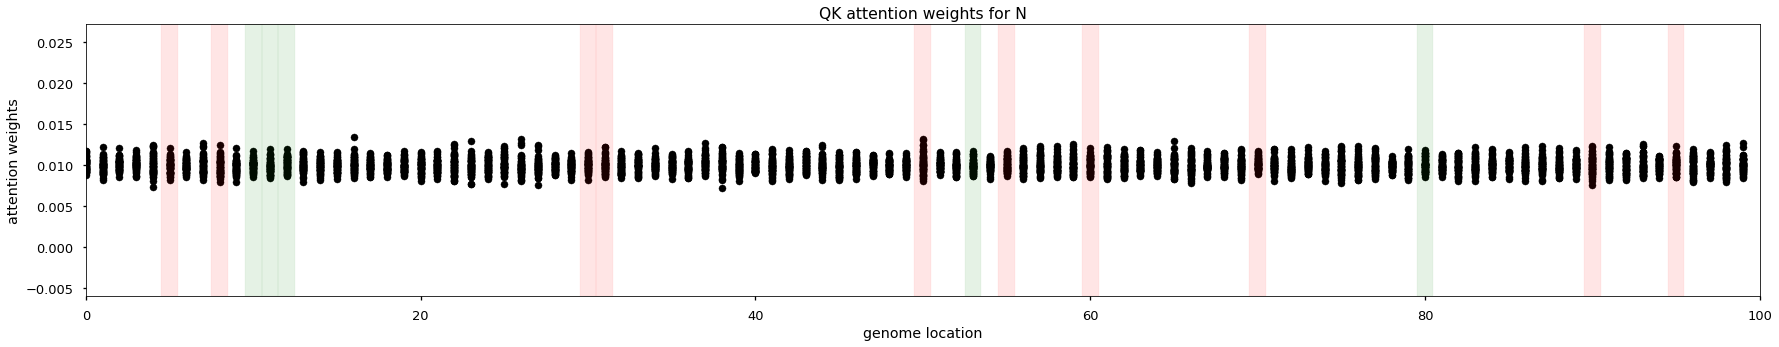

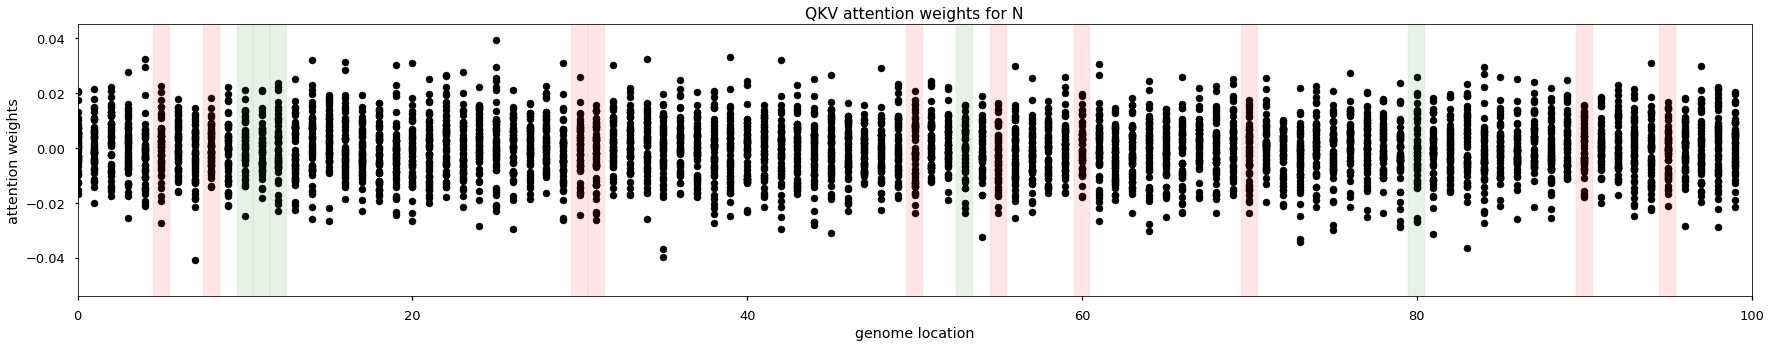

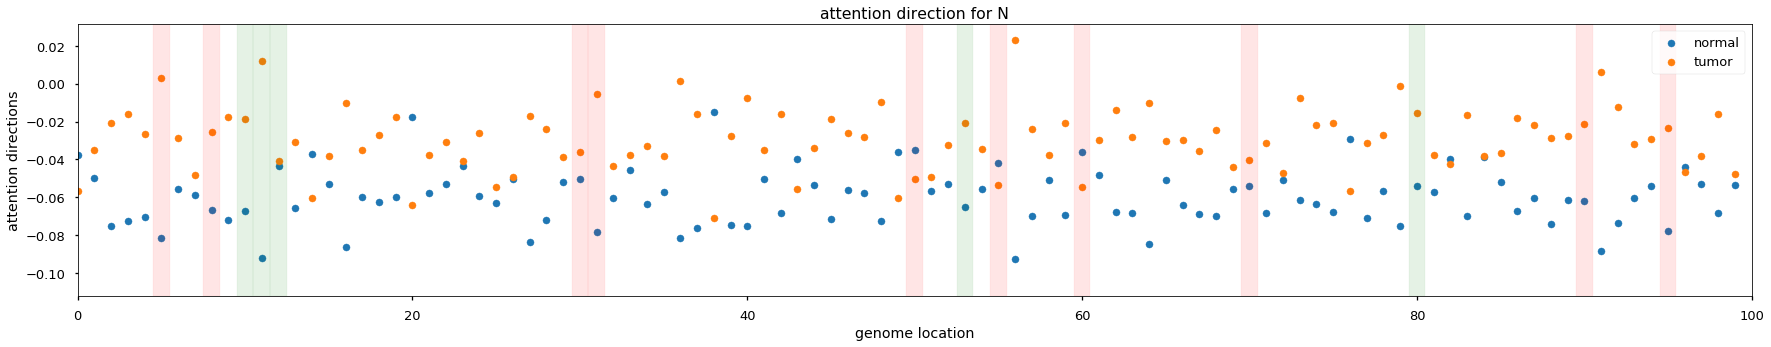

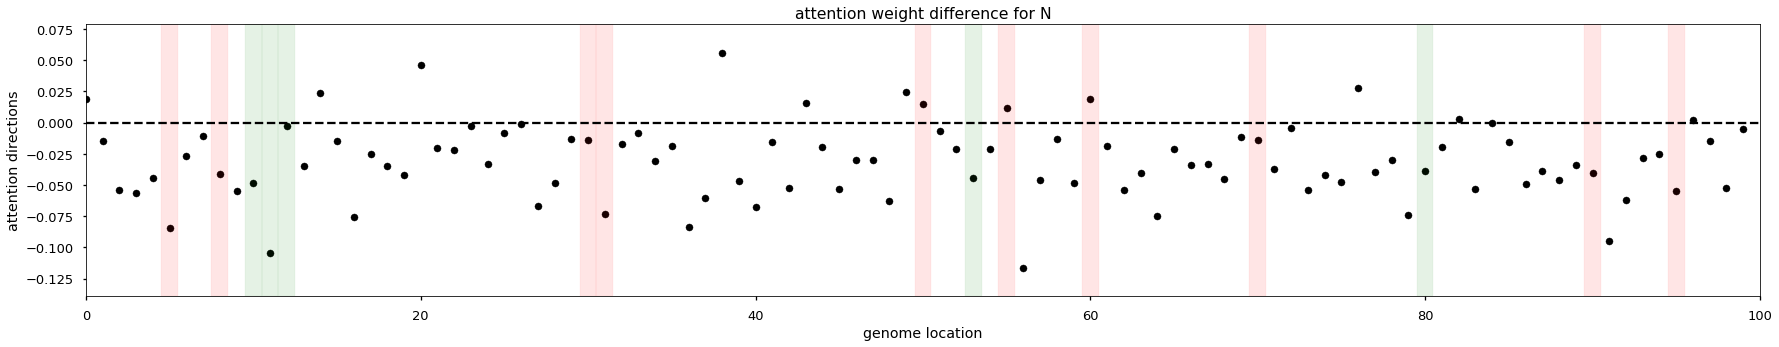

In [25]:
K_lookup_N = model.K(genome_N) 
V_lookup_N = model.V(genome_N) 
logits_N = model.Q(K_lookup_N) / math.sqrt(model.embedding_size)
probs_N = F.softmax(logits_N, dim = 0)    
X_N = probs_N * V_lookup_N
Y_N = model.W(X_N)

print(probs_N.shape)
print(Y_N.shape)
print(logits_N.shape)

# print((torch.norm(K_lookup_N,2,1).mean() + torch.norm(V_lookup_N,2,1).mean())*lam)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QK attention weights for N')
# plt.savefig('./N-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)

plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for N')
# plt.savefig('./N-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for N')
# plt.savefig('./N-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_N.data[:,0]-Y_N.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for N')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./N-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 50])
torch.Size([100, 2])


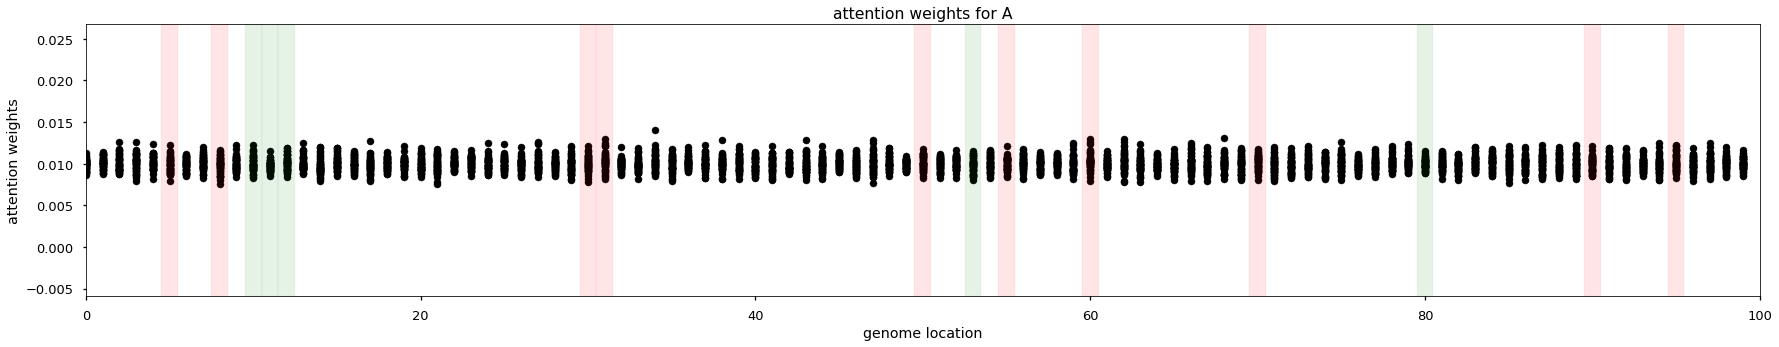

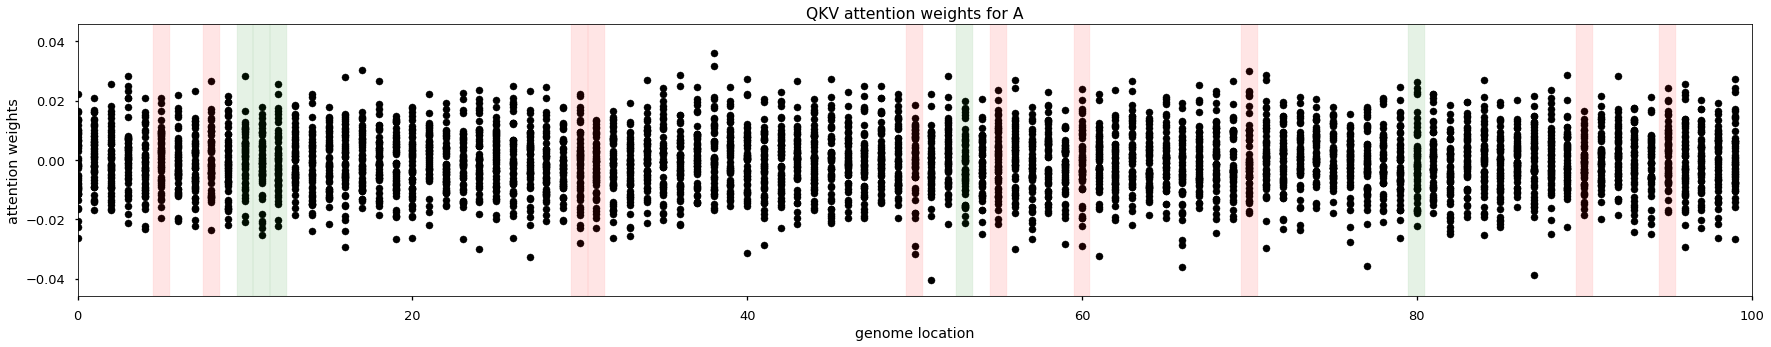

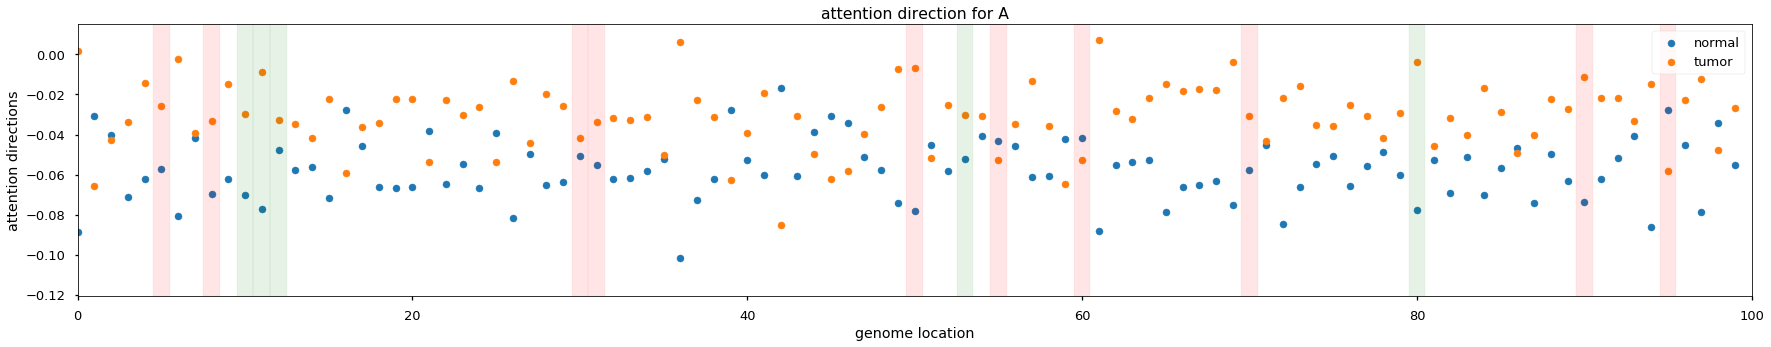

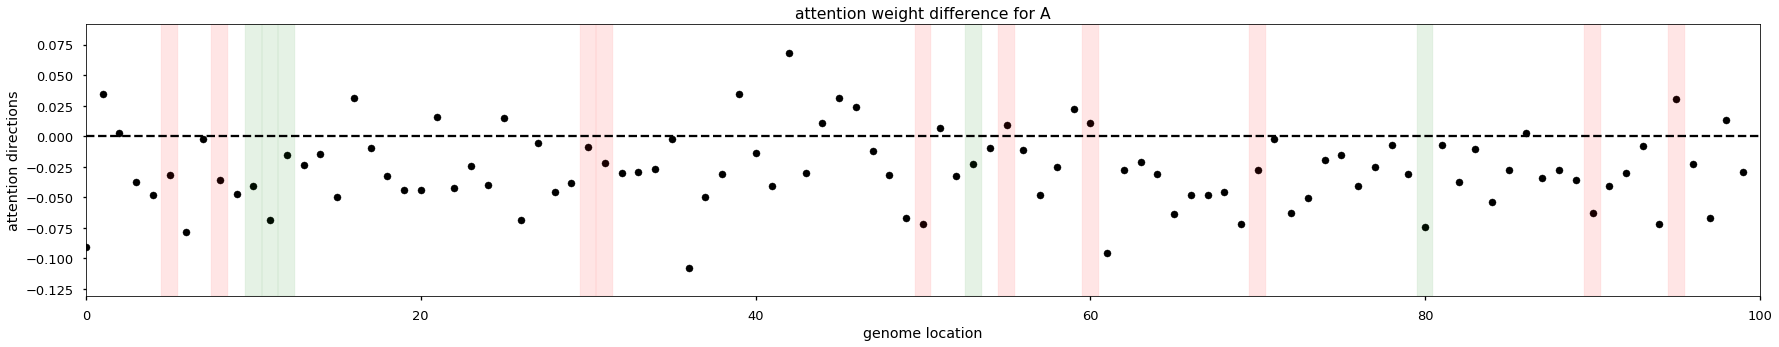

In [26]:
K_lookup_A = model.K(genome_A) 
V_lookup_A = model.V(genome_A) 
logits_A = model.Q(K_lookup_A) / math.sqrt(model.embedding_size)
probs_A = F.softmax(logits_A, dim = 0)    
X_A = probs_A * V_lookup_A
Y_A = model.W(X_A)

print(probs_A.shape)
print(Y_A.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for A')
# plt.savefig('./A-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for A')
# plt.savefig('./A-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for A')
# plt.savefig('./A-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_A.data[:,0]-Y_A.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for A')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./A-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()



torch.Size([100, 50])
torch.Size([100, 2])


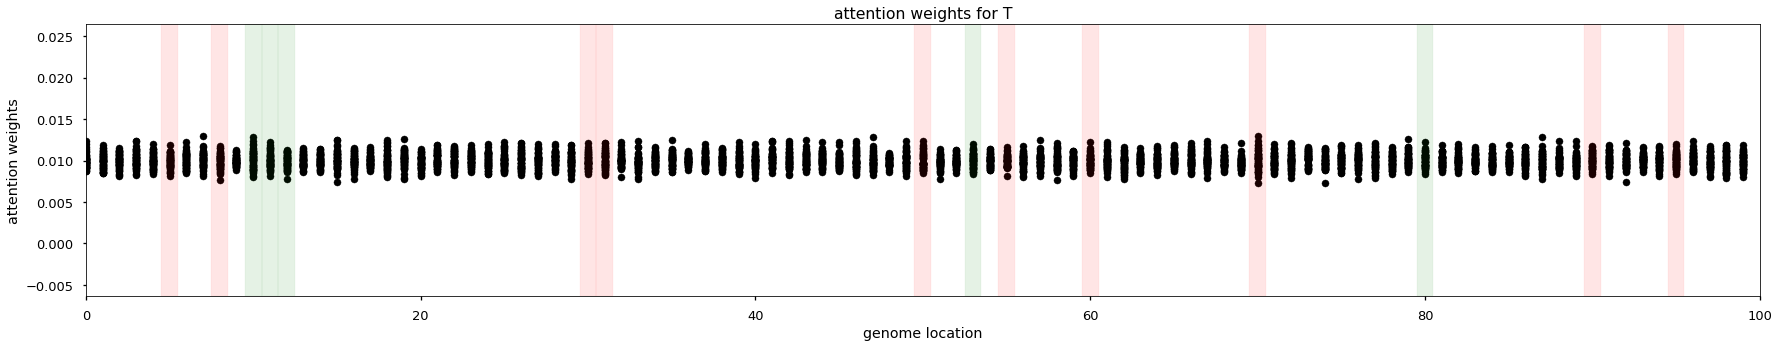

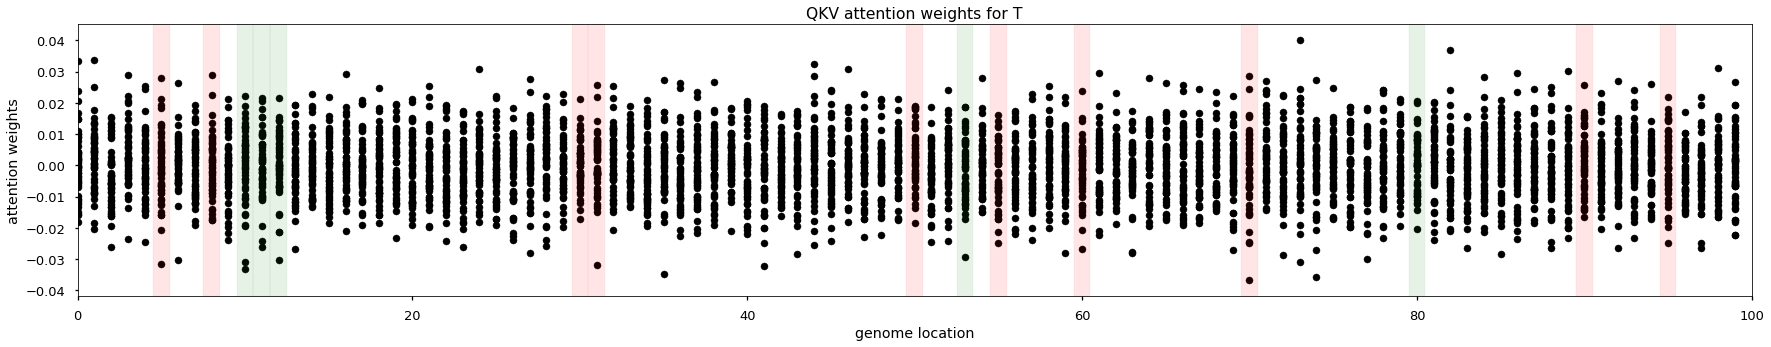

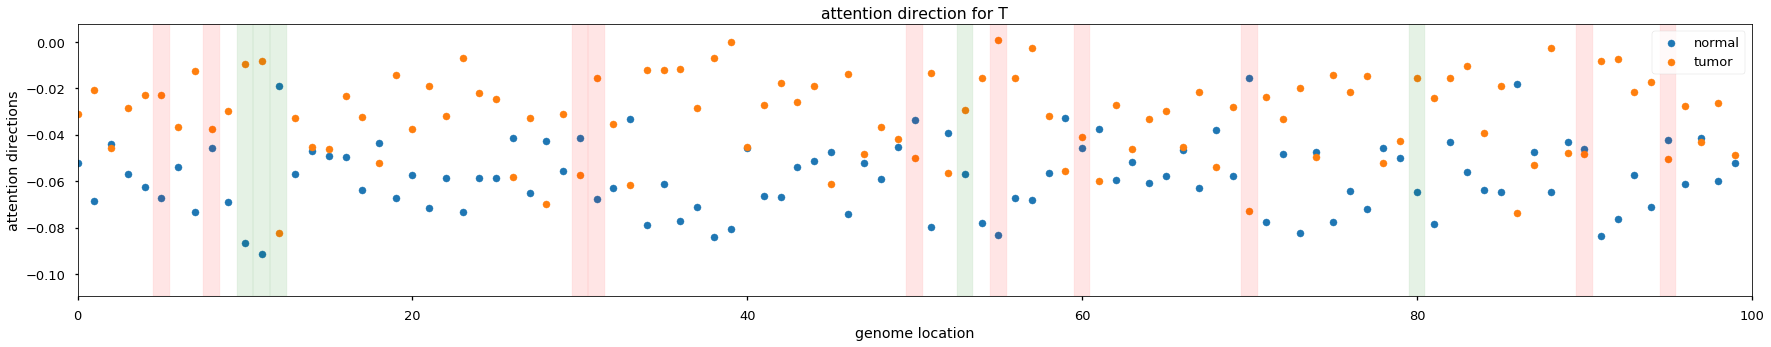

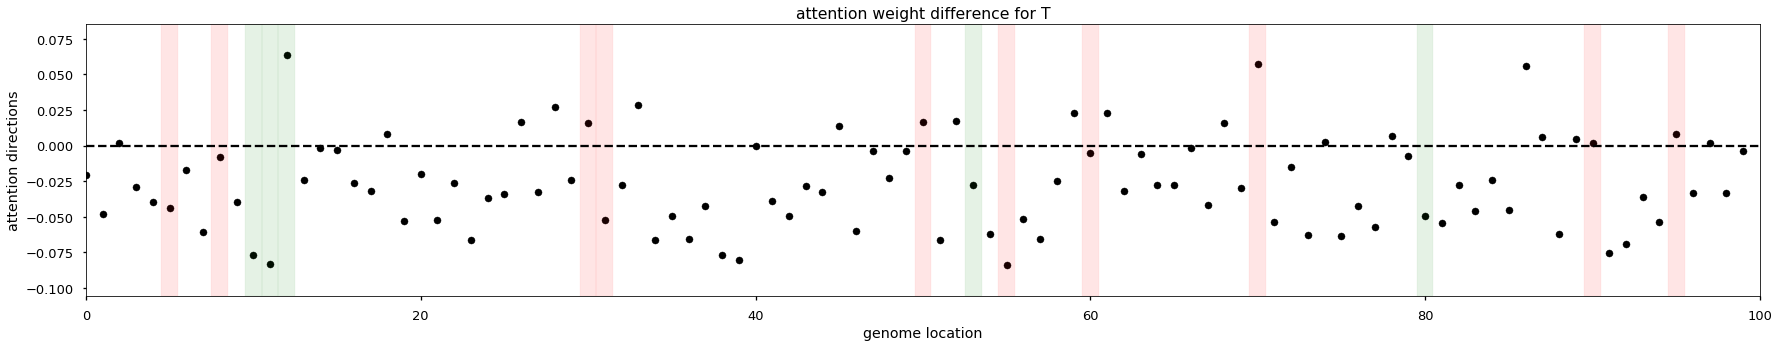

In [27]:
K_lookup_T = model.K(genome_T) 
V_lookup_T = model.V(genome_T) 
logits_T = model.Q(K_lookup_T) / math.sqrt(model.embedding_size)
probs_T = F.softmax(logits_T, dim = 0)    
X_T = probs_T * V_lookup_T
Y_T = model.W(X_T)

print(probs_T.shape)
print(Y_T.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for T')
# plt.savefig('./T-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for T')
# plt.savefig('./T-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for T')
# plt.savefig('./T-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_T.data[:,0]-Y_T.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for T')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./T-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 50])
torch.Size([100, 2])


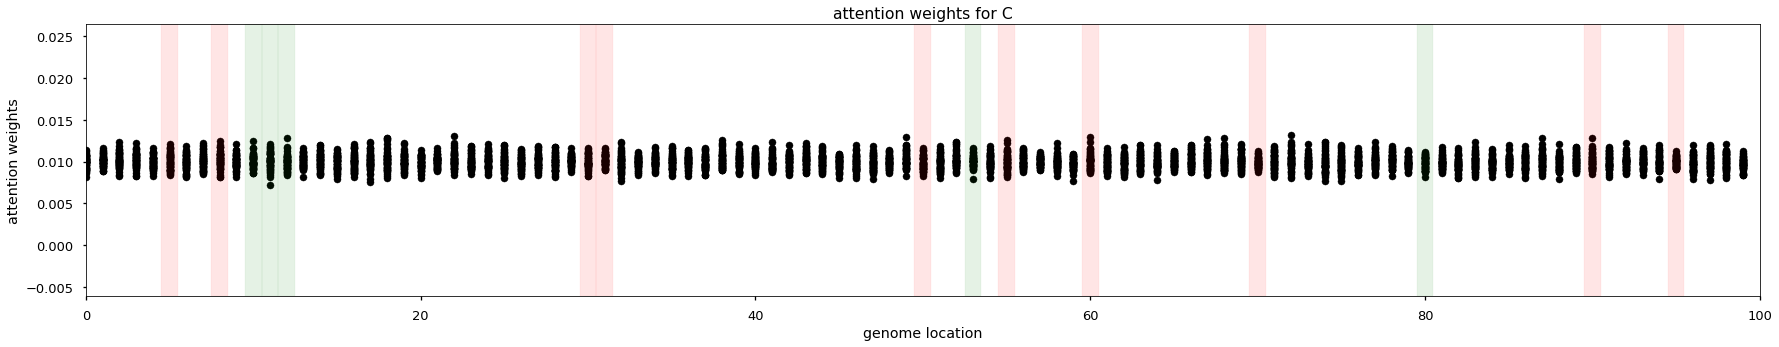

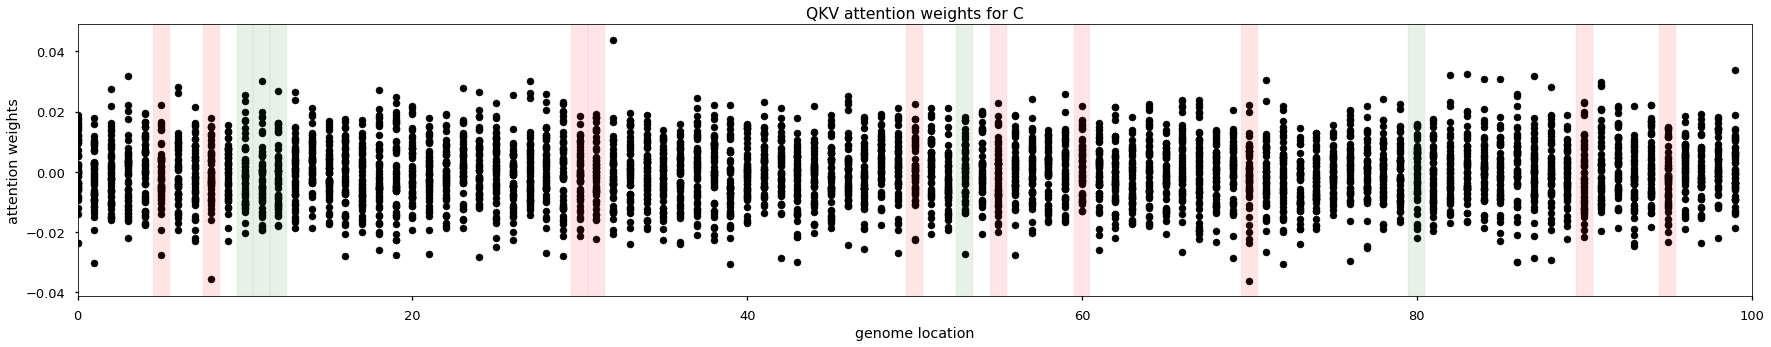

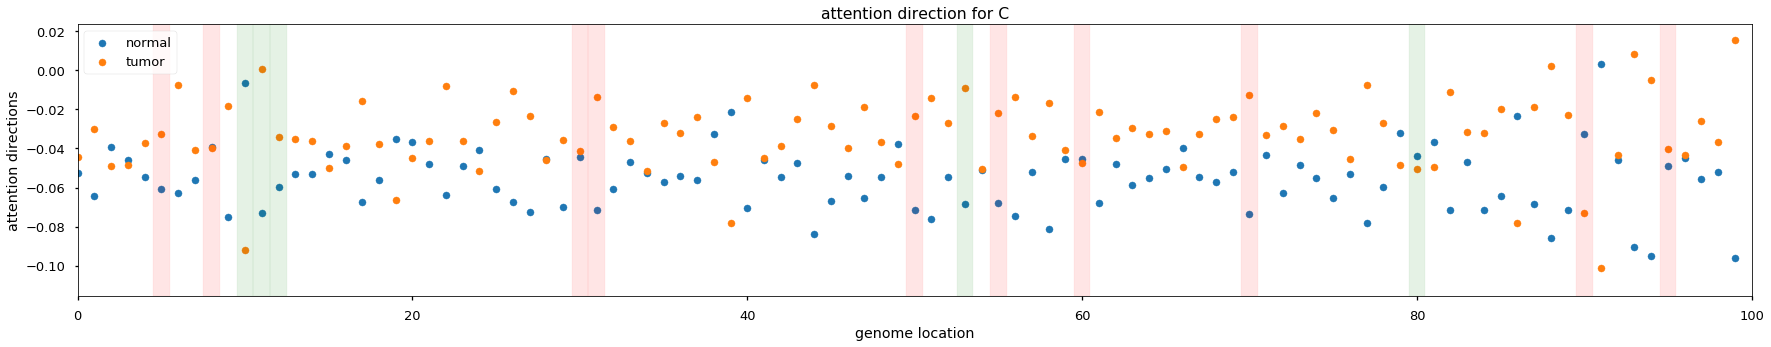

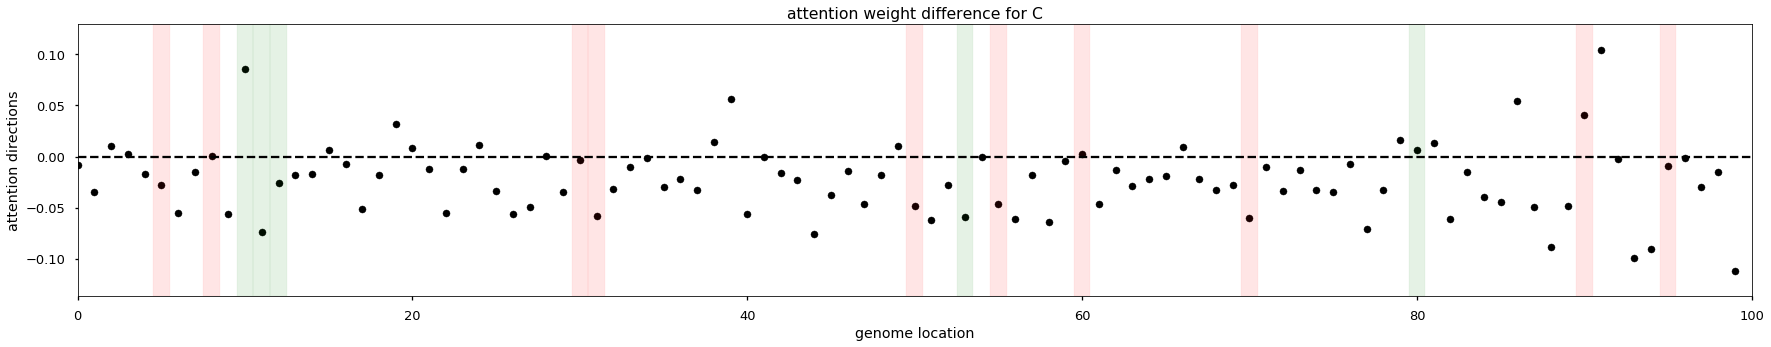

In [28]:
K_lookup_C = model.K(genome_C) 
V_lookup_C = model.V(genome_C) 
logits_C = model.Q(K_lookup_C) / math.sqrt(model.embedding_size)
probs_C = F.softmax(logits_C, dim = 0)    
X_C = probs_C * V_lookup_C
Y_C = model.W(X_C)

print(probs_C.shape)
print(Y_C.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for C')
# plt.savefig('./C-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for C')
# plt.savefig('./C-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for C')
# plt.savefig('./C-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_C.data[:,0]-Y_C.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for C')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./C-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()


torch.Size([100, 50])
torch.Size([100, 2])


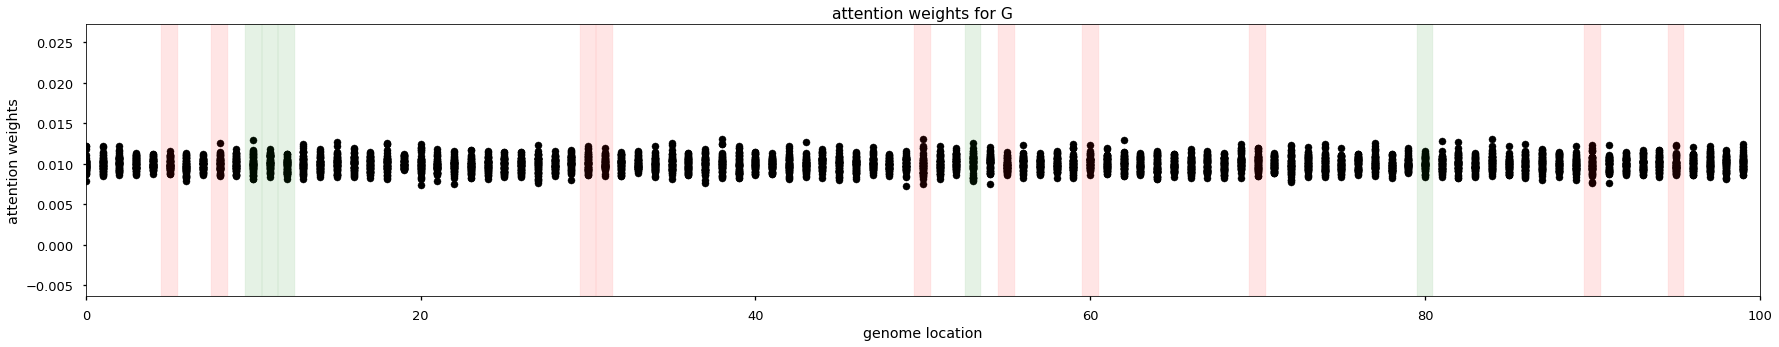

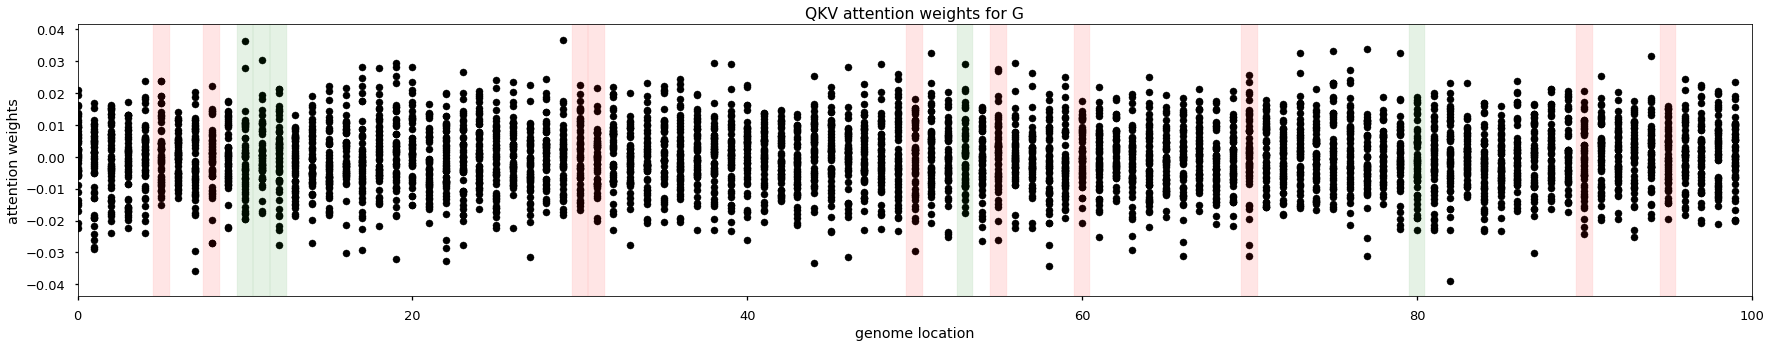

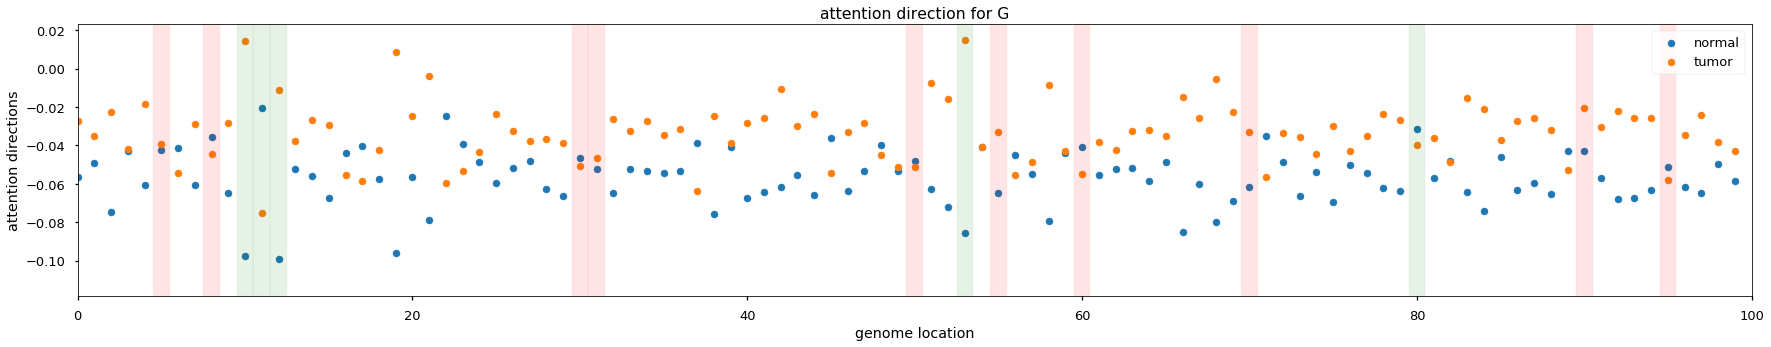

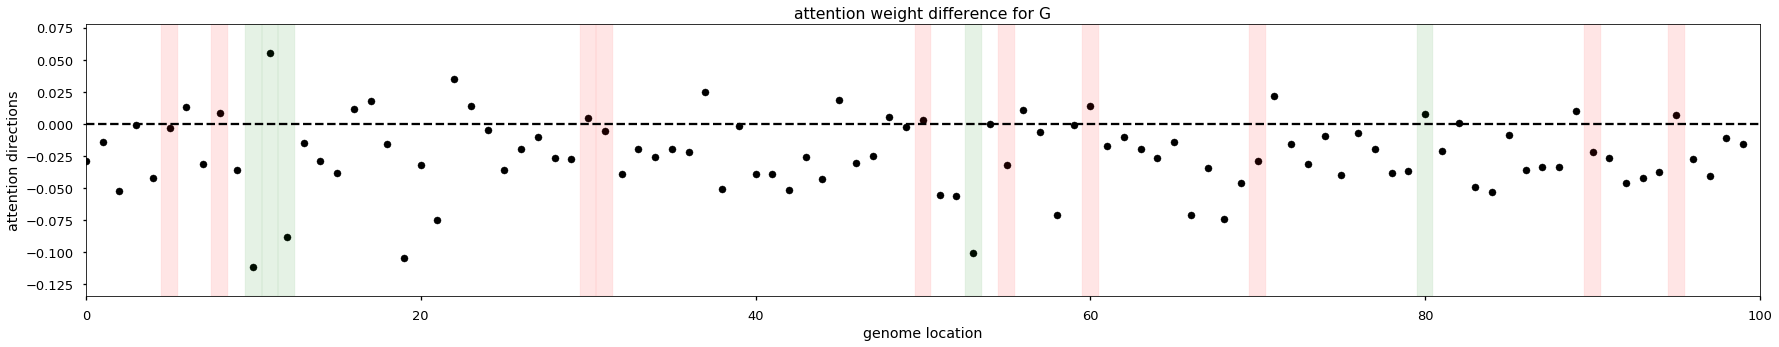

In [29]:
K_lookup_G = model.K(genome_G) 
V_lookup_G = model.V(genome_G) 
logits_G = model.Q(K_lookup_G) / math.sqrt(model.embedding_size)
probs_G = F.softmax(logits_G, dim = 0)    
X_G = probs_G * V_lookup_G
Y_G = model.W(X_G)

print(probs_G.shape)
print(Y_G.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for G')
# plt.savefig('./G-attn-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value, c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights for G')
# plt.savefig('./G-Vatt-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for G')
# plt.savefig('./G-dirc-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)
    
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='black', s=point_size, alpha=alpha_value)
# plt.plot(np.arange(GENOME_LENGTH), list(Y_G.data[:,0]-Y_G.data[:,1]), c='black')
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for G')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./G-diff-'+file_name+'.png')

for loc, value in cancer_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='red', alpha=0.1)
for loc, value in benign_genes.items():
    plt.axvspan(loc-0.5, loc+0.5, color='green', alpha=0.1)

plt.show()


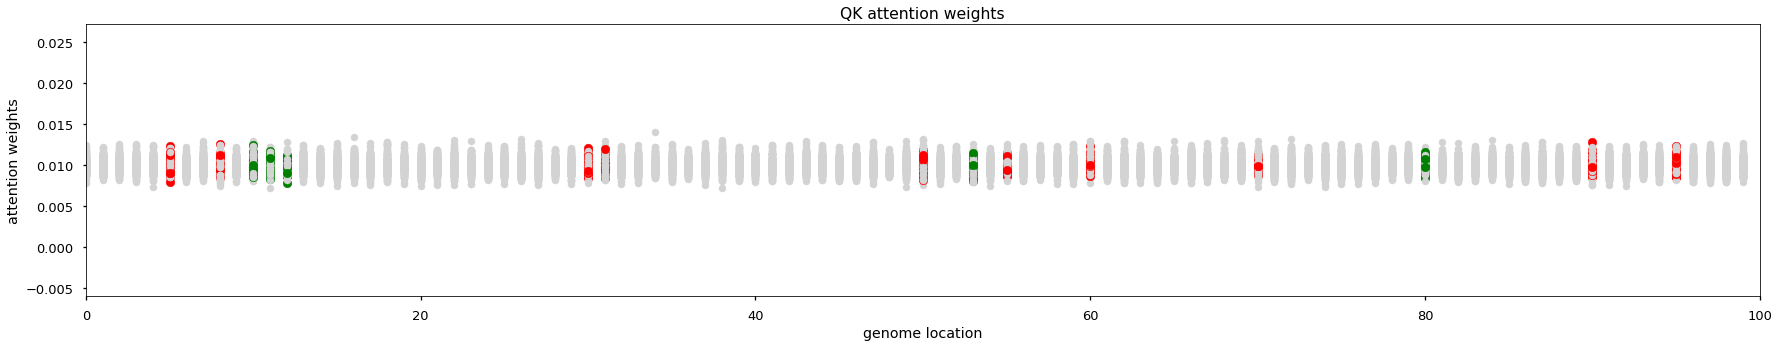

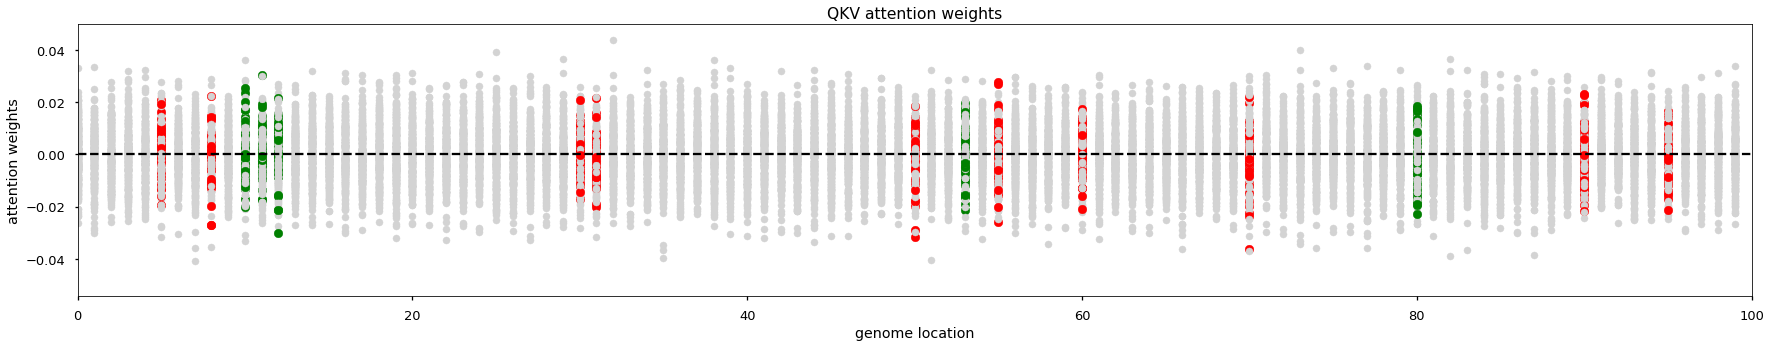

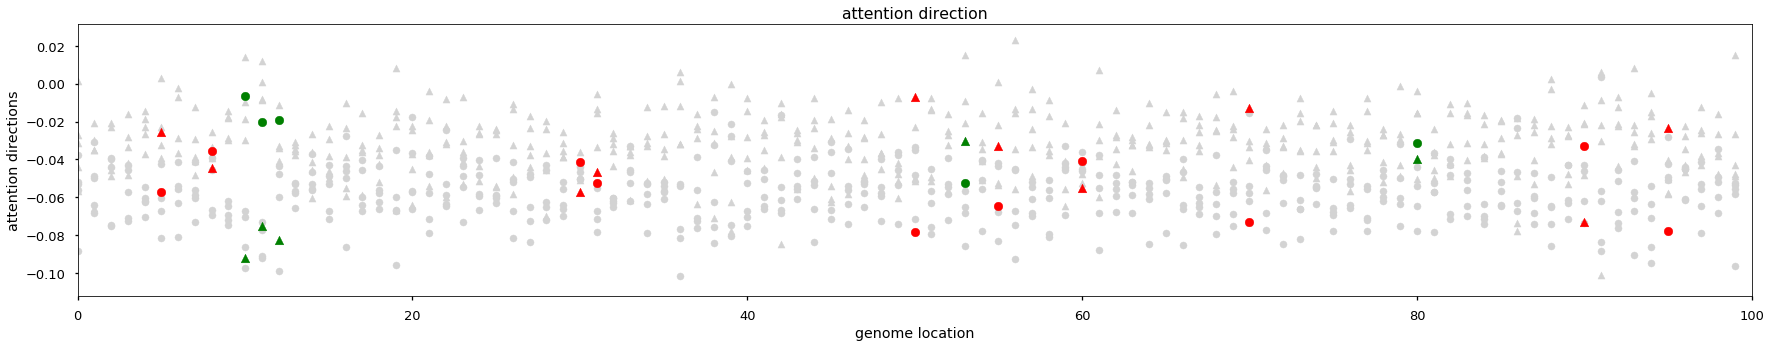

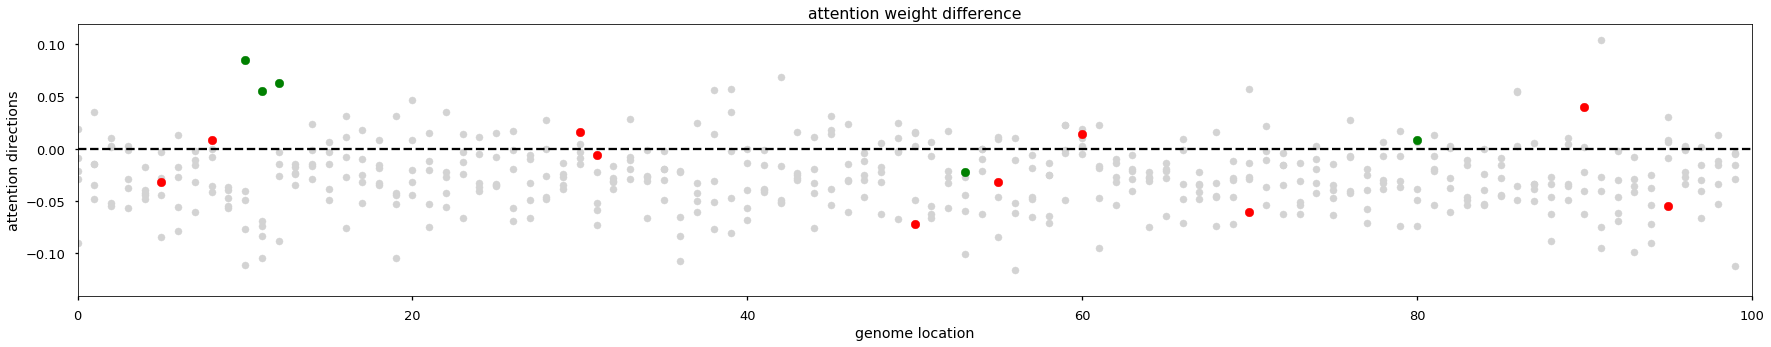

In [31]:
# probs
# X
# Y
# Y_diff

muts = {'N': [probs_N.data, X_N.data, Y_N.data, Y_N.data[:,0]-Y_N.data[:,1]],
        'A': [probs_A.data, X_A.data, Y_A.data, Y_A.data[:,0]-Y_A.data[:,1]],
        'T': [probs_T.data, X_T.data, Y_T.data, Y_T.data[:,0]-Y_T.data[:,1]],
        'C': [probs_C.data, X_C.data, Y_C.data, Y_C.data[:,0]-Y_C.data[:,1]],
        'G': [probs_G.data, X_G.data, Y_G.data, Y_G.data[:,0]-Y_G.data[:,1]]}


for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    
    for loc, value in cancer_genes.items():
        plt.scatter(loc, muts[value[0]][0][loc,q], s=point_size*1.5, alpha=alpha_value, c='red')
    for loc, value in benign_genes.items():
        plt.scatter(loc, muts[value[0]][0][loc,q], s=point_size*1.5, alpha=alpha_value, c='green')
    
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QK attention weights')
# plt.savefig('./attn-'+file_name+'.png')
plt.show()

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), X_N.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_A.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_T.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_C.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    plt.scatter(np.arange(GENOME_LENGTH), X_G.data[:,q], s=point_size, alpha=alpha_value, c='lightgray')
    
    for loc, value in cancer_genes.items():
        plt.scatter(loc, muts[value[0]][1][loc,q], s=point_size*1.5, alpha=alpha_value, c='red')
    for loc, value in benign_genes.items():
        plt.scatter(loc, muts[value[0]][1][loc,q], s=point_size*1.5, alpha=alpha_value, c='green')

plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('QKV attention weights')
# plt.savefig('./Vatt-'+file_name+'.png')
plt.axhline(y=0,ls='dashed',c='black')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0], s=point_size, alpha=alpha_value, marker='o', c='lightgray')
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,1], s=point_size, alpha=alpha_value, marker='^', c='lightgray')

for loc, value in cancer_genes.items():
    plt.scatter(loc, muts[value[0]][2][loc,0], s=point_size*1.5, alpha=alpha_value, marker='o', c='red')
    plt.scatter(loc, muts[value[0]][2][loc,1], s=point_size*1.5, alpha=alpha_value, marker='^', c='red')
for loc, value in benign_genes.items():
    plt.scatter(loc, muts[value[0]][2][loc,0], s=point_size*1.5, alpha=alpha_value, marker='o', c='green')
    plt.scatter(loc, muts[value[0]][2][loc,1], s=point_size*1.5, alpha=alpha_value, marker='^', c='green')

# plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction')
# plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='lightgray', s=point_size, alpha=alpha_value)
for loc, value in cancer_genes.items():
    plt.scatter(loc, muts[value[0]][3][loc], s=point_size*1.5, alpha=alpha_value, c='red')
for loc, value in benign_genes.items():
    plt.scatter(loc, muts[value[0]][3][loc], s=point_size*1.5, alpha=alpha_value, c='green')
    
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference')
plt.axhline(y=0,ls='dashed',c='black')
# plt.savefig('./diff-'+file_name+'.png')   
plt.show()
